<a href="https://colab.research.google.com/github/vladgap/LLC/blob/main/LLC%20simulation%20equilibrium%20models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn import preprocessing
import matplotlib.pyplot as plt
pd.options.plotting.backend = "plotly"


In [3]:
!wget -O MLNN.py "https://raw.githubusercontent.com/vladgap/MLNN/main/MLNN_3_2.py"
from MLNN import *

--2025-02-05 06:33:04--  https://raw.githubusercontent.com/vladgap/MLNN/main/MLNN_3_2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14169 (14K) [text/plain]
Saving to: ‘MLNN.py’

MLNN.py             100%[===================>]  13.84K  --.-KB/s    in 0.002s  

2025-02-05 06:33:05 (5.64 MB/s) - ‘MLNN.py’ saved [14169/14169]

Version of MLNN is 3.2


In [4]:
def CopyPasteToArray(a):
  if a.startswith('\n'):
    b=a[1:]
  else:
    b=a
  if b.endswith('\n'):
    b=b[:-1]
  c=b.replace('\t',',')
  d=c.split('\n')
  f=[]
  for e in d:
    if e.replace(',','').replace('.','').isdigit(): # only digits no letters
      f.append(list(eval(e)))
    else:
      f.append(e.split(','))
  return f

In [5]:
# @title class Fit2to1
class Fit2to1:
  def __init__(self,X,T,mesh,confidences=None,hidden_layers=1,hidden_activation='linear'):
    self.X=X
    self.T=T
    self.mesh=mesh
    self.confidences=confidences
    self.hidden_layers=hidden_layers
    self.hidden_activation=hidden_activation
    self.scaler_X, self.scaler_T = self.__get_scalers()
    self.X_sc = self.scaler_X.transform(X)
    self.T_sc = self.scaler_T.transform(T)
    self.network=VectorBackProp(layers=[2,hidden_layers,1], hidden_activation = hidden_activation)
    pd.options.plotting.backend = "plotly"

  def fit_model(self, epochs=1000,  learning_rate = 0.001, momentum_term = 0.95):
    self.network.fit(self.X_sc, self.T_sc, epochs=epochs, confidences=self.confidences, learning_rate = learning_rate, momentum_term = momentum_term)
    print('Initial loss =', self.network.loss_list[0])
    print('Final loss =', self.network.loss_list[-1])
    fig=pd.Series(self.network.loss_list).plot()
    fig.show()

  def import_weights(self,weights):
    self.network.import_weights(weights)

  def export_weights(self):
    print ('Hidden layers:', self.hidden_layers)
    print ('Hidden activation:', self.hidden_activation)
    print ('Loss:', self.network.loss_list[-1],'\n')
    return self.network.export_weights()

  def print_weights(self):
    self.network.print_weights()

  def print_scaler_data(self):
    print('scaler X -- mean, stdev:  ',self.scaler_X.mean_, self.scaler_X.scale_)
    print('scaler T -- mean, stdev:  ',self.scaler_T.mean_, self.scaler_T.scale_)

  def show(self):
    self.predics=self.scaler_T.inverse_transform(self.network.run(self.X_sc))
    self.errors=(self.predics[:,0]-self.T[:,0])/self.T[:,0]*100
    self.mesh_predics=self.scaler_T.inverse_transform(self.network.run(self.scaler_X.transform(self.mesh)))
    self.__plot()

  def __get_scalers(self):
    scaler_X = preprocessing.StandardScaler().fit(self.X)
    scaler_T = preprocessing.StandardScaler().fit(self.T)
    return scaler_X, scaler_T

  def __plot(self):
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Errors','Model'), column_widths=[0.5, 0.5],
                     specs=[[{"secondary_y": True}, {"type": "scene"}]])

    fig.add_trace(go.Scatter(x=self.T[:,0] , y=self.predics[:,0], mode='markers', marker_size=4, name='Predics', marker_color='black' ), 1, 1)
    fig.add_trace(go.Scatter(x=self.T[:,0], y=self.T[:,0], mode='lines', line_color='red', line_width=0.2, showlegend=False),1,1,secondary_y=False)
    fig.add_trace(go.Scatter(x=self.T[:,0] , y=self.errors, mode='markers', marker_size=4, name='Errors', marker_color='orange' ), 1, 1, secondary_y=True,)

    fig.add_trace(go.Scatter3d(x=self.X[:,0], y=self.X[:,1], z=self.T[:,0], mode='markers', name='Data'), 1, 2)
    fig.add_trace(go.Scatter3d(x=self.mesh[:,0], y=self.mesh[:,1], z=self.mesh_predics[:,0], mode='markers',marker_color='green', marker_size=1, name='Mesh'),1,2)

    fig.update_layout(title='', autosize=True,
                      # width=1550,
                      height=500,
                      margin=dict(l=0, r=0, b=0, t=30))
    fig.update_scenes(xaxis_title='X1', yaxis_title='X2',
                      camera_eye=dict(x=0, y=-2.2, z=0),
                      aspectratio=dict(x=1, y=1, z=1)
                      )
    fig.update_scenes(camera_projection_type="orthographic")

    fig.show()

# 1 - EQUIL_rotem_lit1
lit data with NN model (7 hidden sigmoids)

In [6]:
data1=pd.DataFrame(data=[
[63.5,	1.3,	42.4,	15.0],
[58.7,	1.2,	36.9,	13.8],
[52.0, 1.0,	27.7,	11.8],
[45.5,	1.0,	18.9,	9.6],
[39.1,	1.4,	10.2,	8.3],
[31.5,	1.5,	5.1,	8.8],
[22.9,	2.0,	2.3,	9.0],
[12.6,	2.2,	0.90,	9.3],
[6.3,	2.4,	0.45,	9.45],
[0.01,	2.6,	0.01,	9.6],
],
columns=['H3PO4_aq', 'solvent_aq', 'H3PO4_org', 'water_org'])

In [7]:
data1.head()

H3PO4_aq  solvent_aq  H3PO4_org  water_org
0      63.5         1.3       42.4       15.0
1      58.7         1.2       36.9       13.8
2      52.0         1.0       27.7       11.8
3      45.5         1.0       18.9        9.6
4      39.1         1.4       10.2        8.3

In [8]:
fig1=go.Figure()
[fig1.add_trace(go.Scatter(x=data1.H3PO4_aq, y=data1[data1.columns[i]], name=data1.columns[i])) for i in range(1,4)]
fig1.update_layout(title='', width=1200, height=600,)
fig1.show()

In [9]:
X1=np.array(data1)[:,[0]]
T1=np.array(data1)[:,[1,2,3]]

## Model

### scaling

In [10]:
scaler_X1 = preprocessing.StandardScaler().fit(X1)
scaler_T1 = preprocessing.StandardScaler().fit(T1)

# scaler_X1.mean_, scaler_X1.scale_ = np.zeros(X1.shape[1]), np.ones(X1.shape[1]) # disable scaling
# scaler_T1.mean_, scaler_T1.scale_ = np.zeros(X1.shape[1]), np.ones(X1.shape[1]) # disable scaling

scaler_data1 = [scaler_X1.mean_, scaler_X1.scale_, scaler_T1.mean_, scaler_T1.scale_]
print('scaler X -- mean, stdev:  ',scaler_data1[0], scaler_data1[1])
print('scaler T -- mean, stdev:  ',scaler_data1[2], scaler_data1[3])

X_sc1 = scaler_X1.transform(X1)
T_sc1 = scaler_T1.transform(T1)
X_sc1[0:3]

scaler X -- mean, stdev:   [33.211] [21.13387066]
scaler T -- mean, stdev:   [ 1.66  14.486 10.465] [ 0.56071383 15.23739033  2.16703138]


array([[1.433197  ],
       [1.20607344],
       [0.8890468 ]])

In [11]:
def print_scaler_data(scaler_data):
    print('scaler X -- mean, stdev:  ',scaler_data[0], scaler_data[1])
    print('scaler T -- mean, stdev:  ',scaler_data[2], scaler_data[3])

### parameter searching

In [12]:
bp_iter=VectorBackProp(layers=[1,7,3], hidden_activation = 'sigmoid')
learning_rate = [0.05, 0.1, 0.5]
momentum_term = [0.8, 0.9, 0.95]
learning_rate_decay = [0, 0.5]
repeats = range(5)
rows=len(learning_rate) * len(momentum_term) * len(learning_rate_decay) * len(repeats)
print ('total runs:', rows)
output = np.zeros((rows,5))
i=0
weights_list = []
for lr in learning_rate:
    for mt in momentum_term:
        for lrd in learning_rate_decay:
            for rep in repeats:
                bp_iter.fit(X_sc1, T_sc1, epochs=1000, learning_rate = lr, momentum_term = mt, learning_rate_decay = lrd, repeat=False)
                relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
                output[i] = [lr, mt, lrd, bp_iter.loss_list[-1], relative_delta[-1]]
                weights_list.append(bp_iter.export_weights())
                print (i, end=' ')
                if i%25==0 and i>0:
                    print ('\n')
                i+=1


total runs: 90
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

51 52 53 54 55 56 57 58 59 

/content/MLNN.py:37: RuntimeWarning:

overflow encountered in exp

/content/MLNN.py:93: RuntimeWarning:

overflow encountered in square

/content/MLNN.py:125: RuntimeWarning:

overflow encountered in matmul

/content/MLNN.py:125: RuntimeWarning:

invalid value encountered in multiply

<ipython-input-12-162517e96d7f>:16: RuntimeWarning:

invalid value encountered in scalar divide



60 

/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:49: RuntimeWarning:

overflow encountered in reduce

<ipython-input-12-162517e96d7f>:16: RuntimeWarning:

invalid value encountered in scalar subtract



61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 

76 77 78 79 80 81 82 83 84 85 86 87 88 89 

In [13]:
output_table = pd.DataFrame(data=output, columns=['learning_rate', 'momentum_term', 'learning_rate_decay', 'final_loss', 'relative_delta'])
output_table.fillna(value = 1.1, inplace = True)
output_table.sort_values(by=['final_loss'])

learning_rate  momentum_term  learning_rate_decay  final_loss  \
54           0.10           0.95                  0.0    0.005881   
51           0.10           0.95                  0.0    0.007975   
24           0.05           0.95                  0.0    0.011691   
20           0.05           0.95                  0.0    0.011871   
42           0.10           0.90                  0.0    0.012017   
..            ...            ...                  ...         ...   
79           0.50           0.90                  0.5    3.000000   
85           0.50           0.95                  0.5    3.000000   
68           0.50           0.80                  0.5    3.000000   
76           0.50           0.90                  0.5    3.000000   
78           0.50           0.90                  0.5    3.000000   

    relative_delta  
54   -2.947646e-02  
51   -1.284796e-01  
24   -4.298607e-02  
20   -3.239270e-02  
42   -4.167306e-02  
..             ...  
79    1.480297e-14  
85    1.480297e-14  
68    0.000000e+00  
76    0.000000e+00  
78    0.000000e+00  

[90 rows x 5 columns]

In [14]:
fig = go.Figure(data=
    go.Parcoords(

        dimensions = list([
            dict(
                label = 'learning_rate', values = output_table['learning_rate']),
            dict(
                label = 'momentum_term', values = output_table['momentum_term']),
            dict(range = [0, 1],
                label = 'learning_rate_decay', values = output_table['learning_rate_decay']),
            dict(range = [0, 0.2],
                label = 'final_loss', values = output_table['final_loss']),
            dict(
                label = 'relative_delta', values = output_table['relative_delta']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

### running best parameters

In [15]:
bp_iter=VectorBackProp(layers=[1,7,3], hidden_activation = 'sigmoid')
weights_lists2=[]
loss_lists2=[]
relative_delta_lists2=[]
n = 10
for i in range(n):
    bp_iter.fit(X_sc1, T_sc1, epochs=1500, learning_rate = 0.1, momentum_term = 0.95, learning_rate_decay = 0, repeat=False)
    relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
    weights_lists2.append(bp_iter.export_weights())
    loss_lists2.append(bp_iter.loss_list)
    relative_delta_lists2.append(relative_delta)

In [16]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=loss_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[0,0.05], title='Loss')
fig2.show()

### best_weights_for_now

In [17]:
best_weights_for_now2=weights_lists2[0] # 7 hidden
best_weights_for_now2

[[[-3.5701497421785313,
   -8.910654931434827,
   2.4065856266821255,
   -6.875010924915389,
   3.9917160839429418,
   0.5287202695556767,
   -0.842600171619966]],
 [[-5.377076607059471,
   4.384306607530296,
   -0.7116455894572289,
   -2.05810801357937,
   -3.9324436059708,
   -12.004195495260525,
   6.468992506699184]],
 [[1.6659848837854394, -0.0005271169020093227, 0.02014584019187491],
  [1.6434096899918553, -0.1466144442776037, -1.4746438040213194],
  [1.013777897778666, 1.5165763798642498, -3.7302342214618145],
  [1.6228346338398514, 0.1550373956372756, -0.7614936443560819],
  [1.078166351259152, 1.5600235118568926, 4.337239917652649],
  [4.803850930195902, 2.61126771130821, 6.499021581518265],
  [-2.0575122555497702, -2.003957932195687, -1.6321389819183543]],
 [[-0.45691154513559207, 1.0325306758164448, 3.489610595875614]]]

In [18]:
manual_best_weights_for_now2=[[[-4.215621245080982,
   -8.235086763118087,
   -1.6251342150606451,
   -6.9206357615871035,
   -3.4092427169369826,
   -7.4263402914028775,
   -3.7003458539301977]],
 [[0.8764395040443358,
   3.9145850159876945,
   -1.5013585830931442,
   -1.194371163565281,
   4.118411550251139,
   5.892242255497829,
   -6.755593628941706]],
 [[-2.6609909047049918, -0.44480776958732143, 1.9256391063013463],
  [2.566022222516618, -0.5042582093932455, -1.432212975592254],
  [1.405004033981333, -0.2988952466228391, 0.5807591718257896],
  [2.0692859230668117, -0.0780871568942863, -0.5145373287488922],
  [-0.7989625307881565, -1.957459884661486, -2.8991426864622065],
  [-0.5821795598385298, -0.22284877970127598, -0.9077232625087237],
  [1.619488070885094, 0.03697105802710269, 0.008613201857731975]],
 [[-0.4010006364699687, 2.4687577407660806, 2.995012357373033]]]

 # 7 relu
 # epochs=1000, learning_rate = 0.1, momentum_term = 0.95, learning_rate_decay = 0
 # loss = .00038

### fitting best parameters

In [19]:
bp1=VectorBackProp(layers=[1,7,3], hidden_activation = 'sigmoid')

In [20]:
# bp1.import_weights(best_weights_for_now2)
bp1.import_weights(manual_best_weights_for_now2)
bp1.fit(X_sc1, T_sc1, epochs=5000, learning_rate = 0.1, momentum_term = 0.9, learning_rate_decay = 1, repeat=True)

In [21]:
fig1=go.Figure()
fig1.add_trace(go.Scatter(y=bp1.loss_list[20:], name=''))
print('Initial loss =', bp1.loss_list[0])
print('Final loss =', bp1.loss_list[-1])
# fig1.show()

Initial loss = 0.00038317489657026835
Final loss = 0.00038081061323728493


### prediction

In [22]:
predics1=scaler_T1.inverse_transform(bp1.run(X_sc1))
predics1

array([[1.29918281e+00, 4.24818141e+01, 1.49962517e+01],
       [1.20153909e+00, 3.67329683e+01, 1.38077713e+01],
       [9.98853822e-01, 2.78389142e+01, 1.17944258e+01],
       [1.00094900e+00, 1.88213747e+01, 9.60332916e+00],
       [1.39837341e+00, 1.02414093e+01, 8.29734125e+00],
       [1.50272999e+00, 5.07996128e+00, 8.80178587e+00],
       [1.99276586e+00, 2.28913730e+00, 8.99802472e+00],
       [2.22136370e+00, 9.49095682e-01, 9.29600691e+00],
       [2.37724870e+00, 4.07546881e-01, 9.45913277e+00],
       [2.60699794e+00, 1.89286597e-02, 9.59614282e+00]])

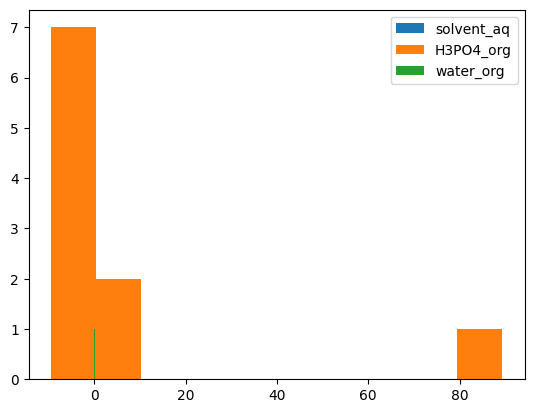

In [23]:
pred=predics1
predics1_y1=pred[:,0]
error1_y1=(predics1_y1-T1[:,0])/T1[:,0]*100
predics1_y2=pred[:,1]
error1_y2=(predics1_y2-T1[:,1])/T1[:,1]*100
predics1_y3=pred[:,2]
error1_y3=(predics1_y3-T1[:,2])/T1[:,2]*100

plt.hist(error1_y1)
plt.hist(error1_y2)
plt.hist(error1_y3)
plt.legend(['solvent_aq', 'H3PO4_org', 'water_org'])
plt.show()

In [24]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("solvent_aq", "H3PO4_org", "water_org"), column_widths=[0.33, 0.33, 0.33],
                     specs=[[{"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}]])

fig.add_trace(go.Scatter(x=T1[:,0] , y=predics1_y1, mode='markers', marker_size=4, name='predics solvent_aq', marker_color='black' ), 1, 1)
fig.add_trace(go.Scatter(x=T1[:,1] , y=predics1_y2, mode='markers', marker_size=4, name='predics H3PO4_org', marker_color='black' ), 1, 2)
fig.add_trace(go.Scatter(x=T1[:,2] , y=predics1_y3, mode='markers', marker_size=4, name='predics water_org', marker_color='black' ), 1, 3)

fig.add_trace(go.Scatter(x=T1[:,0] , y=error1_y1, mode='markers', marker_size=4, name='error solvent_aq', marker_color='orange' ), 1, 1, secondary_y=True,)
fig.add_trace(go.Scatter(x=T1[:,1] , y=error1_y2, mode='markers', marker_size=4, name='error H3PO4_org', marker_color='orange' ), 1, 2, secondary_y=True,)
fig.add_trace(go.Scatter(x=T1[:,2] , y=error1_y3, mode='markers', marker_size=4, name='error water_org', marker_color='orange' ), 1, 3, secondary_y=True,)

fig.update_layout(title='', autosize=True,
                  width=1550, height=350,
                  margin=dict(l=0, r=0, b=0, t=30))

# fig.update_xaxes(title_text="", range=[0.5, 2], row=1, col=1)
# fig.update_yaxes(title_text="", range=[0.5, 2], row=1, col=1)
# fig.update_yaxes(title_text="%error", range=[-10, 10], row=1, col=1, secondary_y=True, showgrid=False, tick0=-10, dtick=2)

# fig.update_xaxes(title_text="", range=[0, 30], row=1, col=2)
# fig.update_yaxes(title_text="", range=[0, 30], row=1, col=2)
# fig.update_yaxes(title_text="%error", range=[-10, 10], row=1, col=2, secondary_y=True, showgrid=False, tickvals=[-10,-5,-1,0,1,5,10])

# fig.update_xaxes(title_text="", range=[0.5, 2], row=1, col=3)
# fig.update_yaxes(title_text="", range=[0.5, 2], row=1, col=3)
# fig.update_yaxes(title_text="%error", range=[-10, 10], row=1, col=3, secondary_y=True, showgrid=False, tick0=-10, dtick=2)

fig.show()

In [25]:
fig1=go.Figure()
[fig1.add_trace(go.Scatter(x=data1.H3PO4_aq, y=data1[data1.columns[i]], name=data1.columns[i])) for i in range(1,4)]
[fig1.add_trace(go.Scatter(x=data1.H3PO4_aq, y=predics1[:,i-1], name=data1.columns[i]+' predic')) for i in range(1,4)]
fig1.update_layout(title='', width=1200, height=600,)
fig1.show()

In [26]:
bp1.print_weights()

Layers (input, hidden, output):  [1, 7, 3] sigmoid linear
Hidden layer weights:  [[-4.2162815777330085, -8.236427344741891, -1.6265562154077091, -6.926844604080739, -3.410136445138649, -7.427211500499821, -3.698373385957032]]
Hidden layer biases:  [[0.8749609721309338, 3.915066755231797, -1.5043851456784056, -1.1933274736382808, 4.11803087066856, 5.891291936612865, -6.7529352557888345]]
Outlet layer weights:  [[-2.6637624183906037, -0.44429745776758944, 1.925512185445992], [2.56652197535487, -0.5044852108445952, -1.4308467586235958], [1.4081943772224144, -0.2988396633936384, 0.5790139596771477], [2.0706074705294526, -0.07814100423571195, -0.5147035662833175], [-0.7994591758762682, -1.9576912892382201, -2.8993300894277243], [-0.5818666247735891, -0.22231346757065326, -0.906567414721736], [1.6164616666285654, 0.03723323842515629, 0.009502354390850938]]
Outlet layer biases:  [[-0.4010711584850023, 2.4680696956720007, 2.9941194913517157]]


In [27]:
print (*scaler_data1)

[33.211] [21.13387066] [ 1.66  14.486 10.465] [ 0.56071383 15.23739033  2.16703138]


In [28]:
print_scaler_data(scaler_data1)

scaler X -- mean, stdev:   [33.211] [21.13387066]
scaler T -- mean, stdev:   [ 1.66  14.486 10.465] [ 0.56071383 15.23739033  2.16703138]


# 2 - EQUIL_rotem_washing2

In [29]:
data=CopyPasteToArray('''
H3PO4_aq	SO4_aq	H3PO4_org	water_org	solvent_aq	SO4_org
4.15	0.147	0.0733	9.6	2.5	0.0626
14.9	0.0806	0.359	9.5	2.2	0.0852
28.6	0.0329	1.68	9.3	1.9	0.0787
45.7	0.0106	8.31	8.5	1.6	0.0664
48.2	0.0078	10.7	8.5	1.3	0.0631
49.4	0.0058	12.2	8.7	1.0	0.0641
''')
# data
# data2=pd.DataFrame(data, columns=['H3PO4_aq',	'SO4_aq',	'H3PO4_org',	'water_org',	'solvent_aq',	'SO4_org'])
data2=pd.DataFrame(data[1:], columns=data[0])
data2

H3PO4_aq  SO4_aq  H3PO4_org  water_org  solvent_aq  SO4_org
0      4.15  0.1470     0.0733        9.6         2.5   0.0626
1     14.90  0.0806     0.3590        9.5         2.2   0.0852
2     28.60  0.0329     1.6800        9.3         1.9   0.0787
3     45.70  0.0106     8.3100        8.5         1.6   0.0664
4     48.20  0.0078    10.7000        8.5         1.3   0.0631
5     49.40  0.0058    12.2000        8.7         1.0   0.0641

In [30]:
fig_equil2 = make_subplots(rows=2, cols=2, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.5, 0.5], vertical_spacing=0.05,
                     specs=[[{"type": "scene"}, {"type": "scene"}],[{"type": "scene"}, {"type": "scene"}]])

fig_equil2.add_trace(go.Scatter3d(x=data2.H3PO4_aq, y=data2.SO4_aq, z=data2.H3PO4_org, mode='markers', name='H3PO4_org'), 1, 1)
fig_equil2.add_trace(go.Scatter3d(x=data2.H3PO4_aq, y=data2.SO4_aq, z=data2.water_org, mode='markers', name='water_org'), 1, 2)
fig_equil2.add_trace(go.Scatter3d(x=data2.H3PO4_aq, y=data2.SO4_aq, z=data2.solvent_aq, mode='markers', name='solvent_aq'), 2, 1)
fig_equil2.add_trace(go.Scatter3d(x=data2.H3PO4_aq, y=data2.SO4_aq, z=data2.SO4_org, mode='markers', name='SO4_org'), 2, 2)

fig_equil2.update_layout(title='', autosize=True,
                  width=800, height=800,
                  margin=dict(l=0, r=0, b=0, t=30),
                  )

fig_equil2.update_layout(
    scene1_zaxis_range=[0,15],
    scene2_zaxis_range=[8,10],
    scene3_zaxis_range=[0,3],
    scene4_zaxis_range=[.05,.1],
    )

fig_equil2.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=1.5, y=1.5, z=1.5))

fig_equil2.show()

In [31]:
X2=np.array(data2)[:,[0,1]]
T2=np.array(data2)[:,[2,3,4,5]]

In [32]:
scaler_X2 = preprocessing.StandardScaler().fit(X2)
scaler_T2 = preprocessing.StandardScaler().fit(T2)

# scaler_X2.mean_, scaler_X2.scale_ = np.zeros(X2.shape[1]), np.ones(X2.shape[1]) # disable scaling
# scaler_T2.mean_, scaler_T2.scale_ = np.zeros(X2.shape[1]), np.ones(X2.shape[1]) # disable scaling

scaler_data2 = [scaler_X2.mean_, scaler_X2.scale_, scaler_T2.mean_, scaler_T2.scale_]
print('scaler X -- mean, stdev:  ',scaler_data2[0], scaler_data2[1])
print('scaler T -- mean, stdev:  ',scaler_data2[2], scaler_data2[3])

X_sc2 = scaler_X2.transform(X2)
T_sc2 = scaler_T2.transform(T2)
X_sc2[0:3]

scaler X -- mean, stdev:   [31.825    0.04745] [17.47521459  0.05145483]
scaler T -- mean, stdev:   [5.55371667 9.01666667 1.75       0.07001667] [5.00466684 0.46338129 0.51234754 0.00872609]


array([[-1.58367154,  1.93470675],
       [-0.96851457,  0.64425443],
       [-0.18454709, -0.28277231]])

### 4 together - 2 hidden * 4

#### parameter searching

In [33]:
bp_iter=VectorBackProp(layers=[2,8,4], hidden_activation = 'prelu')
learning_rate = [0.005, 0.01, 0.05]
momentum_term = [0.8, 0.9, 0.95]
learning_rate_decay = [0, 0.5]
repeats = range(5)
rows=len(learning_rate) * len(momentum_term) * len(learning_rate_decay) * len(repeats)
print ('total runs:', rows)
output = np.zeros((rows,5))
i=0
weights_list = []
for lr in learning_rate:
    for mt in momentum_term:
        for lrd in learning_rate_decay:
            for rep in repeats:
                bp_iter.fit(X_sc2, T_sc2, epochs=1000, learning_rate = lr, momentum_term = mt, learning_rate_decay = lrd, repeat=False)
                relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
                output[i] = [lr, mt, lrd, bp_iter.loss_list[-1], relative_delta[-1]]
                weights_list.append(bp_iter.export_weights())
                print (i, end=' ')
                if i%25==0 and i>0:
                    print ('\n')
                i+=1


total runs: 90
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 

/content/MLNN.py:73: RuntimeWarning:

overflow encountered in matmul

/content/MLNN.py:113: RuntimeWarning:

invalid value encountered in matmul

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning:

invalid value encountered in reduce

/content/MLNN.py:134: RuntimeWarning:

invalid value encountered in matmul

<ipython-input-33-04119081b553>:16: RuntimeWarning:

invalid value encountered in scalar divide



72 73 74 75 

76 77 78 79 

/content/MLNN.py:93: RuntimeWarning:

overflow encountered in square

/content/MLNN.py:113: RuntimeWarning:

overflow encountered in matmul

/content/MLNN.py:127: RuntimeWarning:

overflow encountered in matmul

/content/MLNN.py:63: RuntimeWarning:

invalid value encountered in matmul

/content/MLNN.py:63: RuntimeWarning:

invalid value encountered in add



80 81 82 83 84 85 86 87 88 89 

In [34]:
output_table = pd.DataFrame(data=output, columns=['learning_rate', 'momentum_term', 'learning_rate_decay', 'final_loss', 'relative_delta'])
output_table.fillna(value = 1.1, inplace = True)
output_table.sort_values(by=['final_loss'])

learning_rate  momentum_term  learning_rate_decay  final_loss  \
50          0.010           0.95                  0.0    0.000851   
81          0.050           0.95                  0.0    0.000924   
51          0.010           0.95                  0.0    0.003011   
63          0.050           0.80                  0.0    0.003233   
20          0.005           0.95                  0.0    0.003284   
..            ...            ...                  ...         ...   
6           0.005           0.80                  0.5    1.673450   
9           0.005           0.80                  0.5    1.768117   
7           0.005           0.80                  0.5    1.806998   
5           0.005           0.80                  0.5    1.869178   
8           0.005           0.80                  0.5    2.264711   

    relative_delta  
50        1.362930  
81       -0.007819  
51       -0.122386  
63       -3.529586  
20       -0.063093  
..             ...  
6        -0.014466  
9        -0.015476  
7        -0.019552  
5        -0.027975  
8        -0.026240  

[90 rows x 5 columns]

In [35]:
# weights_list[64]

In [36]:
fig = go.Figure(data=
    go.Parcoords(

        dimensions = list([
            dict(
                label = 'learning_rate', values = output_table['learning_rate']),
            dict(
                label = 'momentum_term', values = output_table['momentum_term']),
            dict(range = [0, 1],
                label = 'learning_rate_decay', values = output_table['learning_rate_decay']),
            dict(range = [0, 0.2],
                label = 'final_loss', values = output_table['final_loss']),
            dict(
                label = 'relative_delta', values = output_table['relative_delta']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

#### running best parameters

In [37]:
bp_iter=VectorBackProp(layers=[2,8,4], hidden_activation = 'prelu')
weights_lists2=[]
loss_lists2=[]
relative_delta_lists2=[]
n = 10
for i in range(n):
    bp_iter.fit(X_sc2, T_sc2, epochs=1500, learning_rate = 0.05, momentum_term = 0.9, learning_rate_decay = 0, repeat=False)
    relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
    weights_lists2.append(bp_iter.export_weights())
    loss_lists2.append(bp_iter.loss_list)
    relative_delta_lists2.append(relative_delta)

In [38]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=loss_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[0,0.05], title='Loss')
fig2.show()

#### best_weights_for_now

In [39]:
best_weights_for_now3=weights_lists2[4] # 8 hidden
best_weights_for_now3

[[[3.27028582869478,
   -0.19222558308413132,
   -0.13724550652792394,
   0.05743239516472151,
   0.23874622076340563,
   -2.1533657672254782,
   1.9206350930839602,
   1.3373848356636597],
  [-0.48680551805920075,
   -1.1510611492249616,
   1.7012111571717656,
   0.040436478950693466,
   -0.4330575774764561,
   -0.678329527036797,
   -0.07503422405383932,
   0.5786233892722955]],
 [[-3.2607817307421483,
   -0.3104714843393332,
   -2.4617204599149396,
   -0.2769166616224996,
   -1.3233236648437292,
   -0.6886016871336738,
   -0.21949763764111835,
   -4.013537755695791]],
 [[0.8983337784151387,
   2.257389220934569,
   -2.358923968701866,
   0.426371906102201],
  [0.025592312232461726,
   0.10471858539359216,
   -0.2802545603894971,
   -0.5180676116534164],
  [0.06462657252996117,
   0.012011640963461577,
   0.3012607861857579,
   -2.792507314193797],
  [0.08355339666541145,
   -0.19153142343196145,
   0.1028027601225668,
   -0.46660479601024574],
  [0.14970544215924045,
   0.0378982841

In [40]:
manual_best_weights_for_now3=[[[0.1696720252705648,
   -0.5162308438477623,
   0.13610790853748875,
   -0.5459314437521549,
   -2.1522048507144826,
   2.7991812855017795,
   2.2522841303762253,
   1.3036289525897713],
  [1.9323970045933287,
   -0.08884458078459549,
   -0.04852345102466107,
   -1.13411282324348,
   -1.1158382553237762,
   -0.30779837858885173,
   -0.12173117756887028,
   -0.3540034590708585]],
 [[-2.2417610065610107,
   0.4613129251492482,
   -0.38183137933144556,
   0.20208421030007576,
   0.24825035116765534,
   -2.724270642622788,
   -1.4054454276875747,
   -1.495660228647515]],
 [[-0.09979718973451998,
   0.28011277994919526,
   0.4104045147375449,
   -2.1081691041207278],
  [-0.07462529108713224,
   0.1288590985174545,
   0.37672842958623576,
   0.3534601743451425],
  [-0.11173633889460348,
   0.00821047485908231,
   0.19900068654350242,
   -0.05106279558482743],
  [-0.373527746807881,
   0.7112152688917183,
   -0.714362680105141,
   -0.3971956188561637],
  [-0.7200547208576185,
   1.2845480318642744,
   0.01664600484698315,
   0.5938436742786131],
  [0.4953475705930187,
   2.2058959745264994,
   -1.9913671273187976,
   0.9877485984296825],
  [1.2259212443455991,
   -0.8667682552513223,
   -0.8898281887001765,
   -1.4867004920499955],
  [-0.013464260161279627,
   1.1730541754941695,
   -0.23926419164268528,
   1.5182593706861813]],
 [[0.19835057879125104,
   -1.1336610820808901,
   0.4964010766667916,
   0.46387402167019487]]]

 # 8 relu
 # epochs=1500, learning_rate = 0.05, momentum_term = 0.9, learning_rate_decay = 0
 # loss = .0004

#### fitting best parameters

In [41]:
bp2_01=VectorBackProp(layers=[2,8,4], hidden_activation = 'prelu')

In [42]:
# bp2_01.import_weights(best_weights_for_now3)
bp2_01.import_weights(manual_best_weights_for_now3)
bp2_01.fit(X_sc2, T_sc2, epochs=5000, learning_rate = 0.1, momentum_term = 0.9, learning_rate_decay = 1, repeat=True)

In [43]:
fig2_01=go.Figure()
fig2_01.add_trace(go.Scatter(y=bp2_01.loss_list[20:], name=''))
print('Initial loss =', bp2_01.loss_list[0])
print('Final loss =', bp2_01.loss_list[-1])
# fig2_01.show()

Initial loss = 3.2222525733665536e-05
Final loss = 1.0807115992087763e-05


#### prediction

In [44]:
predics2_01=scaler_T2.inverse_transform(bp2_01.run(X_sc2))
predics2_01

array([[ 0.0733155 ,  9.60000033,  2.50001381,  0.06260005],
       [ 0.35809626,  9.49998898,  2.19995344,  0.08519854],
       [ 1.68203167,  9.30002164,  1.9000836 ,  0.07870385],
       [ 8.30100461,  8.5001285 ,  1.59914058,  0.06637061],
       [10.71469499,  8.4992431 ,  1.30153448,  0.06313778],
       [12.19253051,  8.70060917,  0.99926404,  0.06408799]])

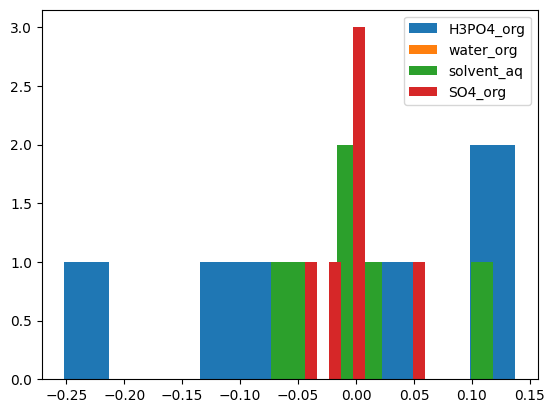

In [45]:
pred=predics2_01
predics1_y1=pred[:,0]
error1_y1=(predics1_y1-T2[:,0])/T2[:,0]*100
predics1_y2=pred[:,1]
error1_y2=(predics1_y2-T2[:,1])/T2[:,1]*100
predics1_y3=pred[:,2]
error1_y3=(predics1_y3-T2[:,2])/T2[:,2]*100
predics1_y4=pred[:,3]
error1_y4=(predics1_y4-T2[:,3])/T2[:,3]*100

plt.hist(error1_y1)
plt.hist(error1_y2)
plt.hist(error1_y3)
plt.hist(error1_y4)

plt.legend(['H3PO4_org','water_org','solvent_aq','SO4_org'])
plt.show()

In [46]:
fig = make_subplots(rows=1, cols=4, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.25, 0.25, 0.25, 0.25],
                     specs=[[{"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}]])

fig.add_trace(go.Scatter(x=T2[:,0] , y=predics1_y1, mode='markers', marker_size=4, name='predics H3PO4_org', marker_color='black' ), 1, 1)
fig.add_trace(go.Scatter(x=T2[:,1] , y=predics1_y2, mode='markers', marker_size=4, name='predics water_org', marker_color='black' ), 1, 2)
fig.add_trace(go.Scatter(x=T2[:,2] , y=predics1_y3, mode='markers', marker_size=4, name='predics solvent_aq', marker_color='black' ), 1, 3)
fig.add_trace(go.Scatter(x=T2[:,3] , y=predics1_y4, mode='markers', marker_size=4, name='predics SO4_org', marker_color='black' ), 1, 4)

fig.add_trace(go.Scatter(x=T2[:,0] , y=error1_y1, mode='markers', marker_size=4, name='error H3PO4_org', marker_color='orange' ), 1, 1, secondary_y=True,)
fig.add_trace(go.Scatter(x=T2[:,1] , y=error1_y2, mode='markers', marker_size=4, name='error water_org', marker_color='orange' ), 1, 2, secondary_y=True,)
fig.add_trace(go.Scatter(x=T2[:,2] , y=error1_y3, mode='markers', marker_size=4, name='error solvent_aq', marker_color='orange' ), 1, 3, secondary_y=True,)
fig.add_trace(go.Scatter(x=T2[:,3] , y=error1_y3, mode='markers', marker_size=4, name='error SO4_org', marker_color='orange' ), 1, 4, secondary_y=True,)

fig.update_layout(title='', autosize=True,
                  width=1550, height=250,
                  margin=dict(l=0, r=0, b=0, t=30))

fig.show()

In [47]:
data2

H3PO4_aq  SO4_aq  H3PO4_org  water_org  solvent_aq  SO4_org
0      4.15  0.1470     0.0733        9.6         2.5   0.0626
1     14.90  0.0806     0.3590        9.5         2.2   0.0852
2     28.60  0.0329     1.6800        9.3         1.9   0.0787
3     45.70  0.0106     8.3100        8.5         1.6   0.0664
4     48.20  0.0078    10.7000        8.5         1.3   0.0631
5     49.40  0.0058    12.2000        8.7         1.0   0.0641

#### mesh

In [48]:
x_mesh, y_mesh = np.linspace(0, 50, 51), np.linspace(0, 0.15, 51)
x_mesh, y_mesh = np.meshgrid(x_mesh, y_mesh)
x_mesh2 = x_mesh.flatten().reshape(51*51,1)
y_mesh2 = y_mesh.flatten().reshape(51*51,1)
mesh2_2=np.concatenate((x_mesh2, y_mesh2), axis=1)
# x_mesh[:5]

In [49]:
mesh_predics2_01=scaler_T2.inverse_transform(  bp2_01.run( scaler_X2.transform(mesh2_2) )  )

In [50]:
mesh_predics2_01

array([[-16.99129752,  12.4040406 ,   1.5227953 ,   0.09780696],
       [-16.4765317 ,  12.3188369 ,   1.52727516,   0.09718717],
       [-15.96176588,  12.23363321,   1.53175502,   0.09656737],
       ...,
       [  8.36672522,   8.54095758,   2.1772869 ,   0.0358565 ],
       [  9.15272068,   8.49071143,   2.12028386,   0.03400705],
       [  9.93871615,   8.44046529,   2.06328082,   0.03215759]])

In [51]:
fig_equil2_2 = make_subplots(rows=2, cols=2, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.5, 0.5], vertical_spacing=0.05,
                     specs=[[{"type": "scene"}, {"type": "scene"}],[{"type": "scene"}, {"type": "scene"}]])

fig_equil2_2.add_trace(go.Scatter3d(x=data2.H3PO4_aq, y=data2.SO4_aq, z=data2.H3PO4_org, mode='markers', name='H3PO4_org'), 1, 1)
fig_equil2_2.add_trace(go.Scatter3d(x=data2.H3PO4_aq, y=data2.SO4_aq, z=data2.water_org, mode='markers', name='water_org'), 1, 2)
fig_equil2_2.add_trace(go.Scatter3d(x=data2.H3PO4_aq, y=data2.SO4_aq, z=data2.solvent_aq, mode='markers', name='solvent_aq'), 2, 1)
fig_equil2_2.add_trace(go.Scatter3d(x=data2.H3PO4_aq, y=data2.SO4_aq, z=data2.SO4_org, mode='markers', name='SO4_org'), 2, 2)

fig_equil2_2.add_trace(go.Scatter3d(x=x_mesh2[:,0], y=y_mesh2[:,0], z=mesh_predics2_01[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible='legendonly'),1,1)
fig_equil2_2.add_trace(go.Scatter3d(x=x_mesh2[:,0], y=y_mesh2[:,0], z=mesh_predics2_01[:,1], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible='legendonly'),1,2)
fig_equil2_2.add_trace(go.Scatter3d(x=x_mesh2[:,0], y=y_mesh2[:,0], z=mesh_predics2_01[:,2], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible='legendonly'),2,1)
fig_equil2_2.add_trace(go.Scatter3d(x=x_mesh2[:,0], y=y_mesh2[:,0], z=mesh_predics2_01[:,3], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible='legendonly'),2,2)

fig_equil2_2.update_layout(title='', autosize=True,
                  width=800, height=800,
                  margin=dict(l=0, r=0, b=0, t=30),
                  )

fig_equil2_2.update_layout(
    scene1_zaxis_range=[0,15],
    scene2_zaxis_range=[8,10],
    scene3_zaxis_range=[0,3],
    scene4_zaxis_range=[.05,.1],
    )

fig_equil2_2.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=1.5, y=1.5, z=1.5))

fig_equil2_2.show()

### 4 together - 5 hidden

#### parameter searching

In [52]:
bp_iter=VectorBackProp(layers=[2,5,4], hidden_activation = 'prelu')
learning_rate = [0.005, 0.01, 0.05]
momentum_term = [0.8, 0.9, 0.95]
learning_rate_decay = [0, 0.5]
repeats = range(5)
rows=len(learning_rate) * len(momentum_term) * len(learning_rate_decay) * len(repeats)
print ('total runs:', rows)
output = np.zeros((rows,5))
i=0
weights_list = []
for lr in learning_rate:
    for mt in momentum_term:
        for lrd in learning_rate_decay:
            for rep in repeats:
                bp_iter.fit(X_sc2, T_sc2, epochs=1000, learning_rate = lr, momentum_term = mt, learning_rate_decay = lrd, repeat=False)
                relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
                output[i] = [lr, mt, lrd, bp_iter.loss_list[-1], relative_delta[-1]]
                weights_list.append(bp_iter.export_weights())
                print (i, end=' ')
                if i%25==0 and i>0:
                    print ('\n')
                i+=1


total runs: 90
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 

76 77 78 79 80 81 82 

/content/MLNN.py:93: RuntimeWarning:

overflow encountered in square

/content/MLNN.py:113: RuntimeWarning:

overflow encountered in matmul

/content/MLNN.py:127: RuntimeWarning:

overflow encountered in matmul

/content/MLNN.py:134: RuntimeWarning:

invalid value encountered in matmul

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning:

invalid value encountered in reduce

<ipython-input-52-8a49181a082d>:16: RuntimeWarning:

invalid value encountered in scalar divide



83 84 85 86 87 88 89 

In [53]:
output_table = pd.DataFrame(data=output, columns=['learning_rate', 'momentum_term', 'learning_rate_decay', 'final_loss', 'relative_delta'])
output_table.fillna(value = 1.1, inplace = True)
output_table.sort_values(by=['final_loss'])

learning_rate  momentum_term  learning_rate_decay  final_loss  \
41          0.010           0.90                  0.0    0.004227   
21          0.005           0.95                  0.0    0.006693   
60          0.050           0.80                  0.0    0.016477   
70          0.050           0.90                  0.0    0.016585   
84          0.050           0.95                  0.0    0.017178   
..            ...            ...                  ...         ...   
6           0.005           0.80                  0.5    1.572424   
16          0.005           0.90                  0.5    1.596860   
9           0.005           0.80                  0.5    2.918625   
8           0.005           0.80                  0.5    2.945967   
7           0.005           0.80                  0.5    3.233725   

    relative_delta  
41       -0.297703  
21       -0.218034  
60       -0.007204  
70       -0.007648  
84       -0.317486  
..             ...  
6        -0.014836  
16       -0.010353  
9        -0.015144  
8        -0.019320  
7        -0.013543  

[90 rows x 5 columns]

In [54]:
# weights_list[64]

In [55]:
fig = go.Figure(data=
    go.Parcoords(

        dimensions = list([
            dict(
                label = 'learning_rate', values = output_table['learning_rate']),
            dict(
                label = 'momentum_term', values = output_table['momentum_term']),
            dict(range = [0, 1],
                label = 'learning_rate_decay', values = output_table['learning_rate_decay']),
            dict(range = [0, 0.2],
                label = 'final_loss', values = output_table['final_loss']),
            dict(
                label = 'relative_delta', values = output_table['relative_delta']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

#### running best parameters

In [56]:
bp_iter=VectorBackProp(layers=[2,5,4], hidden_activation = 'prelu')
weights_lists2=[]
loss_lists2=[]
relative_delta_lists2=[]
n = 10
for i in range(n):
    bp_iter.fit(X_sc2, T_sc2, epochs=1500, learning_rate = 0.05, momentum_term = 0.9, learning_rate_decay = 0, repeat=False)
    relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
    weights_lists2.append(bp_iter.export_weights())
    loss_lists2.append(bp_iter.loss_list)
    relative_delta_lists2.append(relative_delta)

/content/MLNN.py:93: RuntimeWarning:

overflow encountered in square

/content/MLNN.py:113: RuntimeWarning:

overflow encountered in matmul

/content/MLNN.py:127: RuntimeWarning:

overflow encountered in matmul

/content/MLNN.py:134: RuntimeWarning:

invalid value encountered in matmul

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning:

invalid value encountered in reduce

<ipython-input-56-492ab6dbee7d>:8: RuntimeWarning:

invalid value encountered in scalar divide



In [57]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=loss_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[0,0.05], title='Loss')
fig2.show()

#### best_weights_for_now

In [58]:
best_weights_for_now4=weights_lists2[0] # 5 hidden
best_weights_for_now4

[[[-1.9443135963032243,
   0.25091189130720754,
   2.7808942892265276,
   -0.05036527101860953,
   -0.018362391002317565],
  [-1.0829507885303469,
   1.9222983898216253,
   -0.7837004332793418,
   0.03355477504050537,
   -0.06039360502748503]],
 [[0.9866717284465357,
   -1.99209502051972,
   -3.0511990843432533,
   -0.37535707649199035,
   -0.27691983939672404]],
 [[-0.84825248346871,
   1.1440397350641829,
   0.5509192077240503,
   1.1066228179382418],
  [-0.11044436797420373,
   0.29006136611546895,
   0.6137558688741905,
   -1.73161077252105],
  [1.587847116092749,
   1.768554436273502,
   -2.6379507237162376,
   0.0741648464915416],
  [0.2543589754148217,
   -0.036065543784773,
   -0.056086565615070555,
   -0.08837784790176398],
  [-0.2490829273253918,
   0.200974150599071,
   0.11183844580191275,
   -0.19383423309516212]],
 [[0.7411364219762508,
   -1.3692969340272751,
   -0.4600736873543026,
   -0.7444088806330313]]]

In [59]:
manual_best_weights_for_now4=[[[-0.49713918706342886,
   0.1950284001898634,
   0.3000286638538871,
   2.942836725200948,
   -1.777182367796712],
  [2.1234531580838945,
   -0.5308939551421104,
   1.5451518611127595,
   -0.43183539769698653,
   -1.353510483105784]],
 [[-5.943166311786588,
   0.5436660955058797,
   -1.505456576119919,
   -2.9099233142370085,
   0.63874921575053]],
 [[0.6631567120354075,
   1.7152225538132848,
   -1.926593325437448,
   0.2593021750619779],
  [0.1590583031187942,
   -0.3475279357013146,
   -0.8488900298997195,
   -0.9144956943161578],
  [-0.7480193778822165,
   1.0922520235074942,
   0.6924882000692089,
   -1.9518238819373117],
  [1.4121712190765998,
   1.8210598982444497,
   -2.656747328453359,
   0.026146767983708605],
  [-1.091064184783977,
   1.3878567618032225,
   0.2004093181868182,
   0.9479273709076199]],
 [[0.5932312645572166,
   -0.9965956124325036,
   0.5675174709474265,
   0.34346613214124766]]]

 # 5 relu
 # epochs=1500, learning_rate = 0.05, momentum_term = 0.9, learning_rate_decay = 0
 # loss = .0004

#### fitting best parameters

In [60]:
bp2_02=VectorBackProp(layers=[2,5,4], hidden_activation = 'prelu')

In [61]:
# bp2_02.import_weights(best_weights_for_now4)
bp2_02.import_weights(manual_best_weights_for_now4)
bp2_02.fit(X_sc2, T_sc2, epochs=5000, learning_rate = 0.1, momentum_term = 0.9, learning_rate_decay = 1, repeat=True)

In [62]:
fig2_3=go.Figure()
fig2_3.add_trace(go.Scatter(y=bp2_02.loss_list[20:], name=''))
print('Initial loss =', bp2_02.loss_list[0])
print('Final loss =', bp2_02.loss_list[-1])
# fig2_3.show()

Initial loss = 0.003938660937267711
Final loss = 0.0029222844626381043


#### prediction

In [63]:
predics2_02=scaler_T2.inverse_transform(bp2_02.run(X_sc2))
predics2_02

array([[ 0.07186016,  9.60019325,  2.50007771,  0.06260343],
       [ 0.35986341,  9.49952372,  2.19986901,  0.08517122],
       [ 1.67506092,  9.3016696 ,  1.90064512,  0.07880041],
       [ 8.34483912,  8.49066676,  1.59487439,  0.06586401],
       [10.64537953,  8.5148219 ,  1.30864071,  0.06394605],
       [12.22430494,  8.69324198,  0.99602245,  0.0637174 ]])

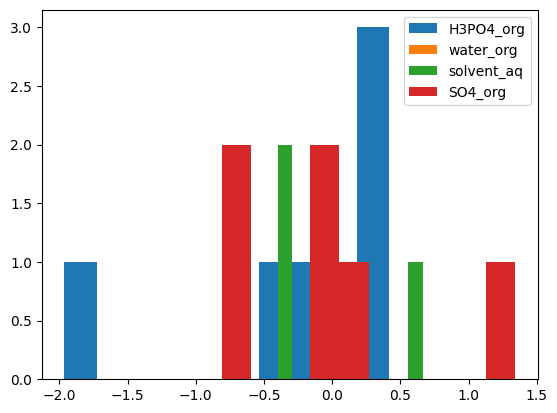

In [64]:
pred=predics2_02
predics1_y1=pred[:,0]
error1_y1=(predics1_y1-T2[:,0])/T2[:,0]*100
predics1_y2=pred[:,1]
error1_y2=(predics1_y2-T2[:,1])/T2[:,1]*100
predics1_y3=pred[:,2]
error1_y3=(predics1_y3-T2[:,2])/T2[:,2]*100
predics1_y4=pred[:,3]
error1_y4=(predics1_y4-T2[:,3])/T2[:,3]*100

plt.hist(error1_y1)
plt.hist(error1_y2)
plt.hist(error1_y3)
plt.hist(error1_y4)

plt.legend(['H3PO4_org','water_org','solvent_aq','SO4_org'])
plt.show()

In [65]:
fig = make_subplots(rows=1, cols=4, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.25, 0.25, 0.25, 0.25],
                     specs=[[{"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}]])

fig.add_trace(go.Scatter(x=T2[:,0] , y=predics1_y1, mode='markers', marker_size=4, name='predics H3PO4_org', marker_color='black' ), 1, 1)
fig.add_trace(go.Scatter(x=T2[:,1] , y=predics1_y2, mode='markers', marker_size=4, name='predics water_org', marker_color='black' ), 1, 2)
fig.add_trace(go.Scatter(x=T2[:,2] , y=predics1_y3, mode='markers', marker_size=4, name='predics solvent_aq', marker_color='black' ), 1, 3)
fig.add_trace(go.Scatter(x=T2[:,3] , y=predics1_y4, mode='markers', marker_size=4, name='predics SO4_org', marker_color='black' ), 1, 4)

fig.add_trace(go.Scatter(x=T2[:,0] , y=error1_y1, mode='markers', marker_size=4, name='error H3PO4_org', marker_color='orange' ), 1, 1, secondary_y=True,)
fig.add_trace(go.Scatter(x=T2[:,1] , y=error1_y2, mode='markers', marker_size=4, name='error water_org', marker_color='orange' ), 1, 2, secondary_y=True,)
fig.add_trace(go.Scatter(x=T2[:,2] , y=error1_y3, mode='markers', marker_size=4, name='error solvent_aq', marker_color='orange' ), 1, 3, secondary_y=True,)
fig.add_trace(go.Scatter(x=T2[:,3] , y=error1_y3, mode='markers', marker_size=4, name='error SO4_org', marker_color='orange' ), 1, 4, secondary_y=True,)

fig.update_layout(title='', autosize=True,
                  width=1550, height=250,
                  margin=dict(l=0, r=0, b=0, t=30))

fig.show()

In [66]:
data2

H3PO4_aq  SO4_aq  H3PO4_org  water_org  solvent_aq  SO4_org
0      4.15  0.1470     0.0733        9.6         2.5   0.0626
1     14.90  0.0806     0.3590        9.5         2.2   0.0852
2     28.60  0.0329     1.6800        9.3         1.9   0.0787
3     45.70  0.0106     8.3100        8.5         1.6   0.0664
4     48.20  0.0078    10.7000        8.5         1.3   0.0631
5     49.40  0.0058    12.2000        8.7         1.0   0.0641

#### mesh

In [67]:
x_mesh, y_mesh = np.linspace(0, 50, 51), np.linspace(0, 0.15, 51)
x_mesh, y_mesh = np.meshgrid(x_mesh, y_mesh)
x_mesh2 = x_mesh.flatten().reshape(51*51,1)
y_mesh2 = y_mesh.flatten().reshape(51*51,1)
mesh2_2=np.concatenate((x_mesh2, y_mesh2), axis=1)
# x_mesh[:5]

In [68]:
mesh_predics2_02=scaler_T2.inverse_transform(  bp2_02.run( scaler_X2.transform(mesh2_2) )  )

In [69]:
mesh_predics2_02

array([[-18.95883889,  11.72136432,   2.28440549,   0.10983304],
       [-18.39270372,  11.65418405,   2.26889551,   0.10890196],
       [-17.82656856,  11.58700377,   2.25338553,   0.10797088],
       ...,
       [  1.63832442,   9.48115456,   2.70013189,   0.04129478],
       [  1.57660418,   9.48978007,   2.70595791,   0.0410031 ],
       [  1.51488393,   9.49840557,   2.71178393,   0.04071141]])

In [70]:
fig_equil2_3 = make_subplots(rows=2, cols=2, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.5, 0.5], vertical_spacing=0.05,
                     specs=[[{"type": "scene"}, {"type": "scene"}],[{"type": "scene"}, {"type": "scene"}]])

fig_equil2_3.add_trace(go.Scatter3d(x=data2.H3PO4_aq, y=data2.SO4_aq, z=data2.H3PO4_org, mode='markers', name='H3PO4_org'), 1, 1)
fig_equil2_3.add_trace(go.Scatter3d(x=data2.H3PO4_aq, y=data2.SO4_aq, z=data2.water_org, mode='markers', name='water_org'), 1, 2)
fig_equil2_3.add_trace(go.Scatter3d(x=data2.H3PO4_aq, y=data2.SO4_aq, z=data2.solvent_aq, mode='markers', name='solvent_aq'), 2, 1)
fig_equil2_3.add_trace(go.Scatter3d(x=data2.H3PO4_aq, y=data2.SO4_aq, z=data2.SO4_org, mode='markers', name='SO4_org'), 2, 2)

fig_equil2_3.add_trace(go.Scatter3d(x=x_mesh2[:,0], y=y_mesh2[:,0], z=mesh_predics2_02[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible='legendonly'),1,1)
fig_equil2_3.add_trace(go.Scatter3d(x=x_mesh2[:,0], y=y_mesh2[:,0], z=mesh_predics2_02[:,1], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible='legendonly'),1,2)
fig_equil2_3.add_trace(go.Scatter3d(x=x_mesh2[:,0], y=y_mesh2[:,0], z=mesh_predics2_02[:,2], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible='legendonly'),2,1)
fig_equil2_3.add_trace(go.Scatter3d(x=x_mesh2[:,0], y=y_mesh2[:,0], z=mesh_predics2_02[:,3], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible='legendonly'),2,2)

fig_equil2_3.update_layout(title='', autosize=True,
                  width=800, height=800,
                  margin=dict(l=0, r=0, b=0, t=30),
                  )

fig_equil2_3.update_layout(
    scene1_zaxis_range=[0,15],
    scene2_zaxis_range=[8,10],
    scene3_zaxis_range=[0,3],
    scene4_zaxis_range=[.05,.1],
    )

fig_equil2_3.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=1.5, y=1.5, z=1.5))

fig_equil2_3.show()

### H3PO4_org

In [71]:
X2=np.array(data2)[:,[0,1]]
T2_1=np.array(data2)[:,[2]]

In [72]:
scaler_X2 = preprocessing.StandardScaler().fit(X2)
scaler_T2_1 = preprocessing.StandardScaler().fit(T2_1)

scaler_data2_1 = [scaler_X2.mean_, scaler_X2.scale_, scaler_T2_1.mean_, scaler_T2_1.scale_]
print('scaler X -- mean, stdev:  ',scaler_data2_1[0], scaler_data2_1[1])
print('scaler T -- mean, stdev:  ',scaler_data2_1[2], scaler_data2_1[3])

X_sc2 = scaler_X2.transform(X2)
T_sc2_1 = scaler_T2_1.transform(T2_1)
X_sc2[0:3]

scaler X -- mean, stdev:   [31.825    0.04745] [17.47521459  0.05145483]
scaler T -- mean, stdev:   [5.55371667] [5.00466684]


array([[-1.58367154,  1.93470675],
       [-0.96851457,  0.64425443],
       [-0.18454709, -0.28277231]])

In [73]:
bp2_1=VectorBackProp(layers=[2,2,1], hidden_activation = 'prelu')

In [74]:
bp2_1.fit(X_sc2, T_sc2_1, epochs=1000, learning_rate = 0.01, momentum_term = 0.95, learning_rate_decay = 0)
print('Initial loss =', bp2_1.loss_list[0])
print('Final loss =', bp2_1.loss_list[-1])

Initial loss = 0.9955583413525467
Final loss = 0.01617263312259695


In [75]:
bp2_1.export_weights()

[[[0.1615212731638362, 1.3132426254198164],
  [0.1193192834450897, -0.5891016204375351]],
 [[-0.496824465879761, 0.31350706712851506]],
 [[0.45652307370444095], [1.0432756818099647]],
 [[-1.064035067786029]]]

In [76]:
weights2_1=bp2_1.export_weights()

In [77]:
manual_weights2_1=[[[1.7891568738335732, -1.1785291564925502],
  [-0.504929133439221, -0.4385439629245994]],
 [[-1.2274800854986472, 1.060820499155897]],
 [[1.5766657992281017], [-0.4638647113832393]],
 [[-0.12921146069478243]]]

# 2 hidden prelu
# Final loss = 0.00023878868378339208

manual_weights2_12=[[[0.1735491429461148, 1.8140938189194906],
  [-0.6530409129171293, -0.6441814583921941]],
 [[0.7411897128053353, -1.2033881701371891]],
 [[0.3516552639162472], [1.6547118904069311]],
 [[-1.0860308848681413]]]

# 2 hidden prelu
# Final loss = 0.00014

In [78]:
# bp2_1.import_weights(weights2_1)
# bp2_1.import_weights(manual_weights2_1)
bp2_1.import_weights(manual_weights2_12)
predics2_1=scaler_T2_1.inverse_transform(bp2_1.run(X_sc2))

In [79]:
# predics2_1, T2_1

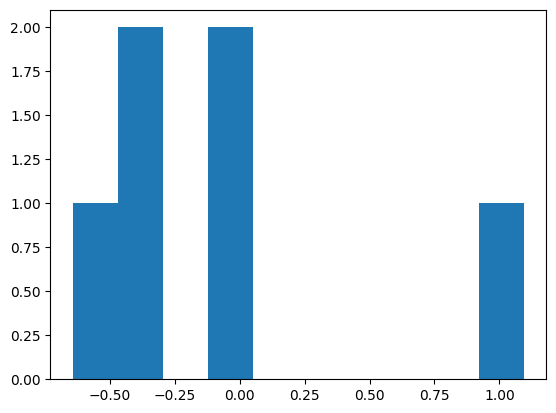

In [80]:
error2_1=(predics2_1[:,0]-T2_1[:,0])/T2_1[:,0]*100
plt.hist(error2_1)
plt.show()

In [81]:
mesh_predics2_1=scaler_T2_1.inverse_transform(  bp2_1.run( scaler_X2.transform(mesh2_2) )  )
# mesh_predics2_1

### water_org

In [82]:
X2=np.array(data2)[:,[0,1]]
T2_2=np.array(data2)[:,[3]]

In [83]:
scaler_X2 = preprocessing.StandardScaler().fit(X2)
scaler_T2_2 = preprocessing.StandardScaler().fit(T2_2)

scaler_data2_2 = [scaler_X2.mean_, scaler_X2.scale_, scaler_T2_2.mean_, scaler_T2_2.scale_]
print('scaler X -- mean, stdev:  ',scaler_data2_2[0], scaler_data2_2[1])
print('scaler T -- mean, stdev:  ',scaler_data2_2[2], scaler_data2_2[3])

X_sc2 = scaler_X2.transform(X2)
T_sc2_2 = scaler_T2_2.transform(T2_2)
X_sc2[0:3]

scaler X -- mean, stdev:   [31.825    0.04745] [17.47521459  0.05145483]
scaler T -- mean, stdev:   [9.01666667] [0.46338129]


array([[-1.58367154,  1.93470675],
       [-0.96851457,  0.64425443],
       [-0.18454709, -0.28277231]])

parameter searching

In [84]:
bp_iter=VectorBackProp(layers=[2,2,1], hidden_activation = 'prelu')
learning_rate = [0.005, 0.01, 0.05]
momentum_term = [0.8, 0.9, 0.95]
learning_rate_decay = [0, 0.5]
repeats = range(5)
rows=len(learning_rate) * len(momentum_term) * len(learning_rate_decay) * len(repeats)
print ('total runs:', rows)
output = np.zeros((rows,5))
i=0
weights_list = []
for lr in learning_rate:
    for mt in momentum_term:
        for lrd in learning_rate_decay:
            for rep in repeats:
                bp_iter.fit(X_sc2, T_sc2_2, epochs=1000, learning_rate = lr, momentum_term = mt, learning_rate_decay = lrd, repeat=False)
                relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
                output[i] = [lr, mt, lrd, bp_iter.loss_list[-1], relative_delta[-1]]
                weights_list.append(bp_iter.export_weights())
                print (i, end=' ')
                if i%25==0 and i>0:
                    print ('\n')
                i+=1


total runs: 90
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 

76 77 78 79 80 81 82 83 84 85 86 87 88 89 

In [85]:
output_table = pd.DataFrame(data=output, columns=['learning_rate', 'momentum_term', 'learning_rate_decay', 'final_loss', 'relative_delta'])
output_table.fillna(value = 1.1, inplace = True)
output_table.sort_values(by=['final_loss'])

learning_rate  momentum_term  learning_rate_decay  final_loss  \
51          0.010           0.95                  0.0    0.004102   
70          0.050           0.90                  0.0    0.008367   
0           0.005           0.80                  0.0    0.025924   
3           0.005           0.80                  0.0    0.025926   
31          0.010           0.80                  0.0    0.025943   
..            ...            ...                  ...         ...   
6           0.005           0.80                  0.5    0.939240   
7           0.005           0.80                  0.5    0.999794   
47          0.010           0.90                  0.5    0.999999   
35          0.010           0.80                  0.5    1.000029   
57          0.010           0.95                  0.5    1.000080   

    relative_delta  
51   -7.924011e-03  
70   -2.783093e-01  
0    -9.019074e-02  
3    -1.397013e-01  
31   -2.371245e-01  
..             ...  
6    -3.245073e-03  
7    -1.208381e-05  
47   -3.961464e-08  
35   -3.541984e-08  
57   -6.025140e-08  

[90 rows x 5 columns]

In [86]:
weights_list[60]

[[[-1.3600743452518318, -0.19773168393783208],
  [-0.5710132575350201, -0.19576890547944775]],
 [[1.1688650921620094, -0.11152406080787691]],
 [[1.1743943824720369], [-0.040833148015531014]],
 [[-1.3727131519812081]]]

In [87]:
fig = go.Figure(data=
    go.Parcoords(

        dimensions = list([
            dict(
                label = 'learning_rate', values = output_table['learning_rate']),
            dict(
                label = 'momentum_term', values = output_table['momentum_term']),
            dict(range = [0, 1],
                label = 'learning_rate_decay', values = output_table['learning_rate_decay']),
            dict(range = [0, 0.2],
                label = 'final_loss', values = output_table['final_loss']),
            dict(
                label = 'relative_delta', values = output_table['relative_delta']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

In [88]:
bp2_2=VectorBackProp(layers=[2,2,1], hidden_activation = 'prelu')

In [89]:
bp2_2.fit(X_sc2, T_sc2_2, epochs=1000, learning_rate = 0.005, momentum_term = 0.95, learning_rate_decay = 0)
print('Initial loss =', bp2_2.loss_list[0])
print('Final loss =', bp2_2.loss_list[-1])

Initial loss = 1.004020830897225
Final loss = 0.04862731123128864


In [90]:
bp2_2.export_weights()

[[[-0.2000154045974159, -1.7407594284415455],
  [-0.18740938239861177, -0.7308370520970879]],
 [[-0.09632483417834703, 1.5471235947813653]],
 [[-0.018504672844207166], [0.9175646398012537]],
 [[-1.4195876847948545]]]

In [91]:
manual_weights2_2=[[[-2.3688210444515527, 2.098731394118159],
  [-1.1028505358197696, -4.289031245616676]],
 [[1.0951314669487642, -8.766706105459567]],
 [[0.7892953147766246], [-1.3482461942845092]],
 [[-0.9630528809172003]]]

# 2 hidden prelu
# Final loss = 0.026

manual_weights2_22=[[[-1.356083366626272, 2.1006456906712234],
  [-0.6309805208401018, -0.5374527149916659]],
 [[1.0515374304634164, -2.3182953246087115]],
 [[1.4841383017903245], [3.153523627853289]],
 [[-1.7074908699001965]]]

# 2 hidden prelu
# Final loss = 0.007

In [92]:
bp2_2.import_weights(manual_weights2_22)
predics2_2=scaler_T2_2.inverse_transform(bp2_2.run(X_sc2))

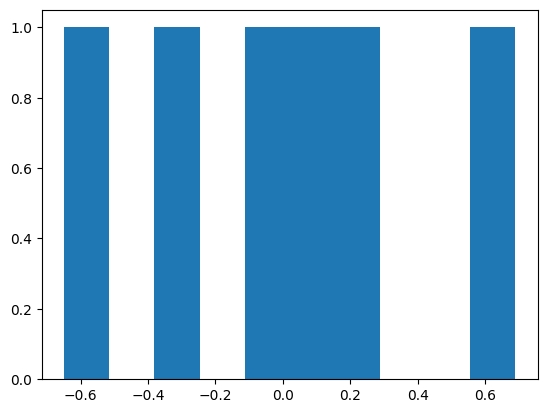

In [93]:
error2_2=(predics2_2[:,0]-T2_2[:,0])/T2_2[:,0]*100
plt.hist(error2_2)
plt.show()

In [94]:
mesh_predics2_2=scaler_T2_2.inverse_transform(  bp2_2.run( scaler_X2.transform(mesh2_2) )  )
# mesh_predics2_2

### solvent_aq

In [95]:
X2=np.array(data2)[:,[0,1]]
T2_3=np.array(data2)[:,[4]]

In [96]:
scaler_X2 = preprocessing.StandardScaler().fit(X2)
scaler_T2_3 = preprocessing.StandardScaler().fit(T2_3)

scaler_data2_3 = [scaler_X2.mean_, scaler_X2.scale_, scaler_T2_3.mean_, scaler_T2_3.scale_]
print('scaler X -- mean, stdev:  ',scaler_data2_3[0], scaler_data2_3[1])
print('scaler T -- mean, stdev:  ',scaler_data2_3[2], scaler_data2_3[3])

X_sc2 = scaler_X2.transform(X2)
T_sc2_3 = scaler_T2_3.transform(T2_3)
X_sc2[0:3]

scaler X -- mean, stdev:   [31.825    0.04745] [17.47521459  0.05145483]
scaler T -- mean, stdev:   [1.75] [0.51234754]


array([[-1.58367154,  1.93470675],
       [-0.96851457,  0.64425443],
       [-0.18454709, -0.28277231]])

parameter searching

In [97]:
bp_iter=VectorBackProp(layers=[2,2,1], hidden_activation = 'prelu')
learning_rate = [0.005, 0.01, 0.05]
momentum_term = [0.8, 0.9, 0.95]
learning_rate_decay = [0, 0.5]
repeats = range(5)
rows=len(learning_rate) * len(momentum_term) * len(learning_rate_decay) * len(repeats)
print ('total runs:', rows)
output = np.zeros((rows,5))
i=0
weights_list = []
for lr in learning_rate:
    for mt in momentum_term:
        for lrd in learning_rate_decay:
            for rep in repeats:
                bp_iter.fit(X_sc2, T_sc2_3, epochs=1000, learning_rate = lr, momentum_term = mt, learning_rate_decay = lrd, repeat=False)
                relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
                output[i] = [lr, mt, lrd, bp_iter.loss_list[-1], relative_delta[-1]]
                weights_list.append(bp_iter.export_weights())
                print (i, end=' ')
                if i%25==0 and i>0:
                    print ('\n')
                i+=1


total runs: 90
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 

76 77 78 79 80 81 82 83 84 85 86 87 88 89 

In [98]:
output_table = pd.DataFrame(data=output, columns=['learning_rate', 'momentum_term', 'learning_rate_decay', 'final_loss', 'relative_delta'])
output_table.fillna(value = 1.1, inplace = True)
output_table.sort_values(by=['final_loss'])

learning_rate  momentum_term  learning_rate_decay  final_loss  \
80          0.050           0.95                  0.0    0.000002   
74          0.050           0.90                  0.0    0.000002   
21          0.005           0.95                  0.0    0.001193   
83          0.050           0.95                  0.0    0.002101   
71          0.050           0.90                  0.0    0.003148   
..            ...            ...                  ...         ...   
7           0.005           0.80                  0.5    0.928411   
17          0.005           0.90                  0.5    0.997181   
48          0.010           0.90                  0.5    1.000000   
37          0.010           0.80                  0.5    1.000022   
46          0.010           0.90                  0.5    1.000077   

    relative_delta  
80   -3.145685e-12  
74   -6.582090e-08  
21   -4.081454e-01  
83   -5.686822e-02  
71   -2.847863e-02  
..             ...  
7    -2.924681e-03  
17   -3.029468e-04  
48   -1.632405e-09  
37   -8.304727e-09  
46   -5.690068e-08  

[90 rows x 5 columns]

In [99]:
weights_list[70]

[[[0.011120185342330242, 0.8329433315467553],
  [0.01131857474394253, -0.9945163647138812]],
 [[-0.15112948872379572, 0.7249282935860963]],
 [[0.02061785561722904], [-0.9249989838585027]],
 [[1.1696825685439014]]]

In [100]:
fig = go.Figure(data=
    go.Parcoords(

        dimensions = list([
            dict(
                label = 'learning_rate', values = output_table['learning_rate']),
            dict(
                label = 'momentum_term', values = output_table['momentum_term']),
            dict(range = [0, 1],
                label = 'learning_rate_decay', values = output_table['learning_rate_decay']),
            dict(range = [0, 0.2],
                label = 'final_loss', values = output_table['final_loss']),
            dict(
                label = 'relative_delta', values = output_table['relative_delta']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

In [101]:
bp2_3=VectorBackProp(layers=[2,2,1], hidden_activation = 'prelu')

In [102]:
bp2_3.fit(X_sc2, T_sc2_3, epochs=1000, learning_rate = 0.005, momentum_term = 0.95, learning_rate_decay = 0)
print('Initial loss =', bp2_3.loss_list[0])
print('Final loss =', bp2_3.loss_list[-1])

Initial loss = 1.009710676062719
Final loss = 0.9999925660371437


In [103]:
bp2_3.export_weights()

[[[-0.014606843145771603, 0.06261616266705854],
  [-0.09642923285602924, -0.03371725142149241]],
 [[-0.3168834934634343, -0.2078069029041186]],
 [[-0.0228231767195668], [-0.022824628733256098]],
 [[-1.1933666495218791e-05]]]

In [104]:
manual_weights2_3=[[[-1.0434539247186463, -0.840891516715229],
  [-0.22875054162539293, -0.12682741253900376]],
 [[1.1115656735349122, 0.7810694575866067]],
 [[0.6969716415327804], [0.5332714811363267]],
 [[-1.191251818678171]]]

# 2 hidden prelu
# Final loss = 0.077

manual_weights2_32=[[[2.0994823528593702, -1.2293957752203057],
  [-0.6972915446623457, 0.5216771334283966]],
 [[-2.3459563115354527, 1.775004898861346]],
 [[-3.1726827033207408], [0.4025651395234753]],
 [[-0.4638947231253712]]]

# 2 hidden prelu
# Final loss = 0

In [105]:
bp2_3.import_weights(manual_weights2_32)
predics2_3=scaler_T2_3.inverse_transform(bp2_3.run(X_sc2))

In [106]:
predics2_3[:,0]

array([2.49957267, 2.2011776 , 1.89891732, 1.60033243, 1.29999965,
       1.00000033])

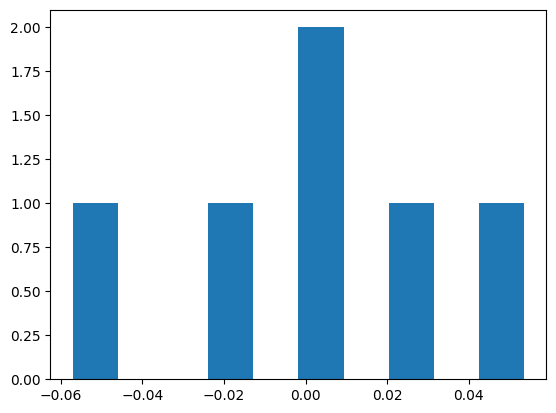

In [107]:
error2_3=(predics2_3[:,0]-T2_3[:,0])/T2_3[:,0]*100
plt.hist(error2_3)
plt.show()

In [108]:
mesh_predics2_3=scaler_T2_3.inverse_transform(  bp2_3.run( scaler_X2.transform(mesh2_2) )  )
# mesh_predics2_3

### SO4_org

In [109]:
X2=np.array(data2)[:,[0,1]]
T2_4=np.array(data2)[:,[5]]

In [110]:
scaler_X2 = preprocessing.StandardScaler().fit(X2)
scaler_T2_4 = preprocessing.StandardScaler().fit(T2_4)

scaler_data2_4 = [scaler_X2.mean_, scaler_X2.scale_, scaler_T2_4.mean_, scaler_T2_4.scale_]
print('scaler X -- mean, stdev:  ',scaler_data2_4[0], scaler_data2_4[1])
print('scaler T -- mean, stdev:  ',scaler_data2_4[2], scaler_data2_4[3])

X_sc2 = scaler_X2.transform(X2)
T_sc2_4 = scaler_T2_4.transform(T2_4)
X_sc2[0:3]

scaler X -- mean, stdev:   [31.825    0.04745] [17.47521459  0.05145483]
scaler T -- mean, stdev:   [0.07001667] [0.00872609]


array([[-1.58367154,  1.93470675],
       [-0.96851457,  0.64425443],
       [-0.18454709, -0.28277231]])

parameter searching

In [111]:
bp_iter=VectorBackProp(layers=[2,2,1], hidden_activation = 'prelu')
learning_rate = [0.005, 0.01, 0.05]
momentum_term = [0.9, 0.95, 0.98]
learning_rate_decay = [0, 0.5]
repeats = range(10)
rows=len(learning_rate) * len(momentum_term) * len(learning_rate_decay) * len(repeats)
print ('total runs:', rows)
output = np.zeros((rows,5))
i=0
weights_list = []
for lr in learning_rate:
    for mt in momentum_term:
        for lrd in learning_rate_decay:
            for rep in repeats:
                bp_iter.fit(X_sc2, T_sc2_4, epochs=1000, learning_rate = lr, momentum_term = mt, learning_rate_decay = lrd, repeat=False)
                relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
                output[i] = [lr, mt, lrd, bp_iter.loss_list[-1], relative_delta[-1]]
                weights_list.append(bp_iter.export_weights())
                print (i, end=' ')
                if i%25==0 and i>0:
                    print ('\n')
                i+=1


total runs: 180
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 

76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 

126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 

151 152 153 154 155 156 157 158 159 160 161 162 

/content/MLNN.py:73: RuntimeWarning:

overflow encountered in matmul

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning:

invalid value encountered in reduce

/content/MLNN.py:134: RuntimeWarning:

invalid value encountered in matmul

<ipython-input-111-6c9d1525e5ca>:16: RuntimeWarning:

invalid value encountered in scalar divide

/content/MLNN.py:93: RuntimeWarning:

overflow encountered in square

/content/MLNN.py:113: RuntimeWarning:

invalid value encountered in matmul



163 164 

<ipython-input-111-6c9d1525e5ca>:16: RuntimeWarning:

invalid value encountered in scalar subtract



165 166 167 168 169 170 171 172 173 174 175 

176 177 178 179 

In [112]:
output_table = pd.DataFrame(data=output, columns=['learning_rate', 'momentum_term', 'learning_rate_decay', 'final_loss', 'relative_delta'])
output_table.fillna(value = 1.1, inplace = True)
output_table.sort_values(by=['final_loss'])

learning_rate  momentum_term  learning_rate_decay  final_loss  \
127          0.050           0.90                  0.0    0.000916   
2            0.005           0.90                  0.0    0.002150   
5            0.005           0.90                  0.0    0.002157   
4            0.005           0.90                  0.0    0.002179   
26           0.005           0.95                  0.0    0.002198   
..             ...            ...                  ...         ...   
168          0.050           0.98                  0.0    1.100000   
165          0.050           0.98                  0.0    1.100000   
164          0.050           0.98                  0.0    1.100000   
162          0.050           0.98                  0.0    1.100000   
142          0.050           0.95                  0.0   14.342554   

     relative_delta  
127       -0.008524  
2         -0.315210  
5         -0.014681  
4          1.128829  
26        -0.195802  
..              ...  
168        1.100000  
165        1.100000  
164        1.100000  
162        1.100000  
142     -219.995174  

[180 rows x 5 columns]

In [113]:
weights_list[108]

[[[-0.13392531294097842, 2.902455752532969],
  [2.6683110472768723, -1.809353829556517]],
 [[-3.499714680448726, 1.8908838430343546]],
 [[-1.380976546424878], [-0.400537012928424]],
 [[1.73661622334241]]]

In [114]:
weights2_4=weights_list[108]

In [115]:
fig = go.Figure(data=
    go.Parcoords(

        dimensions = list([
            dict(
                label = 'learning_rate', values = output_table['learning_rate']),
            dict(
                label = 'momentum_term', values = output_table['momentum_term']),
            dict(range = [0, 1],
                label = 'learning_rate_decay', values = output_table['learning_rate_decay']),
            dict(range = [0, 0.2],
                label = 'final_loss', values = output_table['final_loss']),
            dict(
                label = 'relative_delta', values = output_table['relative_delta']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

running best parameters

In [116]:
bp_iter=VectorBackProp(layers=[2,2,1], hidden_activation = 'prelu')
weights_lists2=[]
loss_lists2=[]
relative_delta_lists2=[]
n = 30
for i in range(n):
    bp_iter.fit(X_sc2, T_sc2_4, epochs=3000, learning_rate = 0.05, momentum_term = 0.98, learning_rate_decay = 0.3, repeat=False)
    relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
    weights_lists2.append(bp_iter.export_weights())
    loss_lists2.append(bp_iter.loss_list)
    relative_delta_lists2.append(relative_delta)

In [117]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=loss_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[0,0.05], title='Loss')
fig2.show()

In [118]:
best_weights_for_now2_4=weights_lists2[13]
best_weights_for_now2_4

[[[-1.0482637197990774, 1.4375237612442988],
  [-2.5329158546855384, -3.389901435256409]],
 [[4.8856994071463005, 4.051000304442717]],
 [[1.0756192656994452], [-0.543930106147466]],
 [[-2.619014091175736]]]

In [119]:
bp2_4=VectorBackProp(layers=[2,2,1], hidden_activation = 'prelu')

In [120]:
# bp2_4.export_weights()

In [121]:
manual_weights2_4=[[[-0.16700158966413353, 1.1770332498659186],
  [1.4526084685823955, -0.9137197260973858]],
 [[-0.7468444598517179, 1.2452474051184519]],
 [[-1.3107172968906877], [-0.9375882900282885]],
 [[2.199196282499367]]]

# 2 hidden prelu
# Final loss = 0.1

manual_weights2_42=[[[-0.03998713454920765, -1.296313464466576],
  [1.3133609043926477, -0.5524389024009899]],
 [[-0.8849418689452931, 0.7889879563287986]],
 [[-1.576332174028801], [1.4492604070808766]],
 [[-0.7102506948766614]]]

# 2 hidden prelu
# Final loss = 0.002

manual_weights2_43=[[[-2.7308241499437758, 1.8373933992350313],
  [-2.021898044039464, -0.8845457922101067]],
 [[1.0694417308325381, 0.08920200363835196]],
 [[2.7835653102552724], [1.6175935763910405]],
 [[-4.969235753353272]]]
# 2 hidden prelu
# Final loss = 0.0008

In [122]:
bp2_4.import_weights(manual_weights2_43)
# bp2_4.import_weights(best_weights_for_now2_4)
# bp2_4.import_weights(weights2_4)
predics2_4=scaler_T2_4.inverse_transform(bp2_4.run(X_sc2))

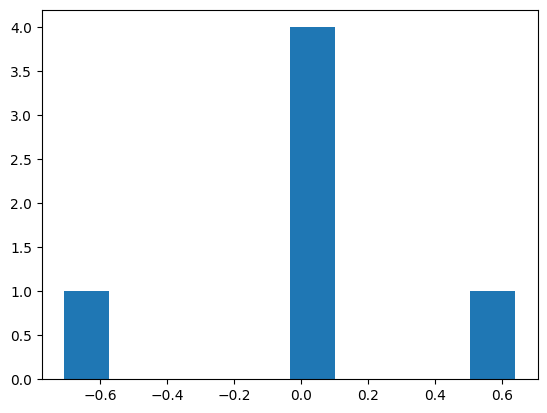

In [123]:
error2_4=(predics2_4[:,0]-T2_4[:,0])/T2_4[:,0]*100
plt.hist(error2_4)
plt.show()

In [124]:
mesh_predics2_4=scaler_T2_4.inverse_transform(  bp2_4.run( scaler_X2.transform(mesh2_2) )  )
# mesh_predics2_4

## Vizualization

In [125]:
fig_equil2_err = make_subplots(rows=1, cols=4, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.25, 0.25, 0.25, 0.25],
                     specs=[[{"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}]])

fig_equil2_err.add_trace(go.Scatter(x=T2[:,0] , y=predics2_1[:,0], mode='markers', marker_size=4, name='predics H3PO4_org', marker_color='black' ), 1, 1)
fig_equil2_err.add_trace(go.Scatter(x=T2[:,1] , y=predics2_2[:,0], mode='markers', marker_size=4, name='predics water_org', marker_color='black' ), 1, 2)
fig_equil2_err.add_trace(go.Scatter(x=T2[:,2] , y=predics2_3[:,0], mode='markers', marker_size=4, name='predics solvent_aq', marker_color='black' ), 1, 3)
fig_equil2_err.add_trace(go.Scatter(x=T2[:,3] , y=predics2_4[:,0], mode='markers', marker_size=4, name='predics SO4_org', marker_color='black' ), 1, 4)

fig_equil2_err.add_trace(go.Scatter(x=T2[:,0] , y=error2_1, mode='markers', marker_size=4, name='error H3PO4_org', marker_color='orange' ), 1, 1, secondary_y=True,)
fig_equil2_err.add_trace(go.Scatter(x=T2[:,1] , y=error2_2, mode='markers', marker_size=4, name='error water_org', marker_color='orange' ), 1, 2, secondary_y=True,)
fig_equil2_err.add_trace(go.Scatter(x=T2[:,2] , y=error2_3, mode='markers', marker_size=4, name='error solvent_aq', marker_color='orange' ), 1, 3, secondary_y=True,)
fig_equil2_err.add_trace(go.Scatter(x=T2[:,3] , y=error2_4, mode='markers', marker_size=4, name='error SO4_org', marker_color='orange' ), 1, 4, secondary_y=True,)

fig_equil2_err.update_layout(title='', autosize=True,
                  width=1550, height=250,
                  margin=dict(l=0, r=0, b=0, t=30))

fig_equil2_err.show()

In [126]:
fig_equil2 = make_subplots(rows=2, cols=2, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.5, 0.5], vertical_spacing=0.05,
                     specs=[[{"type": "scene"}, {"type": "scene"}],[{"type": "scene"}, {"type": "scene"}]])

fig_equil2.add_trace(go.Scatter3d(x=data2.H3PO4_aq, y=data2.SO4_aq, z=data2.H3PO4_org, mode='markers', name='H3PO4_org'), 1, 1)
fig_equil2.add_trace(go.Scatter3d(x=data2.H3PO4_aq, y=data2.SO4_aq, z=data2.water_org, mode='markers', name='water_org'), 1, 2)
fig_equil2.add_trace(go.Scatter3d(x=data2.H3PO4_aq, y=data2.SO4_aq, z=data2.solvent_aq, mode='markers', name='solvent_aq'), 2, 1)
fig_equil2.add_trace(go.Scatter3d(x=data2.H3PO4_aq, y=data2.SO4_aq, z=data2.SO4_org, mode='markers', name='SO4_org'), 2, 2)

fig_equil2.add_trace(go.Scatter3d(x=x_mesh2[:,0], y=y_mesh2[:,0], z=mesh_predics2_1[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible='legendonly'),1,1)
fig_equil2.add_trace(go.Scatter3d(x=x_mesh2[:,0], y=y_mesh2[:,0], z=mesh_predics2_2[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible='legendonly'),1,2)
fig_equil2.add_trace(go.Scatter3d(x=x_mesh2[:,0], y=y_mesh2[:,0], z=mesh_predics2_3[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible='legendonly'),2,1)
fig_equil2.add_trace(go.Scatter3d(x=x_mesh2[:,0], y=y_mesh2[:,0], z=mesh_predics2_4[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible='legendonly'),2,2)

fig_equil2.update_layout(title='', autosize=True,
                  width=800, height=800,
                  margin=dict(l=0, r=0, b=0, t=30),
                  )

fig_equil2.update_layout(
    scene1_zaxis_range=[0,15],
    scene2_zaxis_range=[8,10],
    scene3_zaxis_range=[0,3],
    scene4_zaxis_range=[0,.1],
    )

fig_equil2.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=-1.5, y=-1.5, z=1.5))

fig_equil2.show()

In [127]:
data2

H3PO4_aq  SO4_aq  H3PO4_org  water_org  solvent_aq  SO4_org
0      4.15  0.1470     0.0733        9.6         2.5   0.0626
1     14.90  0.0806     0.3590        9.5         2.2   0.0852
2     28.60  0.0329     1.6800        9.3         1.9   0.0787
3     45.70  0.0106     8.3100        8.5         1.6   0.0664
4     48.20  0.0078    10.7000        8.5         1.3   0.0631
5     49.40  0.0058    12.2000        8.7         1.0   0.0641

## output

In [128]:
print('scaler X -- mean, stdev:  ',scaler_data2[0], scaler_data2[1])
print('scaler T -- mean, stdev:  ',scaler_data2[2], scaler_data2[3])

scaler X -- mean, stdev:   [31.825    0.04745] [17.47521459  0.05145483]
scaler T -- mean, stdev:   [5.55371667 9.01666667 1.75       0.07001667] [5.00466684 0.46338129 0.51234754 0.00872609]


In [129]:
# H3PO4_org
bp2_1.print_weights()

Layers (input, hidden, output):  [2, 2, 1] prelu linear
Hidden layer weights:  [[0.1735491429461148, 1.8140938189194906], [-0.6530409129171293, -0.6441814583921941]]
Hidden layer biases:  [[0.7411897128053353, -1.2033881701371891]]
Outlet layer weights:  [[0.3516552639162472], [1.6547118904069311]]
Outlet layer biases:  [[-1.0860308848681413]]


In [130]:
bp2_1.export_weights()

[[[0.1735491429461148, 1.8140938189194906],
  [-0.6530409129171293, -0.6441814583921941]],
 [[0.7411897128053353, -1.2033881701371891]],
 [[0.3516552639162472], [1.6547118904069311]],
 [[-1.0860308848681413]]]

In [131]:
print('scaler T -- mean, stdev:  ',scaler_data2_1[2], scaler_data2_1[3])

scaler T -- mean, stdev:   [5.55371667] [5.00466684]


In [132]:
# water_org
bp2_2.print_weights()

Layers (input, hidden, output):  [2, 2, 1] prelu linear
Hidden layer weights:  [[-1.356083366626272, 2.1006456906712234], [-0.6309805208401018, -0.5374527149916659]]
Hidden layer biases:  [[1.0515374304634164, -2.3182953246087115]]
Outlet layer weights:  [[1.4841383017903245], [3.153523627853289]]
Outlet layer biases:  [[-1.7074908699001965]]


In [133]:
bp2_2.export_weights()

[[[-1.356083366626272, 2.1006456906712234],
  [-0.6309805208401018, -0.5374527149916659]],
 [[1.0515374304634164, -2.3182953246087115]],
 [[1.4841383017903245], [3.153523627853289]],
 [[-1.7074908699001965]]]

In [134]:
# solvent_aq
bp2_3.print_weights()

Layers (input, hidden, output):  [2, 2, 1] prelu linear
Hidden layer weights:  [[2.0994823528593702, -1.2293957752203057], [-0.6972915446623457, 0.5216771334283966]]
Hidden layer biases:  [[-2.3459563115354527, 1.775004898861346]]
Outlet layer weights:  [[-3.1726827033207408], [0.4025651395234753]]
Outlet layer biases:  [[-0.4638947231253712]]


In [135]:
bp2_3.export_weights()

[[[2.0994823528593702, -1.2293957752203057],
  [-0.6972915446623457, 0.5216771334283966]],
 [[-2.3459563115354527, 1.775004898861346]],
 [[-3.1726827033207408], [0.4025651395234753]],
 [[-0.4638947231253712]]]

In [136]:
# SO4_org
bp2_4.print_weights()

Layers (input, hidden, output):  [2, 2, 1] prelu linear
Hidden layer weights:  [[-2.7308241499437758, 1.8373933992350313], [-2.021898044039464, -0.8845457922101067]]
Hidden layer biases:  [[1.0694417308325381, 0.08920200363835196]]
Outlet layer weights:  [[2.7835653102552724], [1.6175935763910405]]
Outlet layer biases:  [[-4.969235753353272]]


In [137]:
bp2_4.export_weights()

[[[-2.7308241499437758, 1.8373933992350313],
  [-2.021898044039464, -0.8845457922101067]],
 [[1.0694417308325381, 0.08920200363835196]],
 [[2.7835653102552724], [1.6175935763910405]],
 [[-4.969235753353272]]]

# 3 - EQUIL_rotem_washing3
ניסויי הפרדה עם ממס מטוהר

In [138]:
# נתוני פרופיל
data=CopyPasteToArray('''
H3PO4_aq	SO4_aq	H3PO4_org	water_org	solvent_aq	SO4_org
4.15	0.1470	0.073	9.6	2.5	0.0626
14.9	0.0806	0.36	9.5	2.2	0.0852
28.6	0.0329	1.68	9.3	1.9	0.0787
45.7	0.0106	8.31	8.5	1.6	0.0664
48.2	0.0078	10.7	8.5	1.3	0.0631
49.4	0.0058	12.2	8.7	1.0	0.0641
''')
# data
# data2=pd.DataFrame(data, columns=['H3PO4_aq',	'SO4_aq',	'H3PO4_org',	'water_org',	'solvent_aq',	'SO4_org'])
data_profile=pd.DataFrame(data[1:], columns=data[0])
data_profile_names=CopyPasteToArray('''
571	573	575	579	581	5150
''')
# data_profile

In [139]:
# נתוני ניסויי הפרדה
data=CopyPasteToArray('''
H3PO4_aq	SO4_aq	H3PO4_org	water_org	solvent_aq	SO4_org	water_org-original
0.011	0.0932	0.072	8.69	1.70	0.0186	12.09
10.325	0.0017	0.229	10.66	1.52	0.02	10.66
10.380	0.0990	0.269	8.31	1.50	0.0208	10.41
19.821	0.0031	0.635	11.3	1.34	0.01884	11.3
19.710	0.0928	0.773	10.36	1.32	0.0195	12.34
28.710	0.0057	1.435	11.96	1.28	0.01978	11.96
27.882	0.0858	1.325	9.7	1.34	0.0222	11.1
35.611	0.0071	2.871	11.94	1.28	0.036	11.94
35.887	0.0846	2.981	12.02	1.24	0.0374	12.6
43.065	0.0082	5.328	12.12	1.28	0.057	12.12
43.065	0.0802	5.604	10.38	1.06	0.0608	11.7
49.966	0.0074	8.723	12.28	1.28	0.0872	12.28
0.017	0.1540	0.042	11.48	1.46	0.0164	13.28
4.831	0.0020	0.146	12.7	1.78	0.01302	12.6
4.941	0.1078	0.173	12.06	1.66	0.0139	11.84
19.600	0.0033	0.828	11.84	1.38	0.01688	11.42
19.766	0.1120	0.856	12.46	1.38	0.01832	11.2
''')
# data
# data2=pd.DataFrame(data, columns=['H3PO4_aq',	'SO4_aq',	'H3PO4_org',	'water_org',	'solvent_aq',	'SO4_org'])
data3=pd.DataFrame(data[1:], columns=data[0])
data3_names=CopyPasteToArray('''
wp12	wp21	wp22	wp31	wp32	wp41	wp42	wp51	wp52	wp61	wp62	wp71	wp13	ww11	ww12	ww21	ww22
''')
data3

H3PO4_aq  SO4_aq  H3PO4_org  water_org  solvent_aq  SO4_org  \
0      0.011  0.0932      0.072       8.69        1.70  0.01860   
1     10.325  0.0017      0.229      10.66        1.52  0.02000   
2     10.380  0.0990      0.269       8.31        1.50  0.02080   
3     19.821  0.0031      0.635      11.30        1.34  0.01884   
4     19.710  0.0928      0.773      10.36        1.32  0.01950   
5     28.710  0.0057      1.435      11.96        1.28  0.01978   
6     27.882  0.0858      1.325       9.70        1.34  0.02220   
7     35.611  0.0071      2.871      11.94        1.28  0.03600   
8     35.887  0.0846      2.981      12.02        1.24  0.03740   
9     43.065  0.0082      5.328      12.12        1.28  0.05700   
10    43.065  0.0802      5.604      10.38        1.06  0.06080   
11    49.966  0.0074      8.723      12.28        1.28  0.08720   
12     0.017  0.1540      0.042      11.48        1.46  0.01640   
13     4.831  0.0020      0.146      12.70        1.78  0.01302   
14     4.941  0.1078      0.173      12.06        1.66  0.01390   
15    19.600  0.0033      0.828      11.84        1.38  0.01688   
16    19.766  0.1120      0.856      12.46        1.38  0.01832   

    water_org-original  
0                12.09  
1                10.66  
2                10.41  
3                11.30  
4                12.34  
5                11.96  
6                11.10  
7                11.94  
8                12.60  
9                12.12  
10               11.70  
11               12.28  
12               13.28  
13               12.60  
14               11.84  
15               11.42  
16               11.20

In [140]:
fig_equil3 = make_subplots(rows=2, cols=2, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.5, 0.5], vertical_spacing=0.05,
                     specs=[[{"type": "scene"}, {"type": "scene"}],[{"type": "scene"}, {"type": "scene"}]])
plot_data=data3[:13].copy()
text_data=data3_names[0][:13]
fig_equil3.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.H3PO4_org, marker_color='blue', marker_symbol='circle', mode='markers', name='H3PO4_org-purified', text=text_data), 1, 1)
fig_equil3.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.water_org, marker_color='blue', marker_symbol='circle', mode='markers', name='water_org-purified', text=text_data), 1, 2)
fig_equil3.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.solvent_aq, marker_color='blue', marker_symbol='circle', mode='markers', name='solvent_aq-purified', text=text_data), 2, 1)
fig_equil3.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.SO4_org, marker_color='blue', marker_symbol='circle', mode='markers', name='SO4_org-purified', text=text_data), 2, 2)

plot_data=data3[13:].copy()
text_data=data3_names[0][13:]
fig_equil3.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.H3PO4_org, marker={'color':'blue', 'symbol':'diamond', 'size':6}, mode='markers', name='H3PO4_org-washed', text=text_data), 1, 1)
fig_equil3.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.water_org, marker={'color':'blue', 'symbol':'diamond', 'size':6}, mode='markers', name='water_org-washed', text=text_data), 1, 2)
fig_equil3.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.solvent_aq, marker={'color':'blue', 'symbol':'diamond', 'size':6}, mode='markers', name='solvent_aq-washed', text=text_data), 2, 1)
fig_equil3.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.SO4_org, marker={'color':'blue', 'symbol':'diamond', 'size':6}, mode='markers', name='SO4_org-washed', text=text_data), 2, 2)

plot_data=data_profile.copy()
text_data=data_profile_names[0]
fig_equil3.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.H3PO4_org, marker={'color':'blue', 'symbol':'x', 'size':3}, mode='markers', name='H3PO4_org-profile', text=text_data, visible='legendonly'), 1, 1)
fig_equil3.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.water_org, marker={'color':'blue', 'symbol':'x', 'size':3}, mode='markers', name='water_org-profile', text=text_data, visible='legendonly'), 1, 2)
fig_equil3.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.solvent_aq, marker={'color':'blue', 'symbol':'x', 'size':3}, mode='markers', name='solvent_aq-profile', text=text_data, visible='legendonly'), 2, 1)
fig_equil3.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.SO4_org, marker={'color':'blue', 'symbol':'x', 'size':3}, mode='markers', name='SO4_org-profile', text=text_data, visible='legendonly'), 2, 2)

fig_equil3.update_layout(title='', autosize=True,
                  width=810, height=800,
                  margin=dict(l=0, r=0, b=0, t=30),

                  )

fig_equil3.update_layout(
    scene1_zaxis_range=[0,10],
    scene2_zaxis_range=[8,14],
    scene3_zaxis_range=[0,3],
    scene4_zaxis_range=[0,.1],
    )

# fig_equil3.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=1.5, y=1.5, z=1.5))
fig_equil3.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=-0.0001, y=-1.5, z=-0.0001))
fig_equil3.update_scenes(camera_projection_type="orthographic")
# fig_equil3.write_html("IAmOH equilibrium experim data 130823.html")

fig_equil3.show()

In [141]:
fig_equil3_water = go.Figure()
plot_data=data3[:13].copy()
text_data=data3_names[0][:13]
fig_equil3_water.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.water_org, marker_color='blue', marker_symbol='circle', mode='markers', name='water_org-purified-retested', text=text_data))
fig_equil3_water.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data['water_org-original'], marker_color='red', marker_symbol='circle', mode='markers', name='water_org-purified-original', text=text_data))

plot_data=data3[13:].copy()
text_data=data3_names[0][13:]
fig_equil3_water.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.water_org, marker={'color':'blue', 'symbol':'diamond', 'size':6}, mode='markers', name='water_org-washed-retested', text=text_data))
fig_equil3_water.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data['water_org-original'], marker={'color':'red', 'symbol':'diamond', 'size':6}, mode='markers', name='water_org-washed-original', text=text_data))

fig_equil3_water.update_layout(title='', autosize=True,
                  # width=810, height=800,
                  margin=dict(l=0, r=0, b=0, t=30),
                  scene=dict(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq',
                             camera_eye=dict(x=-0.0001, y=-2.5, z=-0.0001),
                            #  camera_projection_type="orthographic",
                             ),
                  )

# fig_equil3_water.write_html("IAmOH equilibrium experim data water 130823.html")

fig_equil3_water.show()

In [142]:
# x_mesh, y_mesh = np.linspace(0, 60, 31), np.linspace(0, 0.2, 31) # expanded x and y extrapolation area observation
x_mesh, y_mesh = np.linspace(-10, 70, 31), np.linspace(-0.1, 0.35, 31) # more expanded x and y extrapolation area observation
x_mesh, y_mesh = np.meshgrid(x_mesh, y_mesh)
x_mesh3 = x_mesh.flatten().reshape(31*31,1)
y_mesh3 = y_mesh.flatten().reshape(31*31,1)
mesh3=np.concatenate((x_mesh3, y_mesh3), axis=1)
# x_mesh[:5]

In [143]:
X3=np.array(data3)[:,[0,1]]
T3=np.array(data3)[:,[2,3,4,5]]

In [144]:
scaler_X3 = preprocessing.StandardScaler().fit(X3)
scaler_T3 = preprocessing.StandardScaler().fit(T3)

scaler_data3 = [scaler_X3.mean_, scaler_X3.scale_, scaler_T3.mean_, scaler_T3.scale_]
print('scaler X -- mean, stdev:  ',scaler_data3[0], scaler_data3[1])
print('scaler T -- mean, stdev:  ',scaler_data3[2], scaler_data3[3])

scaler X -- mean, stdev:   [21.97576471  0.05575882] [15.2853469   0.05047379]
scaler T -- mean, stdev:   [ 1.89941176 11.19176471  1.4         0.02921412] [2.40216868 1.27085536 0.17875386 0.01997862]


## H3PO4_org

In [145]:
X3=np.array(data3)[:,[0,1]]
T3_1=np.array(data3)[:,[2]]

In [146]:
scaler_X3 = preprocessing.StandardScaler().fit(X3)
scaler_T3_1 = preprocessing.StandardScaler().fit(T3_1)

scaler_data3_1 = [scaler_X3.mean_, scaler_X3.scale_, scaler_T3_1.mean_, scaler_T3_1.scale_]
print('scaler X -- mean, stdev:  ',scaler_data3_1[0], scaler_data3_1[1])
print('scaler T -- mean, stdev:  ',scaler_data3_1[2], scaler_data3_1[3])

X_sc3 = scaler_X3.transform(X3)
T_sc3_1 = scaler_T3_1.transform(T3_1)
X_sc3[0:3]

scaler X -- mean, stdev:   [21.97576471  0.05575882] [15.2853469   0.05047379]
scaler T -- mean, stdev:   [1.89941176] [2.40216868]


array([[-1.43698176,  0.74179442],
       [-0.76221788, -1.0710276 ],
       [-0.75861966,  0.85670554]])

In [147]:
bp3_1=VectorBackProp(layers=[2,2,1], hidden_activation = 'prelu')

Initial loss = 1.0298403904842997
Final loss = 0.004233229373551422


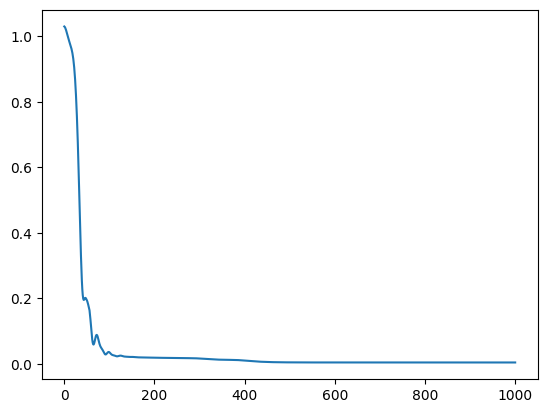

In [148]:
bp3_1.fit(X_sc3, T_sc3_1, epochs=1000, learning_rate = 0.001, momentum_term = 0.95, learning_rate_decay = 0)
print('Initial loss =', bp3_1.loss_list[0])
print('Final loss =', bp3_1.loss_list[-1])
plt.plot(bp3_1.loss_list)

In [149]:
bp3_1.export_weights()

[[[1.448263711477737, -0.45058462917363307],
  [-0.009701081841597285, -0.026607230492270022]],
 [[-0.9818691038726303, 0.8007202310176651]],
 [[1.541579859041305], [-0.6721012715648896]],
 [[0.1441087054464767]]]

In [150]:
weights3_1=bp3_1.export_weights()

In [151]:
manual_weights3_1=[[[-0.2328053114817587, 1.4197258515721494],
  [-0.013739923476318716, -0.009509632921841494]],
 [[1.5848282259786703, -0.9625030403646567]],
 [[-1.3007118041663503], [1.5725920350068667]],
 [[1.717]]] # manual correction by 0.12 to make positive at (0,0). delta=0.12/2.4=0.05.  Original: 1.6673341551414473

# 2 hidden prelu
# Final loss = 0.042

In [152]:
# bp3_1.import_weights(weights3_1)
bp3_1.import_weights(manual_weights3_1)
predics3_1=scaler_T3_1.inverse_transform(bp3_1.run(X_sc3))

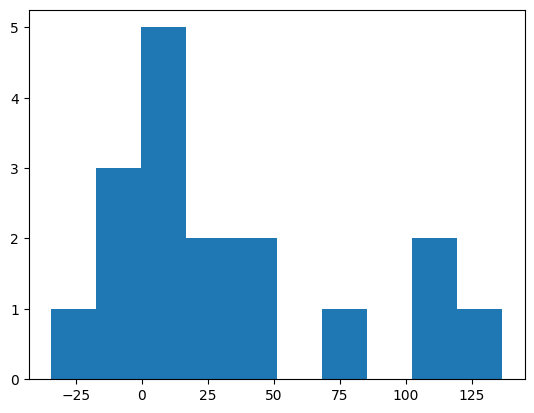

In [153]:
error3_1=(predics3_1[:,0]-T3_1[:,0])/T3_1[:,0]*100
plt.hist(error3_1)
plt.show()

In [154]:
mesh_predics3_1=scaler_T3_1.inverse_transform(  bp3_1.run( scaler_X3.transform(mesh3) )  )
# mesh_predics3_1

## water_org

In [155]:
X3_2=np.array(data3)[:12,[0,1]]
T3_2=np.array(data3)[:12,[3]]

In [156]:
# X3_2

In [157]:
scaler_X3_2 = preprocessing.StandardScaler().fit(X3_2)
scaler_T3_2 = preprocessing.StandardScaler().fit(T3_2)

scaler_data3_2 = [scaler_X3_2.mean_, scaler_X3_2.scale_, scaler_T3_2.mean_, scaler_T3_2.scale_]
print('scaler X -- mean, stdev:  ',scaler_data3_2[0], scaler_data3_2[1])
print('scaler T -- mean, stdev:  ',scaler_data3_2[2], scaler_data3_2[3])

X_sc3_2 = scaler_X3_2.transform(X3_2)
T_sc3_2 = scaler_T3_2.transform(T3_2)
X_sc3_2[0:3]

scaler X -- mean, stdev:   [27.03608333  0.0474    ] [14.68499343  0.04213688]
scaler T -- mean, stdev:   [10.81] [1.3091664]


array([[-1.84031974,  1.08693382],
       [-1.13797009, -1.0845606 ],
       [-1.13422477,  1.22458046]])

In [158]:
bp3_2=VectorBackProp(layers=[2,2,1], hidden_activation = 'prelu')

Initial loss = 1.0036892384866598
Final loss = 0.14385267148231384


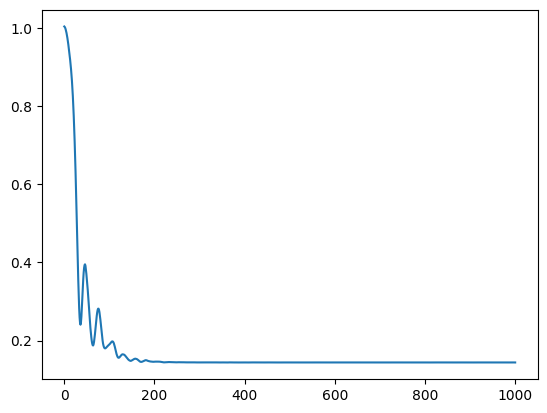

In [159]:
bp3_2.fit(X_sc3_2, T_sc3_2, epochs=1000, learning_rate = 0.001, momentum_term = 0.97, learning_rate_decay = 0)
print('Initial loss =', bp3_2.loss_list[0])
print('Final loss =', bp3_2.loss_list[-1])
plt.plot(bp3_2.loss_list)

In [160]:
bp3_2.export_weights()

[[[0.31350005396185987, -1.1681393250599945],
  [-1.1248909616166896, 0.43263756286640914]],
 [[-0.061602960637438225, 0.3223950518031864]],
 [[0.6414559981230484], [-0.6949320580730337]],
 [[0.1399972433093058]]]

In [161]:
weights3_2=bp3_2.export_weights()

In [162]:
manual_weights3_2=[[[0.3909002105371126, -0.8406267181665068],
  [-0.4530958444599508, 0.704664998208326]],
 [[-0.09671769242746425, 0.7927475123043677]],
 [[0.48441213405704675], [-0.7676170242577324]],
 [[0.6435152247205708]]]

# 2 hidden prelu
# Final loss = 0.18
# Good data only

In [163]:
# bp3_2.import_weights(weights3_2)
bp3_2.import_weights(manual_weights3_2)
predics3_2=scaler_T3_2.inverse_transform(bp3_2.run(X_sc3_2))

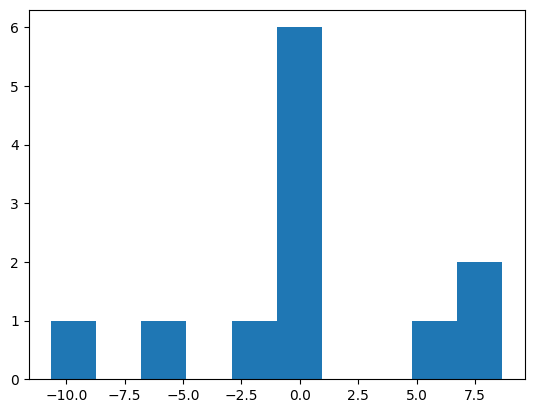

In [164]:
error3_2=(predics3_2[:,0]-T3_2[:,0])/T3_2[:,0]*100
plt.hist(error3_2)
plt.show()

In [165]:
mesh_predics3_2=scaler_T3_2.inverse_transform(  bp3_2.run( scaler_X3_2.transform(mesh3) )  )
# mesh_predics3_2

## solvent_aq

In [166]:
X3=np.array(data3)[:,[0,1]]
T3_3=np.array(data3)[:,[4]]

In [167]:
scaler_X3 = preprocessing.StandardScaler().fit(X3)
scaler_T3_3 = preprocessing.StandardScaler().fit(T3_3)

scaler_data3_3 = [scaler_X3.mean_, scaler_X3.scale_, scaler_T3_3.mean_, scaler_T3_3.scale_]
print('scaler X -- mean, stdev:  ',scaler_data3_3[0], scaler_data3_3[1])
print('scaler T -- mean, stdev:  ',scaler_data3_3[2], scaler_data3_3[3])

X_sc3 = scaler_X3.transform(X3)
T_sc3_3 = scaler_T3_3.transform(T3_3)
X_sc3[0:3]

scaler X -- mean, stdev:   [21.97576471  0.05575882] [15.2853469   0.05047379]
scaler T -- mean, stdev:   [1.4] [0.17875386]


array([[-1.43698176,  0.74179442],
       [-0.76221788, -1.0710276 ],
       [-0.75861966,  0.85670554]])

In [168]:
bp3_3=VectorBackProp(layers=[2,2,1], hidden_activation = 'prelu')

Initial loss = 1.0044793552156492
Final loss = 0.14517525164510092


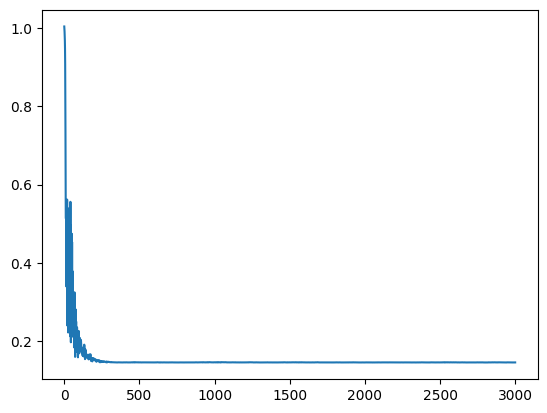

In [169]:
bp3_3.fit(X_sc3, T_sc3_3, epochs=3000, learning_rate = 0.01, momentum_term = 0.98, learning_rate_decay = 0)
print('Initial loss =', bp3_3.loss_list[0])
print('Final loss =', bp3_3.loss_list[-1])
plt.plot(bp3_3.loss_list)

In [170]:
bp3_3.export_weights()

[[[2.7236429453820694, -4.848390840061552],
  [0.2964220702459527, -1.167720788822962]],
 [[2.7427050275230886, -4.707980313351201]],
 [[-0.26358716969413654], [0.773627956982059]],
 [[0.5960922512203696]]]

In [171]:
weights3_3=bp3_3.export_weights()

In [172]:
manual_weights3_3=[[[0.6217022345240342, 2.8386999598609814],
  [-0.6968938452576019, 5.596033242601742]],
 [[2.7109590937198265, 0.22193377952697202]],
 [[-0.9372090292368469], [-0.33293100862641933]],
 [[3.277263990359097]]]

# 2 hidden prelu
# Final loss = 0.198

In [173]:
manual_weights3_3_2=[[[-7.637254337641781, -0.490322880885377],
  [-1.8058063735873857, -0.10159866035465558]],
 [[-0.843126492292387, -2.3299686091075773]],
 [[0.2643116291427324], [0.4479958576488306]],
 [[-0.7056420231884761]]]

# 2 hidden prelu # horizontal on highs
# Final loss = 0.093

In [174]:
bp3_3.import_weights(weights3_3)
bp3_3.import_weights(manual_weights3_3_2)
# bp3_3.import_weights(manual_weights3_3)
predics3_3=scaler_T3_3.inverse_transform(bp3_3.run(X_sc3))

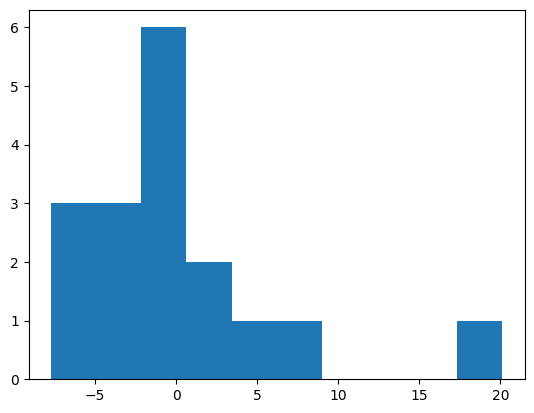

In [175]:
error3_3=(predics3_3[:,0]-T3_3[:,0])/T3_3[:,0]*100
plt.hist(error3_3)
plt.show()

In [176]:
mesh_predics3_3=scaler_T3_3.inverse_transform(  bp3_3.run( scaler_X3.transform(mesh3) )  )
# mesh_predics3_3

## SO4_org

In [177]:
X3=np.array(data3)[:,[0,1]]
T3_4=np.array(data3)[:,[5]]

In [178]:
scaler_X3 = preprocessing.StandardScaler().fit(X3)
scaler_T3_4 = preprocessing.StandardScaler().fit(T3_4)

scaler_data3_4 = [scaler_X3.mean_, scaler_X3.scale_, scaler_T3_4.mean_, scaler_T3_4.scale_]
print('scaler X -- mean, stdev:  ',scaler_data3_4[0], scaler_data3_4[1])
print('scaler T -- mean, stdev:  ',scaler_data3_4[2], scaler_data3_4[3])

X_sc3 = scaler_X3.transform(X3)
T_sc3_4 = scaler_T3_4.transform(T3_4)
X_sc3[0:3]

scaler X -- mean, stdev:   [21.97576471  0.05575882] [15.2853469   0.05047379]
scaler T -- mean, stdev:   [0.02921412] [0.01997862]


array([[-1.43698176,  0.74179442],
       [-0.76221788, -1.0710276 ],
       [-0.75861966,  0.85670554]])

In [179]:
bp3_4=VectorBackProp(layers=[2,2,1], hidden_activation = 'prelu')

Initial loss = 0.9901431133019801
Final loss = 0.014719683968938491


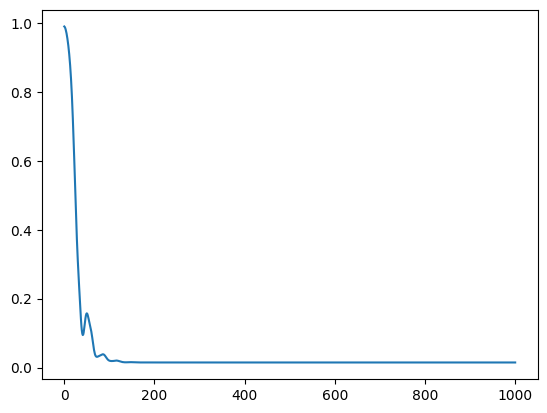

In [180]:
bp3_4.fit(X_sc3, T_sc3_4, epochs=1000, learning_rate = 0.001, momentum_term = 0.95, learning_rate_decay = 0)
print('Initial loss =', bp3_4.loss_list[0])
print('Final loss =', bp3_4.loss_list[-1])
plt.plot(bp3_4.loss_list)

In [181]:
bp3_4.export_weights()

[[[1.5195532563092524, 0.6007808323302554],
  [0.07951670723411328, -0.19484650595611097]],
 [[-0.8878500495213199, -0.2811875038163381]],
 [[1.5736775867285449], [0.47687163395475385]],
 [[-0.5560261214249761]]]

In [182]:
weights3_4=bp3_4.export_weights()

In [183]:
manual_weights3_4=[[[-0.10168260750729177, 1.5507975795954547],
  [-0.02429351337425621, -5.794943503077378e-05]],
 [[1.5556257229985646, -0.978368082003519]],
 [[-1.3219817921544152], [1.6394490601340548]],
 [[1.5742747334295601]]]
# 2 hidden prelu
# Final loss = 0.011

In [184]:
# bp3_4.import_weights(weights3_4)
bp3_4.import_weights(manual_weights3_4)
predics3_4=scaler_T3_4.inverse_transform(bp3_4.run(X_sc3))

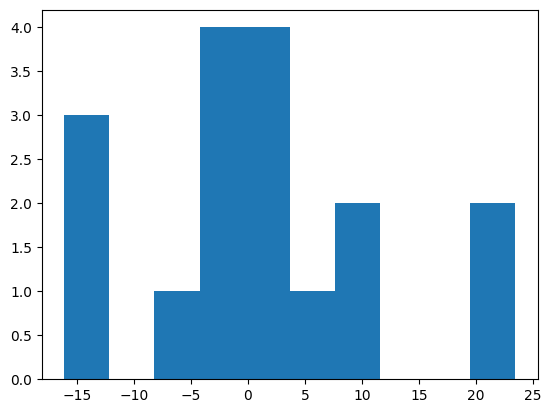

In [185]:
error3_4=(predics3_4[:,0]-T3_4[:,0])/T3_4[:,0]*100
plt.hist(error3_4)
plt.show()

In [186]:
mesh_predics3_4=scaler_T3_4.inverse_transform(  bp3_4.run( scaler_X3.transform(mesh3) )  )
# mesh_predics3_4

## Vizualization

In [187]:
fig_equil3_err = make_subplots(rows=1, cols=4, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.25, 0.25, 0.25, 0.25],
                     specs=[[{"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}]])

fig_equil3_err.add_trace(go.Scatter(x=T3[:,0] , y=predics3_1[:,0], mode='markers', marker_size=4, name='predics H3PO4_org', marker_color='black' ), 1, 1)
fig_equil3_err.add_trace(go.Scatter(x=T3[:,1] , y=predics3_2[:,0], mode='markers', marker_size=4, name='predics water_org', marker_color='black' ), 1, 2)
fig_equil3_err.add_trace(go.Scatter(x=T3[:,2] , y=predics3_3[:,0], mode='markers', marker_size=4, name='predics solvent_aq', marker_color='black' ), 1, 3)
fig_equil3_err.add_trace(go.Scatter(x=T3[:,3] , y=predics3_4[:,0], mode='markers', marker_size=4, name='predics SO4_org', marker_color='black' ), 1, 4)

fig_equil3_err.add_trace(go.Scatter(x=T3[:,0] , y=error3_1, mode='markers', marker_size=4, name='error H3PO4_org', marker_color='orange' ), 1, 1, secondary_y=True,)
fig_equil3_err.add_trace(go.Scatter(x=T3[:,1] , y=error3_2, mode='markers', marker_size=4, name='error water_org', marker_color='orange' ), 1, 2, secondary_y=True,)
fig_equil3_err.add_trace(go.Scatter(x=T3[:,2] , y=error3_3, mode='markers', marker_size=4, name='error solvent_aq', marker_color='orange' ), 1, 3, secondary_y=True,)
fig_equil3_err.add_trace(go.Scatter(x=T3[:,3] , y=error3_4, mode='markers', marker_size=4, name='error SO4_org', marker_color='orange' ), 1, 4, secondary_y=True,)

fig_equil3_err.update_layout(title='', autosize=True,
                  width=1550, height=250,
                  margin=dict(l=0, r=0, b=0, t=30))

fig_equil3_err.show()

In [188]:
fig_equil3 = make_subplots(rows=2, cols=2, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.5, 0.5], vertical_spacing=0.05,
                     specs=[[{"type": "scene"}, {"type": "scene"}],[{"type": "scene"}, {"type": "scene"}]])

fig_equil3.add_trace(go.Scatter3d(x=data3.H3PO4_aq, y=data3.SO4_aq, z=data3.H3PO4_org, mode='markers', name='H3PO4_org'), 1, 1)
fig_equil3.add_trace(go.Scatter3d(x=data3.H3PO4_aq, y=data3.SO4_aq, z=data3.water_org, mode='markers', name='water_org'), 1, 2)
fig_equil3.add_trace(go.Scatter3d(x=data3.H3PO4_aq, y=data3.SO4_aq, z=data3.solvent_aq, mode='markers', name='solvent_aq'), 2, 1)
fig_equil3.add_trace(go.Scatter3d(x=data3.H3PO4_aq, y=data3.SO4_aq, z=data3.SO4_org, mode='markers', name='SO4_org'), 2, 2)

# visib='legendonly'
visib=True

fig_equil3.add_trace(go.Scatter3d(x=x_mesh3[:,0], y=y_mesh3[:,0], z=mesh_predics3_1[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible=visib),1,1)
fig_equil3.add_trace(go.Scatter3d(x=x_mesh3[:,0], y=y_mesh3[:,0], z=mesh_predics3_2[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible=visib),1,2)
fig_equil3.add_trace(go.Scatter3d(x=x_mesh3[:,0], y=y_mesh3[:,0], z=mesh_predics3_3[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible=visib),2,1)
fig_equil3.add_trace(go.Scatter3d(x=x_mesh3[:,0], y=y_mesh3[:,0], z=mesh_predics3_4[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible=visib),2,2)

fig_equil3.update_layout(title='', autosize=True,
                  width=800, height=800,
                  margin=dict(l=0, r=0, b=0, t=30),
                  )

fig_equil3.update_layout(
    scene1_zaxis_range=[0,10],
    scene2_zaxis_range=[8,14],
    scene3_zaxis_range=[0,3],
    scene4_zaxis_range=[0,.1],
    )

# fig_equil3.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=-1.5, y=-1.5, z=1.5))
fig_equil3.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=0, y=-2.2, z=0))
# fig_equil3.update_scenes(camera_projection_type="orthographic")
# fig_equil3.write_html("IAmOH equilibrium experim data with models 130823.html")

fig_equil3.show()

## output

In [189]:
# H3PO4_org
bp3_1.print_weights()

Layers (input, hidden, output):  [2, 2, 1] prelu linear
Hidden layer weights:  [[-0.2328053114817587, 1.4197258515721494], [-0.013739923476318716, -0.009509632921841494]]
Hidden layer biases:  [[1.5848282259786703, -0.9625030403646567]]
Outlet layer weights:  [[-1.3007118041663503], [1.5725920350068667]]
Outlet layer biases:  [[1.717]]


In [190]:
bp3_1.export_weights()

[[[-0.2328053114817587, 1.4197258515721494],
  [-0.013739923476318716, -0.009509632921841494]],
 [[1.5848282259786703, -0.9625030403646567]],
 [[-1.3007118041663503], [1.5725920350068667]],
 [[1.717]]]

In [191]:
# water_org
bp3_2.print_weights()

Layers (input, hidden, output):  [2, 2, 1] prelu linear
Hidden layer weights:  [[0.3909002105371126, -0.8406267181665068], [-0.4530958444599508, 0.704664998208326]]
Hidden layer biases:  [[-0.09671769242746425, 0.7927475123043677]]
Outlet layer weights:  [[0.48441213405704675], [-0.7676170242577324]]
Outlet layer biases:  [[0.6435152247205708]]


In [192]:
bp3_2.export_weights()

[[[0.3909002105371126, -0.8406267181665068],
  [-0.4530958444599508, 0.704664998208326]],
 [[-0.09671769242746425, 0.7927475123043677]],
 [[0.48441213405704675], [-0.7676170242577324]],
 [[0.6435152247205708]]]

In [193]:
# solvent_aq
bp3_3.print_weights()

Layers (input, hidden, output):  [2, 2, 1] prelu linear
Hidden layer weights:  [[-7.637254337641781, -0.490322880885377], [-1.8058063735873857, -0.10159866035465558]]
Hidden layer biases:  [[-0.843126492292387, -2.3299686091075773]]
Outlet layer weights:  [[0.2643116291427324], [0.4479958576488306]]
Outlet layer biases:  [[-0.7056420231884761]]


In [194]:
bp3_3.export_weights()

[[[-7.637254337641781, -0.490322880885377],
  [-1.8058063735873857, -0.10159866035465558]],
 [[-0.843126492292387, -2.3299686091075773]],
 [[0.2643116291427324], [0.4479958576488306]],
 [[-0.7056420231884761]]]

In [195]:
# SO4_org
bp3_4.print_weights()

Layers (input, hidden, output):  [2, 2, 1] prelu linear
Hidden layer weights:  [[-0.10168260750729177, 1.5507975795954547], [-0.02429351337425621, -5.794943503077378e-05]]
Hidden layer biases:  [[1.5556257229985646, -0.978368082003519]]
Outlet layer weights:  [[-1.3219817921544152], [1.6394490601340548]]
Outlet layer biases:  [[1.5742747334295601]]


In [196]:
bp3_4.export_weights()

[[[-0.10168260750729177, 1.5507975795954547],
  [-0.02429351337425621, -5.794943503077378e-05]],
 [[1.5556257229985646, -0.978368082003519]],
 [[-1.3219817921544152], [1.6394490601340548]],
 [[1.5742747334295601]]]

# 4 - YPH_pur_1

In [197]:
df=CopyPasteToArray('''
Fe_aq	1/D
0.00840	116.7
0.00320	69.6
0.00470	72.3
0.00906	60.4
0.00541	43.3
0.00400	43.3
''')
df=pd.DataFrame(df[1:], columns=df[0])
df['label']=CopyPasteToArray('''
28th	28th	28th	7th	7th	7th
''')[0]
data4=df
data4

Fe_aq    1/D label
0  0.00840  116.7  28th
1  0.00320   69.6  28th
2  0.00470   72.3  28th
3  0.00906   60.4   7th
4  0.00541   43.3   7th
5  0.00400   43.3   7th

In [198]:
X4=np.array(data4)[:,[0]]
T4=np.array(data4)[:,[1]]

In [199]:
scaler_X4 = preprocessing.StandardScaler().fit(X4)
scaler_T4 = preprocessing.StandardScaler().fit(T4)

# scaler_X4.mean_, scaler_X4.scale_ = 0, 1 # disable scaling
# scaler_T4.mean_, scaler_T4.scale_ = 0, 1 # disable scaling

scaler_data4 = [scaler_X4.mean_, scaler_X4.scale_, scaler_T4.mean_, scaler_T4.scale_]
print('scaler X -- mean, stdev:  ',scaler_data4[0], scaler_data4[1])
print('scaler T -- mean, stdev:  ',scaler_data4[2], scaler_data4[3])

# X_sc4 = scaler_X4.transform(X4)
# T_sc4 = scaler_T4.transform(T4)
# X_sc4[0:3]

scaler X -- mean, stdev:   [0.005795] [0.00218897]
scaler T -- mean, stdev:   [67.6] [24.73095227]


## 28th

In [200]:
data4_1=data4[data4.label=='28th']
data4_1

Fe_aq    1/D label
0  0.0084  116.7  28th
1  0.0032   69.6  28th
2  0.0047   72.3  28th

In [201]:
X4_1=np.array(data4_1)[:,[0]]
T4_1=np.array(data4_1)[:,[1]]
X_sc4_1 = scaler_X4.transform(X4_1)
T_sc4_1 = scaler_T4.transform(T4_1)

fitting

In [202]:
bp4_1=VectorBackProp(layers=[1,2,1], hidden_activation = 'prelu')

In [203]:
bp4_1.fit(X_sc4_1, T_sc4_1, epochs=1000, learning_rate = 0.01, momentum_term = 0.9, learning_rate_decay = 0, init_var=.1, repeat=False)
bp4_1.loss_list[-1]

0.0019570340670979937

In [204]:
fig1=go.Figure()
fig1.add_trace(go.Scatter(y=bp4_1.loss_list[20:], name=''))
print('Initial loss =', bp4_1.loss_list[0])
print('Final loss =', bp4_1.loss_list[-1])

# fig1.update_yaxes(range=[0, 1])
# fig1.show()

Initial loss = 1.3909283482351886
Final loss = 0.0019570340670979937


In [205]:
bp4_1.export_weights()

[[[1.056020602618143, 0.01066416593672929]],
 [[0.3880205409667831, -0.07535358564487885]],
 [[1.124414705448291], [-0.02592957899202875]],
 [[0.13600965024070083]]]

In [206]:
weights4_1=[[[-0.40154548631450876, 1.0158534981949772]],
 [[-0.11055539480943363, 0.41943108875004126]],
 [[-0.3901591480587056], [1.0810541412468264]],
 [[0.22480836676521976]]]

# 2 hidden prelu
# Final loss = 1e-7

In [207]:
bp4_1.import_weights(weights4_1)

prediction

In [208]:
predics4_1=scaler_T4.inverse_transform(bp4_1.run(X_sc4_1))
# predics4_1[:,0]

In [209]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=X4_1[:,0], y=T4_1[:,0], mode='markers', marker_color='blue', name='data'),secondary_y=False)
# fig.add_trace(go.Scatter(x=X4_1[:,0], y=predics4_1[:,0], mode='markers', marker_color='black', name='prediction'),secondary_y=False)

X_mean, X_wigth = X4_1[:,0].mean(), X4_1[:,0].max()-X4_1[:,0].mean()
X_extended=np.linspace(X_mean-2*X_wigth, X_mean+2*X_wigth, 51)
fig.add_trace(go.Scatter(x=X_extended, y=scaler_T4.inverse_transform(bp4_1.run(scaler_X4.transform(X_extended.reshape(51,1))))[:,0], mode='markers', marker_size=3, name='extenden prediction'),secondary_y=False)

fig.update_xaxes(title_text="Fe_aq")

# Set y-axes titles
fig.update_yaxes(title_text="data, predics", secondary_y=False)
fig.update_yaxes(title_text="% error", range=[-2, 2], secondary_y=True, showgrid=False, tick0=-5, dtick=2)

fig.show()

## 7th

In [210]:
data4_2=data4[data4.label=='7th']
data4_2

Fe_aq   1/D label
3  0.00906  60.4   7th
4  0.00541  43.3   7th
5  0.00400  43.3   7th

In [211]:
X4_2=np.array(data4_2)[:,[0]]
T4_2=np.array(data4_2)[:,[1]]
X_sc4_2 = scaler_X4.transform(X4_2)
T_sc4_2 = scaler_T4.transform(T4_2)

fitting

In [212]:
bp4_2=VectorBackProp(layers=[1,1,1], hidden_activation = 'prelu')

In [213]:
bp4_2.fit(X_sc4_2, T_sc4_2, epochs=1000, learning_rate = 0.001, momentum_term = 0.9, learning_rate_decay = 0, init_var=.1, repeat=False)
bp4_2.loss_list[-1]

0.1062431421930214

In [214]:
fig1=go.Figure()
fig1.add_trace(go.Scatter(y=bp4_2.loss_list[20:], name=''))
print('Initial loss =', bp4_2.loss_list[0])
print('Final loss =', bp4_2.loss_list[-1])

# fig1.update_yaxes(range=[0, 1])
# fig1.show()

Initial loss = 0.47777417153798707
Final loss = 0.1062431421930214


In [215]:
bp4_2.export_weights()

[[[-0.03481973005005814]],
 [[-0.07266459460592004]],
 [[0.03307299270847177]],
 [[-0.7520913726992332]]]

In [216]:
weights4_2=[[[0.6358015459841858]],
 [[0.11489729435026273]],
 [[0.6396594654110533]],
 [[-0.9773384906278092]]]

# 1 hidden prelu
# Final loss = 1e-6

In [217]:
bp4_2.import_weights(weights4_2)

prediction

In [218]:
predics4_2=scaler_T4.inverse_transform(bp4_2.run(X_sc4_2))
# predics4_2[:,0]

In [219]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=X4_2[:,0], y=T4_2[:,0], mode='markers', marker_color='blue', name='data'),secondary_y=False)
# fig.add_trace(go.Scatter(x=X4_2[:,0], y=predics4_2[:,0], mode='markers', marker_color='black', name='prediction'),secondary_y=False)

X_mean, X_wigth = X4_2[:,0].mean(), X4_2[:,0].max()-X4_2[:,0].mean()
X_extended=np.linspace(X_mean-2*X_wigth, X_mean+2*X_wigth, 51)
fig.add_trace(go.Scatter(x=X_extended, y=scaler_T4.inverse_transform(bp4_2.run(scaler_X4.transform(X_extended.reshape(51,1))))[:,0], mode='markers', marker_size=3, name='extenden prediction'),secondary_y=False)

fig.update_xaxes(title_text="Fe_aq")

# Set y-axes titles
fig.update_yaxes(title_text="data, predics", secondary_y=False)
fig.update_yaxes(title_text="% error", range=[-2, 2], secondary_y=True, showgrid=False, tick0=-5, dtick=2)

fig.show()

## output

In [220]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=X4_1[:,0], y=T4_1[:,0], mode='markers', marker_color='lightblue', name='28th'))
fig.add_trace(go.Scatter(x=X4_2[:,0], y=T4_2[:,0], mode='markers', marker_color='orange', name='7th'))

X_mean, X_wigth = X4_2[:,0].mean(), X4_2[:,0].max()-X4_2[:,0].mean()
X_extended=np.linspace(X_mean-2*X_wigth, X_mean+2*X_wigth, 51)
fig.add_trace(go.Scatter(x=X_extended, y=scaler_T4.inverse_transform(bp4_1.run(scaler_X4.transform(X_extended.reshape(51,1))))[:,0], mode='markers', marker_color='black', marker_size=2, name=''))
fig.add_trace(go.Scatter(x=X_extended, y=scaler_T4.inverse_transform(bp4_2.run(scaler_X4.transform(X_extended.reshape(51,1))))[:,0], mode='markers', marker_color='black', marker_size=2, name=''))

fig.update_xaxes(title_text="%Fe_aq", range=[0,.01])
fig.update_yaxes(title_text="data, predics", range=[0,160])
fig.update_layout(plot_bgcolor='white')

fig.show()

In [221]:
print('scaler X -- mean, stdev:  ',scaler_data4[0], scaler_data4[1])
print('scaler T -- mean, stdev:  ',scaler_data4[2], scaler_data4[3])

scaler X -- mean, stdev:   [0.005795] [0.00218897]
scaler T -- mean, stdev:   [67.6] [24.73095227]


In [222]:
# 28th
bp4_1.print_weights()

Layers (input, hidden, output):  [1, 2, 1] prelu linear
Hidden layer weights:  [[-0.40154548631450876, 1.0158534981949772]]
Hidden layer biases:  [[-0.11055539480943363, 0.41943108875004126]]
Outlet layer weights:  [[-0.3901591480587056], [1.0810541412468264]]
Outlet layer biases:  [[0.22480836676521976]]


In [223]:
bp4_1.export_weights()

[[[-0.40154548631450876, 1.0158534981949772]],
 [[-0.11055539480943363, 0.41943108875004126]],
 [[-0.3901591480587056], [1.0810541412468264]],
 [[0.22480836676521976]]]

In [224]:
# 7th
bp4_2.print_weights()

Layers (input, hidden, output):  [1, 1, 1] prelu linear
Hidden layer weights:  [[0.6358015459841858]]
Hidden layer biases:  [[0.11489729435026273]]
Outlet layer weights:  [[0.6396594654110533]]
Outlet layer biases:  [[-0.9773384906278092]]


In [225]:
bp4_2.export_weights()

[[[0.6358015459841858]],
 [[0.11489729435026273]],
 [[0.6396594654110533]],
 [[-0.9773384906278092]]]

# 5 - EQUIL_rotem_extraction1
אזור לא מוחמץ:
 ממס שטוף מוחמץ עם חומצה גופתית ו-4 די

 חומרים סינתטיים

In [226]:
# נתוני ניסויי הפרדה
data=CopyPasteToArray('''
H3PO4_aq	SO4_aq	FA_aq	solvent_aq	H3PO4_org	SO4_org	water_org
48.0	0.20	97.4	1.13	9.0	0.09	13.1
53.6	0.22	89.8	0.86	15.0	0.11	13.8
62.7	0.24	70.3	0.94	24.8	0.14	14.5
69.0	0.22	64.0	0.78	34.8	0.16	15.6
47.2	1.10	104.3	0.78	9.3	0.19	13.4
52.2	1.10	100.0	0.96	16.3	0.32	14.2
59.1	1.06	100.0	1.00	25.3	0.44	15.7
65.1	0.94	100.0	1.04	35.3	0.58	16.1
46.7	3.04	113.0	0.74	11.0	0.98	14.8
53.3	3.02	107.4	1.52	19.3	1.20	15.5
58.8	2.90	106.9	1.48	28.7	1.40	15.8
65.4	2.82	109.4	1.46	37.8	1.78	16.6
46.1	5.20	121.7	1.28	15.7	1.42	15.3
52.5	4.96	115.4	1.48	23.3	2.02	16.7
59.1	4.86	112.1	1.54	30.9	2.64	16.5
65.1	4.56	112.5	1.64	41.1	3.06	17.3
''')
# data
data5_old=pd.DataFrame(data[1:], columns=data[0])
data5_old_names=CopyPasteToArray('''
103-1	103-2	103-3	103-4	103-5	103-6	103-7	103-8	103-9	103-10	103-11	103-12	103-13	103-14	103-15	103-16
''')
# data5_old

In [227]:
# נתוני ניסויי הפרדה
data=CopyPasteToArray('''
H3PO4_aq	SO4_aq	FA_aq	solvent_aq	H3PO4_org	SO4_org	water_org
48.0	0.200	97.4	1.13	8.97	0.0866	6.8
53.6	0.220	89.8	0.858	15.0	0.114	7.5
62.7	0.240	70.3	0.936	24.8	0.141	8.2
69.0	0.220	64.0	0.780	34.8	0.163	9.3
47.2	1.10	104	0.780	9.3	0.187	6.4
52.2	1.10	100	0.960	16.3	0.320	7.8
59.1	1.06	100	1.00	25.3	0.440	9.4
65.1	0.940	100	1.04	35.3	0.580	9.8
46.7	3.04	113	0.740	13.1	0.580	7.3
53.3	3.02	107	1.52	19.6	0.88	8.5
58.8	2.90	107	1.48	28.7	1.40	9.5
65.4	2.82	109	1.46	37.8	1.78	10.3
46.1	5.20	122	1.28	15.7	1.42	8.9
52.5	4.96	115	1.48	23.3	2.02	10.4
59.1	4.86	112	1.54	30.9	2.64	10.2
65.1	4.56	113	1.64	41.1	3.06	11.1
''')
# data
data5=pd.DataFrame(data[1:], columns=data[0])
data5_names=CopyPasteToArray('''
103-1	103-2	103-3	103-4	103-5	103-6	103-7	103-8	103-9	103-10	103-11	103-12	103-13	103-14	103-15	103-16
''')
# data5

In [228]:
fig_equil = make_subplots(rows=2, cols=2, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.5, 0.5], vertical_spacing=0.05,
                     specs=[[{"type": "scene"}, {"type": "scene"}],[{"type": "scene"}, {"type": "scene"}]])
plot_data=data5
text_data=data5_names[0]
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.H3PO4_org, marker_color='blue', marker_symbol='circle', mode='markers', name='H3PO4_org-synthetic', text=text_data), 1, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.water_org, marker_color='blue', marker_symbol='circle', mode='markers', name='water_org-synthetic', text=text_data), 1, 2)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.solvent_aq, marker_color='blue', marker_symbol='circle', mode='markers', name='solvent_aq-synthetic', text=text_data), 2, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.SO4_org, marker_color='blue', marker_symbol='circle', mode='markers', name='SO4_org-synthetic', text=text_data), 2, 2)

fig_equil.update_layout(title='', autosize=True,
                  width=810, height=800,
                  margin=dict(l=0, r=0, b=0, t=30),

                  )

fig_equil.update_layout(
    # scene1_zaxis_range=[0,10],
    # scene2_zaxis_range=[8,14],
    # scene3_zaxis_range=[0,3],
    # scene4_zaxis_range=[0,.1],
    )

# fig_equil.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=1.5, y=1.5, z=1.5))
fig_equil.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=-0.0001, y=-1.5, z=-0.0001))
fig_equil.update_scenes(camera_projection_type="orthographic")
# fig_equil.write_html("IAmOH equilibrium experim data 220924.html")

fig_equil.show()

In [229]:
# x_mesh, y_mesh = np.linspace(0, 60, 31), np.linspace(0, 0.2, 31) # expanded x and y extrapolation area observation
x_mesh, y_mesh = np.linspace(35, 80, 31), np.linspace(-1, 6, 31) # more expanded x and y extrapolation area observation
x_mesh, y_mesh = np.meshgrid(x_mesh, y_mesh)
x_mesh5 = x_mesh.flatten().reshape(31*31,1)
y_mesh5 = y_mesh.flatten().reshape(31*31,1)
mesh5=np.concatenate((x_mesh5, y_mesh5), axis=1)
# x_mesh5[:5]

In [230]:
X5=np.array(data5)[:,[0,1]]
T5=np.array(data5)[:,[2,3,4,5,6]]

In [231]:
scaler_X5 = preprocessing.StandardScaler().fit(X5)
scaler_T5 = preprocessing.StandardScaler().fit(T5)

scaler_data5 = [scaler_X5.mean_, scaler_X5.scale_, scaler_T5.mean_, scaler_T5.scale_]
print('scaler X -- mean, stdev:  ',scaler_data5[0], scaler_data5[1])
print('scaler T -- mean, stdev:  ',scaler_data5[2], scaler_data5[3])

scaler X -- mean, stdev:   [56.49375  2.2775 ] [7.31739953 1.80984633]
scaler T -- mean, stdev:   [101.46875    1.164     23.748125   0.988225   8.8375  ] [15.08387876  0.30627031  9.96251049  0.92797145  1.35317913]


## H3PO4_org

In [232]:
T5_1=np.array(data5)[:,[4]]

In [233]:
H3PO4_org_5=Fit2to1(X5, T5_1, mesh5, hidden_layers=1, hidden_activation='linear')

In [234]:
H3PO4_org_5.fit_model(epochs=1000, learning_rate = 0.001, momentum_term = 0.95)

Initial loss = 0.9918171860797653
Final loss = 0.01881975081650628


In [235]:
H3PO4_org_5.export_weights()

Hidden layers: 1
Hidden activation: linear
Loss: 0.01881975081650628 



[[[0.9593983597087415], [0.3657512164710678]],
 [[-0.029969341711072385]],
 [[1.0167773052715803]],
 [[0.030472146506645335]]]

In [236]:
weights=[[[-1.006032559362656], [-0.37276835446915224]],
 [[0.1299224261198966]],
 [[-0.9718674171521668]],
 [[0.12626737270127453]]]

H3PO4_org_5.import_weights(weights)

In [237]:
H3PO4_org_5.show()

In [238]:
H3PO4_org_5.network.print_weights()

Layers (input, hidden, output):  [2, 1, 1] linear linear
Hidden layer weights:  [[-1.006032559362656], [-0.37276835446915224]]
Hidden layer biases:  [[0.1299224261198966]]
Outlet layer weights:  [[-0.9718674171521668]]
Outlet layer biases:  [[0.12626737270127453]]


## water_org

In [239]:
T5_2=np.array(data5)[:,[6]]

In [240]:
water_org_5=Fit2to1(X5, T5_2, mesh5, hidden_layers=2, hidden_activation='sigmoid')

In [241]:
water_org_5.fit_model(epochs=1000, learning_rate = 0.001, momentum_term = 0.98)

Initial loss = 1.00617539019916
Final loss = 0.0809725935706851


In [242]:
water_org_5.export_weights()

Hidden layers: 2
Hidden activation: sigmoid
Loss: 0.0809725935706851 



[[[0.07355836349222586, -0.9348036021067768],
  [0.3271627453190869, -0.8205514275328495]],
 [[-0.18362284596289757, -0.24755162121459331]],
 [[0.32032907985661535], [-3.9763444277894906]],
 [[1.6471399115678755]]]

In [243]:
weights=[[[-1.014431568034154, 1.6211860775688847],
  [-1.520450972190414, 0.6074304841701954]],
 [[0.805729877226275, 1.8044074423765792]],
 [[-1.8341007827104046], [2.3655122050787463]],
 [[-0.6565252635980716]]]

water_org_5.import_weights(weights)

In [244]:
water_org_5.show()

In [245]:
water_org_5.network.print_weights()

Layers (input, hidden, output):  [2, 2, 1] sigmoid linear
Hidden layer weights:  [[-1.014431568034154, 1.6211860775688847], [-1.520450972190414, 0.6074304841701954]]
Hidden layer biases:  [[0.805729877226275, 1.8044074423765792]]
Outlet layer weights:  [[-1.8341007827104046], [2.3655122050787463]]
Outlet layer biases:  [[-0.6565252635980716]]


## solvent_aq

In [246]:
T5_3=np.array(data5)[:,[3]]

In [247]:
solvent_aq_5=Fit2to1(X5, T5_3, mesh5, hidden_layers=2, hidden_activation='sigmoid')

In [248]:
solvent_aq_5.fit_model(epochs=3000, learning_rate = 0.001, momentum_term = 0.99)

Initial loss = 1.0009522741996482
Final loss = 0.11749673216763967


In [249]:
solvent_aq_5.export_weights()

Hidden layers: 2
Hidden activation: sigmoid
Loss: 0.11749673216763967 



[[[-1.9692391483916005, 7.437915827724659],
  [-2.458628759325288, 14.309933923622696]],
 [[5.102372187338184, 0.39710803807514733]],
 [[-1.1764158626045433], [1.7383524565845299]],
 [[0.30828060066746504]]]

In [250]:
weights=[[[-3.1296134750126954, 2.227058569376953],
  [-7.204296971759513, -1.2381599369648186]],
 [[0.3519869889097359, 3.3664334439191586]],
 [[-2.1407099255807127], [1.231884590355962]],
 [[0.1495464346293124]]]

solvent_aq_5.import_weights(weights)

In [251]:
solvent_aq_5.show()

In [252]:
solvent_aq_5.network.print_weights()

Layers (input, hidden, output):  [2, 2, 1] sigmoid linear
Hidden layer weights:  [[-3.1296134750126954, 2.227058569376953], [-7.204296971759513, -1.2381599369648186]]
Hidden layer biases:  [[0.3519869889097359, 3.3664334439191586]]
Outlet layer weights:  [[-2.1407099255807127], [1.231884590355962]]
Outlet layer biases:  [[0.1495464346293124]]


## SO4_org

In [253]:
T5_4=np.array(data5)[:,[5]]

In [254]:
SO4_org_5=Fit2to1(X5, T5_4, mesh5, hidden_layers=2, hidden_activation='sigmoid')

In [255]:
SO4_org_5.fit_model(epochs=1000, learning_rate = 0.001, momentum_term = 0.98)

Initial loss = 1.0271546201453308
Final loss = 0.010904587396383041


In [256]:
SO4_org_5.export_weights()

Hidden layers: 2
Hidden activation: sigmoid
Loss: 0.010904587396383041 



[[[1.4822857271295504, -0.5851911212007708],
  [2.117600836115881, -2.0613991071349513]],
 [[-2.9436889382471296, 0.16672257855486677]],
 [[2.4157336178694537], [-1.3354847103332117]],
 [[0.3059508324597104]]]

In [257]:
weights=[[[-1.4871060802013703, 0.13885730543222838],
  [-2.0113418348630954, 1.8327754896358028]],
 [[2.934341903953278, 0.7508719287765995]],
 [[-2.4717643248582526], [1.6675591945235226]],
 [[1.0769652082059904]]]

SO4_org_5.import_weights(weights)

In [258]:
SO4_org_5.show()

In [259]:
SO4_org_5.network.print_weights()

Layers (input, hidden, output):  [2, 2, 1] sigmoid linear
Hidden layer weights:  [[-1.4871060802013703, 0.13885730543222838], [-2.0113418348630954, 1.8327754896358028]]
Hidden layer biases:  [[2.934341903953278, 0.7508719287765995]]
Outlet layer weights:  [[-2.4717643248582526], [1.6675591945235226]]
Outlet layer biases:  [[1.0769652082059904]]


## Vizualization

In [260]:
fig_equil_err = make_subplots(rows=1, cols=4, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.25, 0.25, 0.25, 0.25],
                     specs=[[{"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}]])

fig_equil_err.add_trace(go.Scatter(x=H3PO4_org_5.T[:,0] , y=H3PO4_org_5.predics[:,0], mode='markers', marker_size=4, name='predics H3PO4_org', marker_color='black' ), 1, 1)
fig_equil_err.add_trace(go.Scatter(x=water_org_5.T[:,0] , y=water_org_5.predics[:,0], mode='markers', marker_size=4, name='predics water_org', marker_color='black' ), 1, 2)
fig_equil_err.add_trace(go.Scatter(x=solvent_aq_5.T[:,0] , y=solvent_aq_5.predics[:,0], mode='markers', marker_size=4, name='predics solvent_aq', marker_color='black' ), 1, 3)
fig_equil_err.add_trace(go.Scatter(x=SO4_org_5.T[:,0] , y=SO4_org_5.predics[:,0], mode='markers', marker_size=4, name='predics SO4_org', marker_color='black' ), 1, 4)

fig_equil_err.add_trace(go.Scatter(x=H3PO4_org_5.T[:,0] , y=H3PO4_org_5.errors, mode='markers', marker_size=4, name='error H3PO4_org', marker_color='orange' ), 1, 1, secondary_y=True,)
fig_equil_err.add_trace(go.Scatter(x=water_org_5.T[:,0] , y=water_org_5.errors, mode='markers', marker_size=4, name='error water_org', marker_color='orange' ), 1, 2, secondary_y=True,)
fig_equil_err.add_trace(go.Scatter(x=solvent_aq_5.T[:,0] , y=solvent_aq_5.errors, mode='markers', marker_size=4, name='error solvent_aq', marker_color='orange' ), 1, 3, secondary_y=True,)
fig_equil_err.add_trace(go.Scatter(x=SO4_org_5.T[:,0] , y=SO4_org_5.errors, mode='markers', marker_size=4, name='error SO4_org', marker_color='orange' ), 1, 4, secondary_y=True,)

fig_equil_err.update_layout(title='', autosize=True,
                  width=1550, height=250,
                  margin=dict(l=0, r=0, b=0, t=30))

fig_equil_err.show()

In [261]:
fig_equil = make_subplots(rows=2, cols=2, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.5, 0.5], vertical_spacing=0.05,
                     specs=[[{"type": "scene"}, {"type": "scene"}],[{"type": "scene"}, {"type": "scene"}]])

fig_equil.add_trace(go.Scatter3d(x=data5.H3PO4_aq, y=data5.SO4_aq, z=data5.H3PO4_org, mode='markers', name='H3PO4_org'), 1, 1)
fig_equil.add_trace(go.Scatter3d(x=data5.H3PO4_aq, y=data5.SO4_aq, z=data5.water_org, mode='markers', name='water_org'), 1, 2)
fig_equil.add_trace(go.Scatter3d(x=data5.H3PO4_aq, y=data5.SO4_aq, z=data5.solvent_aq, mode='markers', name='solvent_aq'), 2, 1)
fig_equil.add_trace(go.Scatter3d(x=data5.H3PO4_aq, y=data5.SO4_aq, z=data5.SO4_org, mode='markers', name='SO4_org'), 2, 2)

# visib='legendonly'
visib=True

fig_equil.add_trace(go.Scatter3d(x=x_mesh5[:,0], y=y_mesh5[:,0], z=H3PO4_org_5.mesh_predics[:,0], mode='markers',marker_color='blue', marker_size=0.5, name='model mesh', visible=visib),1,1)
fig_equil.add_trace(go.Scatter3d(x=x_mesh5[:,0], y=y_mesh5[:,0], z=water_org_5.mesh_predics[:,0], mode='markers',marker_color='blue', marker_size=0.5, name='model mesh', visible=visib),1,2)
fig_equil.add_trace(go.Scatter3d(x=x_mesh5[:,0], y=y_mesh5[:,0], z=solvent_aq_5.mesh_predics[:,0], mode='markers',marker_color='blue', marker_size=0.5, name='model mesh', visible=visib),2,1)
fig_equil.add_trace(go.Scatter3d(x=x_mesh5[:,0], y=y_mesh5[:,0], z=SO4_org_5.mesh_predics[:,0], mode='markers',marker_color='blue', marker_size=0.5, name='model mesh', visible=visib),2,2)

fig_equil.update_layout(title='', autosize=True,
                  width=800, height=800,
                  margin=dict(l=0, r=0, b=0, t=30),
                  )

fig_equil.update_layout(
    # scene1_zaxis_range=[0,10],
    # scene2_zaxis_range=[8,14],
    # scene3_zaxis_range=[0,3],
    # scene4_zaxis_range=[0,.1],
    )

# fig_equil.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=-1.5, y=-1.5, z=1.5))
fig_equil.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=0, y=-2.2, z=0))
# fig_equil.update_scenes(camera_projection_type="orthographic")
# fig_equil.write_html("IAmOH equilibrium experim data with models 130823.html")

fig_equil.show()

## output

# 6 - EQUIL_rotem_extraction2
אזור לא מוחמץ:
 ממס מוחמץ מהמתקן ו-4 די עם בריום

 חומרים מהמתקן

In [262]:
# נתוני ניסויי הפרדה
data=CopyPasteToArray('''
H3PO4_aq	SO4_aq	FA_aq	solvent_aq	H3PO4_org	SO4_org	water_org
47.2	0.044	84.5	0.91	8.42	0.2600	6.2
53.6	0.035	86.3	0.920	14.7	0.280	6.9
60.2	0.049	86.2	0.914	23.1	0.260	8.1
66.5	0.026	86.9	1.012	33.4	0.220	9.3
47.5	0.96	89	0.982	9.8	0.340	6.8
53.8	0.84	89	0.938	16.5	0.420	7.5
61.6	0.68	89	0.98	25.3	0.460	8.8
66.5	0.480	88	1.00	35.6	0.440	9.6
47.2	2.84	102	1.034	12.0	0.700	6.8
53.6	2.72	100	1.01	19.2	1.00	7.8
60.2	2.68	98	1.04	28.4	1.32	9.3
66.5	2.44	97	1.11	39.2	1.52	10.3
47.2	4.92	106	1.1	14.5	1.34	8.2
53.8	4.82	101	1.10	22.4	1.96	9.4
60.7	4.72	104	1.11	32.6	2.60	10.5
67.4	4.54	96	1.22	44.4	3.14	11.3
''')
# data
data6=pd.DataFrame(data[1:], columns=data[0])
data6_names=CopyPasteToArray('''
107-1	107-2	107-3	107-4	107-5	107-6	107-7	107-8	107-9	107-10	107-11	107-12	107-13	107-14	107-15	107-16
''')
# data6

In [263]:
fig_equil = make_subplots(rows=2, cols=2, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.5, 0.5], vertical_spacing=0.05,
                     specs=[[{"type": "scene"}, {"type": "scene"}],[{"type": "scene"}, {"type": "scene"}]])
plot_data=data6
text_data=data6_names[0]
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.H3PO4_org, marker_color='green', marker_symbol='circle', mode='markers', name='H3PO4_org-process', text=text_data), 1, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.water_org, marker_color='green', marker_symbol='circle', mode='markers', name='water_org-process', text=text_data), 1, 2)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.solvent_aq, marker_color='green', marker_symbol='circle', mode='markers', name='solvent_aq-process', text=text_data), 2, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.SO4_org, marker_color='green', marker_symbol='circle', mode='markers', name='SO4_org-process', text=text_data), 2, 2)

plot_data=data5
text_data=data5_names[0]
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.H3PO4_org, marker_color='blue', marker_symbol='circle', mode='markers', name='H3PO4_org-synthetic', text=text_data), 1, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.water_org, marker_color='blue', marker_symbol='circle', mode='markers', name='water_org-synthetic', text=text_data), 1, 2)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.solvent_aq, marker_color='blue', marker_symbol='circle', mode='markers', name='solvent_aq-synthetic', text=text_data), 2, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.SO4_org, marker_color='blue', marker_symbol='circle', mode='markers', name='SO4_org-synthetic', text=text_data), 2, 2)


fig_equil.update_layout(title='', autosize=True,
                  width=810, height=800,
                  margin=dict(l=0, r=0, b=0, t=30),

                  )

fig_equil.update_layout(
    # scene1_zaxis_range=[0,10],
    # scene2_zaxis_range=[8,14],
    # scene3_zaxis_range=[0,3],
    # scene4_zaxis_range=[0,.1],
    )

# fig_equil.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=1.5, y=1.5, z=1.5))
fig_equil.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=-0.0001, y=-1.5, z=-0.0001), aspectratio=dict(x=1, y=1, z=1))
fig_equil.update_scenes(camera_projection_type="orthographic")
# fig_equil.write_html("IAmOH equilibrium experim data 141124.html")

fig_equil.show()

In [264]:
# x_mesh, y_mesh = np.linspace(0, 60, 31), np.linspace(0, 0.2, 31) # expanded x and y extrapolation area observation
x_mesh, y_mesh = np.linspace(35, 80, 31), np.linspace(-1, 6, 31) # more expanded x and y extrapolation area observation
x_mesh, y_mesh = np.meshgrid(x_mesh, y_mesh)
x_mesh6 = x_mesh.flatten().reshape(31*31,1)
y_mesh6 = y_mesh.flatten().reshape(31*31,1)
mesh6=np.concatenate((x_mesh6, y_mesh6), axis=1)
# x_mesh5[:6]

In [265]:
X6=np.array(data6)[:,[0,1]]
T6=np.array(data6)[:,[2,3,4,5,6]]

In [266]:
scaler_X6 = preprocessing.StandardScaler().fit(X6)
scaler_T6 = preprocessing.StandardScaler().fit(T6)

scaler_data6 = [scaler_X6.mean_, scaler_X6.scale_, scaler_T6.mean_, scaler_T6.scale_]
print('scaler X -- mean, stdev:  ',scaler_data6[0], scaler_data6[1])
print('scaler T -- mean, stdev:  ',scaler_data6[2], scaler_data6[3])

scaler X -- mean, stdev:   [57.09375   2.049625] [7.31466581 1.8377914 ]
scaler T -- mean, stdev:   [93.93125  1.02375 23.72     1.01625  8.55   ] [ 7.04323423  0.08405318 10.64087637  0.87444893  1.45344419]


## H3PO4_org

In [267]:
T6_1=np.array(data6)[:,[4]]

In [268]:
H3PO4_org_6=Fit2to1(X6, T6_1, mesh6, hidden_layers=1, hidden_activation='linear')

In [269]:
H3PO4_org_6.fit_model(epochs=1000, learning_rate = 0.001, momentum_term = 0.95)

Initial loss = 1.0032531843510082
Final loss = 0.015314201935206901


In [270]:
H3PO4_org_6.export_weights()

Hidden layers: 1
Hidden activation: linear
Loss: 0.015314201935206901 



[[[1.0159631992481846], [0.3088434545486244]],
 [[0.20687033321113102]],
 [[0.9488772533273352]],
 [[-0.1962945535702986]]]

In [271]:
weights=[[[-0.955055615711845], [-0.2903281101699576]],
 [[0.05890139295013353]],
 [[-1.0093908188646648]],
 [[0.059454525263819245]]]

H3PO4_org_6.import_weights(weights)

In [272]:
H3PO4_org_6.show()

In [273]:
H3PO4_org_6.network.print_weights()

Layers (input, hidden, output):  [2, 1, 1] linear linear
Hidden layer weights:  [[-0.955055615711845], [-0.2903281101699576]]
Hidden layer biases:  [[0.05890139295013353]]
Outlet layer weights:  [[-1.0093908188646648]]
Outlet layer biases:  [[0.059454525263819245]]


## water_org

In [274]:
T6_2=np.array(data6)[:,[6]]

In [275]:
water_org_6=Fit2to1(X6, T6_2, mesh6, hidden_layers=1, hidden_activation='sigmoid')

In [276]:
water_org_6.fit_model(epochs=1000, learning_rate = 0.001, momentum_term = 0.98)

Initial loss = 1.0150338904390357
Final loss = 0.013277280720143642


In [277]:
water_org_6.export_weights()

Hidden layers: 1
Hidden activation: sigmoid
Loss: 0.013277280720143642 



[[[-0.9885380190239988], [-0.6518090806805282]],
 [[0.2406799876022443]],
 [[-4.218142294216979]],
 [[2.307979360045661]]]

In [278]:
weights=[[[0.9797325288589118], [0.6454888493575067]],
 [[-0.25003205161272524]],
 [[4.248272874210578]],
 [[-1.9149097831677415]]]

water_org_6.import_weights(weights)

In [279]:
water_org_6.show()

In [280]:
water_org_6.network.print_weights()

Layers (input, hidden, output):  [2, 1, 1] sigmoid linear
Hidden layer weights:  [[0.9797325288589118], [0.6454888493575067]]
Hidden layer biases:  [[-0.25003205161272524]]
Outlet layer weights:  [[4.248272874210578]]
Outlet layer biases:  [[-1.9149097831677415]]


## solvent_aq

In [281]:
T6_3=np.array(data6)[:,[3]]

In [282]:
solvent_aq_6=Fit2to1(X6, T6_3, mesh6, hidden_layers=2, hidden_activation='sigmoid')

In [283]:
solvent_aq_6.fit_model(epochs=3000, learning_rate = 0.001, momentum_term = 0.98)

Initial loss = 0.9999114701835388
Final loss = 0.01911802421776388


In [284]:
solvent_aq_6.export_weights()

Hidden layers: 2
Hidden activation: sigmoid
Loss: 0.01911802421776388 



[[[-2.428132356647974, 0.18801714385517165],
  [-0.1810180052810544, -0.8941390778458772]],
 [[2.8814830320089135, -0.15091570125567422]],
 [[-2.689905465963273], [-4.153815006612907]],
 [[4.150427837761424]]]

In [285]:
weights=[[[-0.22051001263966905, 1.9318267551530488],
  [0.8962723017655152, 0.12614126900021025]],
 [[0.10108909752159997, -2.95948488740312]],
 [[4.114708292246175], [4.094395462379633]],
 [[-2.6769404622459474]]]

solvent_aq_6.import_weights(weights)

In [286]:
solvent_aq_6.show()

In [287]:
solvent_aq_6.network.print_weights()

Layers (input, hidden, output):  [2, 2, 1] sigmoid linear
Hidden layer weights:  [[-0.22051001263966905, 1.9318267551530488], [0.8962723017655152, 0.12614126900021025]]
Hidden layer biases:  [[0.10108909752159997, -2.95948488740312]]
Outlet layer weights:  [[4.114708292246175], [4.094395462379633]]
Outlet layer biases:  [[-2.6769404622459474]]


## SO4_org

In [288]:
T6_4=np.array(data6)[:,[5]]

In [289]:
SO4_org_6=Fit2to1(X6, T6_4, mesh6, hidden_layers=2, hidden_activation='sigmoid')

In [290]:
SO4_org_6.fit_model(epochs=1000, learning_rate = 0.001, momentum_term = 0.98)

Initial loss = 1.0034207107899609
Final loss = 0.008723275429824102


In [291]:
SO4_org_6.export_weights()

Hidden layers: 2
Hidden activation: sigmoid
Loss: 0.008723275429824102 



[[[0.14344934673685308, -1.4957282713118274],
  [1.2472487263036713, -1.874991946976686]],
 [[-0.3845321901778828, 2.952317860428526]],
 [[1.7333768245721877], [-2.513099145275095]],
 [[1.368884059247996]]]

In [292]:
weights=[[[0.9658566473792896, -0.3793888323654161],
  [1.3932198934262354, 1.3330135232938591]],
 [[-2.1588625205276855, 0.7697648285851637]],
 [[3.845916574949848], [0.9893265872574634]],
 [[-1.3415194723479826]]]

SO4_org_6.import_weights(weights)

In [293]:
SO4_org_6.show()

In [294]:
SO4_org_6.network.print_weights()

Layers (input, hidden, output):  [2, 2, 1] sigmoid linear
Hidden layer weights:  [[0.9658566473792896, -0.3793888323654161], [1.3932198934262354, 1.3330135232938591]]
Hidden layer biases:  [[-2.1588625205276855, 0.7697648285851637]]
Outlet layer weights:  [[3.845916574949848], [0.9893265872574634]]
Outlet layer biases:  [[-1.3415194723479826]]


## Vizualization

In [295]:
fig_equil_err = make_subplots(rows=1, cols=4, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.25, 0.25, 0.25, 0.25],
                     specs=[[{"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}]])

fig_equil_err.add_trace(go.Scatter(x=H3PO4_org_6.T[:,0] , y=H3PO4_org_6.predics[:,0], mode='markers', marker_size=4, name='predics H3PO4_org', marker_color='black' ), 1, 1)
fig_equil_err.add_trace(go.Scatter(x=water_org_6.T[:,0] , y=water_org_6.predics[:,0], mode='markers', marker_size=4, name='predics water_org', marker_color='black' ), 1, 2)
fig_equil_err.add_trace(go.Scatter(x=solvent_aq_6.T[:,0] , y=solvent_aq_6.predics[:,0], mode='markers', marker_size=4, name='predics solvent_aq', marker_color='black' ), 1, 3)
fig_equil_err.add_trace(go.Scatter(x=SO4_org_6.T[:,0] , y=SO4_org_6.predics[:,0], mode='markers', marker_size=4, name='predics SO4_org', marker_color='black' ), 1, 4)

fig_equil_err.add_trace(go.Scatter(x=H3PO4_org_6.T[:,0] , y=H3PO4_org_6.errors, mode='markers', marker_size=4, name='error H3PO4_org', marker_color='orange' ), 1, 1, secondary_y=True,)
fig_equil_err.add_trace(go.Scatter(x=water_org_6.T[:,0] , y=water_org_6.errors, mode='markers', marker_size=4, name='error water_org', marker_color='orange' ), 1, 2, secondary_y=True,)
fig_equil_err.add_trace(go.Scatter(x=solvent_aq_6.T[:,0] , y=solvent_aq_6.errors, mode='markers', marker_size=4, name='error solvent_aq', marker_color='orange' ), 1, 3, secondary_y=True,)
fig_equil_err.add_trace(go.Scatter(x=SO4_org_6.T[:,0] , y=SO4_org_6.errors, mode='markers', marker_size=4, name='error SO4_org', marker_color='orange' ), 1, 4, secondary_y=True,)

fig_equil_err.update_layout(title='', autosize=True,
                  width=1550, height=250,
                  margin=dict(l=0, r=0, b=0, t=30))

fig_equil_err.show()

In [296]:
fig_equil = make_subplots(rows=2, cols=2, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.5, 0.5], vertical_spacing=0.05,
                     specs=[[{"type": "scene"}, {"type": "scene"}],[{"type": "scene"}, {"type": "scene"}]])

fig_equil.add_trace(go.Scatter3d(x=data6.H3PO4_aq, y=data6.SO4_aq, z=data6.H3PO4_org, mode='markers', name='H3PO4_org'), 1, 1)
fig_equil.add_trace(go.Scatter3d(x=data6.H3PO4_aq, y=data6.SO4_aq, z=data6.water_org, mode='markers', name='water_org'), 1, 2)
fig_equil.add_trace(go.Scatter3d(x=data6.H3PO4_aq, y=data6.SO4_aq, z=data6.solvent_aq, mode='markers', name='solvent_aq'), 2, 1)
fig_equil.add_trace(go.Scatter3d(x=data6.H3PO4_aq, y=data6.SO4_aq, z=data6.SO4_org, mode='markers', name='SO4_org'), 2, 2)

# visib='legendonly'
visib=True

fig_equil.add_trace(go.Scatter3d(x=x_mesh6[:,0], y=y_mesh6[:,0], z=H3PO4_org_6.mesh_predics[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible=visib),1,1)
fig_equil.add_trace(go.Scatter3d(x=x_mesh6[:,0], y=y_mesh6[:,0], z=water_org_6.mesh_predics[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible=visib),1,2)
fig_equil.add_trace(go.Scatter3d(x=x_mesh6[:,0], y=y_mesh6[:,0], z=solvent_aq_6.mesh_predics[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible=visib),2,1)
fig_equil.add_trace(go.Scatter3d(x=x_mesh6[:,0], y=y_mesh6[:,0], z=SO4_org_6.mesh_predics[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible=visib),2,2)

fig_equil.update_layout(title='', autosize=True,
                  width=800, height=800,
                  margin=dict(l=0, r=0, b=0, t=30),
                  )

fig_equil.update_layout(
    # scene1_zaxis_range=[0,10],
    # scene2_zaxis_range=[8,14],
    # scene3_zaxis_range=[0,3],
    # scene4_zaxis_range=[0,.1],
    )

# fig_equil.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=-1.5, y=-1.5, z=1.5))
fig_equil.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=0, y=-2.2, z=0))
# fig_equil.update_scenes(camera_projection_type="orthographic")
# fig_equil.write_html("IAmOH equilibrium experim data with models 130823.html")

fig_equil.show()

## together

In [297]:
fig_equil = make_subplots(rows=2, cols=2, subplot_titles=('H3PO4_org', 'water_org', 'solvent_aq', 'SO4_org'),
                          column_widths=[0.5, 0.5], vertical_spacing=0.05,
                          specs=[[{"type": "scene"}, {"type": "scene"}], [{"type": "scene"}, {"type": "scene"}]])

# Synthetic data (data5)
plot_data = data5
text_data = data5_names[0]
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.H3PO4_org,
                                 marker_color='blue', marker_symbol='circle', mode='markers', name='data synthetic',
                                 legendgroup="data synthetic", showlegend=True, text=text_data), 1, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.water_org,
                                 marker_color='blue', marker_symbol='circle', mode='markers',
                                 legendgroup="data synthetic", showlegend=False, text=text_data), 1, 2)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.solvent_aq,
                                 marker_color='blue', marker_symbol='circle', mode='markers',
                                 legendgroup="data synthetic", showlegend=False, text=text_data), 2, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.SO4_org,
                                 marker_color='blue', marker_symbol='circle', mode='markers',
                                 legendgroup="data synthetic", showlegend=False, text=text_data), 2, 2)

# Process data (data6)
plot_data = data6
text_data = data6_names[0]
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.H3PO4_org,
                                 marker_color='green', marker_symbol='circle', mode='markers', name='data process',
                                 legendgroup="data process", showlegend=True, text=text_data), 1, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.water_org,
                                 marker_color='green', marker_symbol='circle', mode='markers',
                                 legendgroup="data process", showlegend=False, text=text_data), 1, 2)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.solvent_aq,
                                 marker_color='green', marker_symbol='circle', mode='markers',
                                 legendgroup="data process", showlegend=False, text=text_data), 2, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.SO4_org,
                                 marker_color='green', marker_symbol='circle', mode='markers',
                                 legendgroup="data process", showlegend=False, text=text_data), 2, 2)

visib = 'legendonly'
# visib = True

# Mesh synthetic (mesh5)
fig_equil.add_trace(go.Scatter3d(x=x_mesh5[:,0], y=y_mesh5[:,0], z=H3PO4_org_5.mesh_predics[:,0],
                                 mode='markers', marker_color='blue', marker_size=0.5, name='mesh synthetic',
                                 legendgroup="mesh synthetic", showlegend=True, visible=visib), 1, 1)
fig_equil.add_trace(go.Scatter3d(x=x_mesh5[:,0], y=y_mesh5[:,0], z=water_org_5.mesh_predics[:,0],
                                 mode='markers', marker_color='blue', marker_size=0.5,
                                 legendgroup="mesh synthetic", showlegend=False, visible=visib), 1, 2)
fig_equil.add_trace(go.Scatter3d(x=x_mesh5[:,0], y=y_mesh5[:,0], z=solvent_aq_5.mesh_predics[:,0],
                                 mode='markers', marker_color='blue', marker_size=0.5,
                                 legendgroup="mesh synthetic", showlegend=False, visible=visib), 2, 1)
fig_equil.add_trace(go.Scatter3d(x=x_mesh5[:,0], y=y_mesh5[:,0], z=SO4_org_5.mesh_predics[:,0],
                                 mode='markers', marker_color='blue', marker_size=0.5,
                                 legendgroup="mesh synthetic", showlegend=False, visible=visib), 2, 2)

# Mesh process (mesh6)
fig_equil.add_trace(go.Scatter3d(x=x_mesh6[:,0], y=y_mesh6[:,0], z=H3PO4_org_6.mesh_predics[:,0],
                                 mode='markers', marker_color='green', marker_size=0.5, name='mesh process',
                                 legendgroup="mesh process", showlegend=True, visible=visib), 1, 1)
fig_equil.add_trace(go.Scatter3d(x=x_mesh6[:,0], y=y_mesh6[:,0], z=water_org_6.mesh_predics[:,0],
                                 mode='markers', marker_color='green', marker_size=0.5,
                                 legendgroup="mesh process", showlegend=False, visible=visib), 1, 2)
fig_equil.add_trace(go.Scatter3d(x=x_mesh6[:,0], y=y_mesh6[:,0], z=solvent_aq_6.mesh_predics[:,0],
                                 mode='markers', marker_color='green', marker_size=0.5,
                                 legendgroup="mesh process", showlegend=False, visible=visib), 2, 1)
fig_equil.add_trace(go.Scatter3d(x=x_mesh6[:,0], y=y_mesh6[:,0], z=SO4_org_6.mesh_predics[:,0],
                                 mode='markers', marker_color='green', marker_size=0.5,
                                 legendgroup="mesh process", showlegend=False, visible=visib), 2, 2)

# Update layout
fig_equil.update_layout(title='', autosize=True, width=810, height=800,
                        margin=dict(l=0, r=0, b=0, t=30))

fig_equil.update_scenes(xaxis_range=[45, 70], yaxis_range=[0, 5.5])
fig_equil.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=-0.0001, y=-1.5, z=-0.0001))
fig_equil.update_scenes(camera_projection_type="orthographic")
# fig_equil.write_html("IAmOH equilibrium experim data 141124.html")

fig_equil.show()

## output

# 7 - EQUIL_rotem_extraction3
אזור מוחמץ:
ממס שטוף ותסנין החמצה

In [298]:
# נתוני ניסויי הפרדה
data=CopyPasteToArray('''
H3PO4_aq	SO4_aq	FA_aq	solvent_aq	H3PO4_org	SO4_org	water_org	confidences
7.0	3.0	151	0	0.22	0.03	5.7	1
6.9	6.4	251	0	0.26	0.08	5.9	1
6.8	11.8	382	0	0.33	0.24	5.3	1
6.8	16.4	522	0	0.47	0.70	5.4	1
13.6	5.3	146	0	0.52	0.08	5.4	1
13.6	6.4	159	0	0.58	0.11	5.3	1
13.3	10.7	220	0	0.91	0.34	5.5	1
12.0	14.9	160	0	0.44	0.14	5.4	0.1
13.4	15.4	293	0	1.44	1.02	5.6	1
14.5	15.8	178	0	0.83	0.26	5.5	0.1
27.5	14.6	171	0	5.38	1.72	6.3	1
27.2	14.7	153	0	5.33	1.62	6.5	1
26.8	15.9	179	0	6.02	2.18	6.3	1
24.9	17.9	168	0	5.22	1.94	6.3	0.1
26.6	21.2	193	0	9.77	5.44	8.6	0
''')
# data
data7=pd.DataFrame(data[1:], columns=data[0])
data7_names=CopyPasteToArray('''
110-1	110-2	110-3	110-4	110-5	110-6	110-7	100-4	110-8	100-3	110-9	110-10	110-11	100-1	110-12
''')
# data7

In [369]:
fig_equil = make_subplots(rows=2, cols=2, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.5, 0.5], vertical_spacing=0.05,
                     specs=[[{"type": "scene"}, {"type": "scene"}],[{"type": "scene"}, {"type": "scene"}]])
plot_data=data7
text_data=data7_names[0]
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.H3PO4_org, marker_color='green', marker_symbol='circle', mode='markers', name='H3PO4_org-acid', text=text_data), 1, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.water_org, marker_color='green', marker_symbol='circle', mode='markers', name='water_org-acid', text=text_data), 1, 2)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.solvent_aq, marker_color='green', marker_symbol='circle', mode='markers', name='solvent_aq-acd', text=text_data), 2, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.SO4_org, marker_color='green', marker_symbol='circle', mode='markers', name='SO4_org-acid', text=text_data), 2, 2)

plot_data=data6
text_data=data6_names[0]
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.H3PO4_org, marker_color='blue', marker_symbol='circle', mode='markers', name='H3PO4_org-non acid', text=text_data), 1, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.water_org, marker_color='blue', marker_symbol='circle', mode='markers', name='water_org-non acid', text=text_data), 1, 2)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.solvent_aq, marker_color='blue', marker_symbol='circle', mode='markers', name='solvent_aq-non acid', text=text_data), 2, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.SO4_org, marker_color='blue', marker_symbol='circle', mode='markers', name='SO4_org-non acid', text=text_data), 2, 2)

fig_equil.update_layout(title='', autosize=True,
                  width=810, height=800,
                  margin=dict(l=0, r=0, b=0, t=30),
                  )

fig_equil.update_layout(
    # scene1_zaxis_range=[0,10],
    # scene2_zaxis_range=[8,14],
    # scene3_zaxis_range=[0,3],
    # scene4_zaxis_range=[0,.1],
    )

# fig_equil.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=1.5, y=1.5, z=1.5))
fig_equil.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=-0.0001, y=-1.5, z=-0.0001), aspectratio=dict(x=1, y=1, z=1))
fig_equil.update_scenes(camera_projection_type="orthographic")
# fig_equil.write_html("IAmOH equilibrium experim data 141124.html")

fig_equil.show()

In [300]:
# x_mesh, y_mesh = np.linspace(0, 60, 31), np.linspace(0, 0.2, 31) # expanded x and y extrapolation area observation
x_mesh, y_mesh = np.linspace(5, 30, 31), np.linspace(1, 25, 31) # more expanded x and y extrapolation area observation
x_mesh, y_mesh = np.meshgrid(x_mesh, y_mesh)
x_mesh7 = x_mesh.flatten().reshape(31*31,1)
y_mesh7 = y_mesh.flatten().reshape(31*31,1)
mesh7=np.concatenate((x_mesh7, y_mesh7), axis=1)
# x_mesh7[:6]

In [301]:
X7=np.array(data7)[:,[0,1]]
T7=np.array(data7)[:,[2,3,4,5,6]]

In [302]:
scaler_X7 = preprocessing.StandardScaler().fit(X7)
scaler_T7 = preprocessing.StandardScaler().fit(T7)

scaler_data7 = [scaler_X7.mean_, scaler_X7.scale_, scaler_T7.mean_, scaler_T7.scale_]
print('scaler X -- mean, stdev:  ',scaler_data7[0], scaler_data7[1])
print('scaler T -- mean, stdev:  ',scaler_data7[2], scaler_data7[3])

scaler X -- mean, stdev:   [16.06       12.69333333] [7.92782442 5.07023559]
scaler T -- mean, stdev:   [221.73333333   0.           2.51466667   1.06         5.93333333] [101.65921284   1.           2.90147748   1.38214809   0.81785628]


## H3PO4_org

In [303]:
T7_1=np.array(data7)[:,[4]]
conf7=np.array(data7)[:,[7]]

In [304]:
H3PO4_org_7=Fit2to1(X7, T7_1, mesh7, confidences=conf7, hidden_layers=1, hidden_activation='sigmoid')

In [305]:
H3PO4_org_7.fit_model(epochs=1000, learning_rate = 0.001, momentum_term = 0.95)

Initial loss = 0.4646197507964037
Final loss = 0.003340655612926918


In [306]:
H3PO4_org_7.export_weights()

Hidden layers: 1
Hidden activation: sigmoid
Loss: 0.003340655612926918 



[[[2.0095307347223104], [0.634578843181216]],
 [[-0.9931274374616843]],
 [[2.102423387169226]],
 [[-0.826733219658945]]]

In [307]:
weights=[[[-2.1377829407332567], [-0.6359488217239954]],
 [[0.9239126981651317]],
 [[-2.047659246296313]],
 [[1.2245916130233523]]]

H3PO4_org_7.import_weights(weights)

In [308]:
H3PO4_org_7.show()

In [309]:
H3PO4_org_7.network.print_weights()

Layers (input, hidden, output):  [2, 1, 1] sigmoid linear
Hidden layer weights:  [[-2.1377829407332567], [-0.6359488217239954]]
Hidden layer biases:  [[0.9239126981651317]]
Outlet layer weights:  [[-2.047659246296313]]
Outlet layer biases:  [[1.2245916130233523]]


## water_org

In [310]:
T7_2=np.array(data7)[:,[6]]

In [311]:
water_org_7=Fit2to1(X7, T7_2, mesh7, confidences=conf7, hidden_layers=1, hidden_activation='sigmoid')

In [312]:
water_org_7.fit_model(epochs=1000, learning_rate = 0.001, momentum_term = 0.98)

Initial loss = 0.2717624501526146
Final loss = 0.03447877597101357


In [313]:
water_org_7.export_weights()

Hidden layers: 1
Hidden activation: sigmoid
Loss: 0.03447877597101357 



[[[-2.728772520926905], [-0.9966943696141047]],
 [[1.9037836545441063]],
 [[-1.166950706462687]],
 [[0.623048697057875]]]

In [314]:
weights=[[[-2.7123720714482245], [-0.9967091814545457]],
 [[1.9016381965199884]],
 [[-1.1693241189428976]],
 [[0.6251220606622921]]]

water_org_7.import_weights(weights)

In [315]:
water_org_7.show()

In [316]:
water_org_7.network.print_weights()

Layers (input, hidden, output):  [2, 1, 1] sigmoid linear
Hidden layer weights:  [[-2.7123720714482245], [-0.9967091814545457]]
Hidden layer biases:  [[1.9016381965199884]]
Outlet layer weights:  [[-1.1693241189428976]]
Outlet layer biases:  [[0.6251220606622921]]


## solvent_aq

In [317]:
T7_3=np.array(data7)[:,[3]]

In [318]:
solvent_aq_7=Fit2to1(X7, T7_3, mesh7, confidences=conf7, hidden_layers=1, hidden_activation='linear')

In [319]:
solvent_aq_7.fit_model(epochs=3000, learning_rate = 0.001, momentum_term = 0.98)

Initial loss = 0.025344900496426473
Final loss = 8.113991108797607e-29


In [320]:
solvent_aq_7.export_weights()

Hidden layers: 1
Hidden activation: linear
Loss: 8.113991108797607e-29 



[[[-0.01379475099978127], [0.15257417650541102]],
 [[-0.014085445514907594]],
 [[-4.099978364533747e-15]],
 [[1.0118099222760893e-14]]]

In [321]:
weights=[[[0], [0]],
 [[0]],
 [[0]],
 [[0]]]

solvent_aq_7.import_weights(weights)

In [322]:
solvent_aq_7.show()

<ipython-input-5-1be7d8a9bd42>:41: RuntimeWarning:

invalid value encountered in divide



In [323]:
solvent_aq_7.network.print_weights()

Layers (input, hidden, output):  [2, 1, 1] linear linear
Hidden layer weights:  [[0], [0]]
Hidden layer biases:  [[0]]
Outlet layer weights:  [[0]]
Outlet layer biases:  [[0]]


## SO4_org

In [324]:
T7_4=np.array(data7)[:,[5]]

In [325]:
SO4_org_7=Fit2to1(X7, T7_4, mesh7, confidences=conf7, hidden_layers=2, hidden_activation='sigmoid')

In [326]:
SO4_org_7.fit_model(epochs=1000, learning_rate = 0.001, momentum_term = 0.98)

Initial loss = 0.25088232091771934
Final loss = 0.007597500645713922


In [327]:
SO4_org_7.export_weights()

Hidden layers: 2
Hidden activation: sigmoid
Loss: 0.007597500645713922 



[[[0.9558868157096347, -0.6466562328346954],
  [1.3096738214536576, -1.09525663054658]],
 [[-1.0862730263447353, 0.6295810934606669]],
 [[1.2579292030622367], [-0.6959844241743143]],
 [[-0.11088458662837915]]]

In [328]:
weights=[[[-1.0531882488255349, -0.30450494239148396],
  [-1.5633381294921684, 0.031115815497642908]],
 [[0.8891826820062638, -0.21840828543494026]],
 [[-1.694973129374779], [0.21250233635304622]],
 [[0.8385474689019621]]]

SO4_org_7.import_weights(weights)

In [329]:
SO4_org_7.show()

In [330]:
SO4_org_7.network.print_weights()

Layers (input, hidden, output):  [2, 2, 1] sigmoid linear
Hidden layer weights:  [[-1.0531882488255349, -0.30450494239148396], [-1.5633381294921684, 0.031115815497642908]]
Hidden layer biases:  [[0.8891826820062638, -0.21840828543494026]]
Outlet layer weights:  [[-1.694973129374779], [0.21250233635304622]]
Outlet layer biases:  [[0.8385474689019621]]


## Vizualization

In [331]:
fig_equil_err = make_subplots(rows=1, cols=4, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.25, 0.25, 0.25, 0.25],
                     specs=[[{"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}]])

fig_equil_err.add_trace(go.Scatter(x=H3PO4_org_7.T[:,0] , y=H3PO4_org_7.predics[:,0], mode='markers', marker_size=4, name='predics H3PO4_org', marker_color='black' ), 1, 1)
fig_equil_err.add_trace(go.Scatter(x=water_org_7.T[:,0] , y=water_org_7.predics[:,0], mode='markers', marker_size=4, name='predics water_org', marker_color='black' ), 1, 2)
fig_equil_err.add_trace(go.Scatter(x=solvent_aq_7.T[:,0] , y=solvent_aq_7.predics[:,0], mode='markers', marker_size=4, name='predics solvent_aq', marker_color='black' ), 1, 3)
fig_equil_err.add_trace(go.Scatter(x=SO4_org_7.T[:,0] , y=SO4_org_7.predics[:,0], mode='markers', marker_size=4, name='predics SO4_org', marker_color='black' ), 1, 4)

fig_equil_err.add_trace(go.Scatter(x=H3PO4_org_7.T[:,0] , y=H3PO4_org_7.errors, mode='markers', marker_size=4, name='error H3PO4_org', marker_color='orange' ), 1, 1, secondary_y=True,)
fig_equil_err.add_trace(go.Scatter(x=water_org_7.T[:,0] , y=water_org_7.errors, mode='markers', marker_size=4, name='error water_org', marker_color='orange' ), 1, 2, secondary_y=True,)
fig_equil_err.add_trace(go.Scatter(x=solvent_aq_7.T[:,0] , y=solvent_aq_7.errors, mode='markers', marker_size=4, name='error solvent_aq', marker_color='orange' ), 1, 3, secondary_y=True,)
fig_equil_err.add_trace(go.Scatter(x=SO4_org_7.T[:,0] , y=SO4_org_7.errors, mode='markers', marker_size=4, name='error SO4_org', marker_color='orange' ), 1, 4, secondary_y=True,)

fig_equil_err.update_layout(title='', autosize=True,
                  width=1550, height=250,
                  margin=dict(l=0, r=0, b=0, t=30))

fig_equil_err.show()

In [332]:
fig_equil = make_subplots(rows=2, cols=2, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.5, 0.5], vertical_spacing=0.05,
                     specs=[[{"type": "scene"}, {"type": "scene"}],[{"type": "scene"}, {"type": "scene"}]])

fig_equil.add_trace(go.Scatter3d(x=data7.H3PO4_aq, y=data7.SO4_aq, z=data7.H3PO4_org, mode='markers', name='H3PO4_org'), 1, 1)
fig_equil.add_trace(go.Scatter3d(x=data7.H3PO4_aq, y=data7.SO4_aq, z=data7.water_org, mode='markers', name='water_org'), 1, 2)
fig_equil.add_trace(go.Scatter3d(x=data7.H3PO4_aq, y=data7.SO4_aq, z=data7.solvent_aq, mode='markers', name='solvent_aq'), 2, 1)
fig_equil.add_trace(go.Scatter3d(x=data7.H3PO4_aq, y=data7.SO4_aq, z=data7.SO4_org, mode='markers', name='SO4_org'), 2, 2)

# visib='legendonly'
visib=True

fig_equil.add_trace(go.Scatter3d(x=x_mesh7[:,0], y=y_mesh7[:,0], z=H3PO4_org_7.mesh_predics[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible=visib),1,1)
fig_equil.add_trace(go.Scatter3d(x=x_mesh7[:,0], y=y_mesh7[:,0], z=water_org_7.mesh_predics[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible=visib),1,2)
fig_equil.add_trace(go.Scatter3d(x=x_mesh7[:,0], y=y_mesh7[:,0], z=solvent_aq_7.mesh_predics[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible=visib),2,1)
fig_equil.add_trace(go.Scatter3d(x=x_mesh7[:,0], y=y_mesh7[:,0], z=SO4_org_7.mesh_predics[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible=visib),2,2)

fig_equil.update_layout(title='', autosize=True,
                  width=800, height=800,
                  margin=dict(l=0, r=0, b=0, t=30),
                  )

fig_equil.update_layout(
    # scene1_zaxis_range=[0,10],
    # scene2_zaxis_range=[8,14],
    # scene3_zaxis_range=[0,3],
    # scene4_zaxis_range=[0,.1],
    )

# fig_equil.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=-1.5, y=-1.5, z=1.5))
fig_equil.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=0, y=-2.2, z=0), aspectratio=dict(x=1, y=1, z=1))
# fig_equil.update_scenes(camera_projection_type="orthographic")
# fig_equil.write_html("IAmOH equilibrium experim data with models 130823.html")

fig_equil.show()

## output

# 8 - EQUIL_rotem_extraction 2+3
אזור מוחמץ: ולא מוחמץ ביחד

In [333]:
data8 = pd.concat([data6, data7])
conf8=np.ones_like(data8)[:,[0]]
data8_names = [data6_names[0]+data7_names[0]]

In [381]:
fig_equil = make_subplots(rows=2, cols=2, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.5, 0.5], vertical_spacing=0.05,
                     specs=[[{"type": "scene"}, {"type": "scene"}],[{"type": "scene"}, {"type": "scene"}]])
plot_data=data8
text_data=data8_names[0]
marker_parameters={'color':'green'}
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.H3PO4_org, mode='markers', marker=marker_parameters, name='H3PO4_org-acid', text=text_data), 1, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.water_org, mode='markers', marker=marker_parameters, name='water_org-acid', text=text_data), 1, 2)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.solvent_aq, mode='markers', marker=marker_parameters, name='solvent_aq-acd', text=text_data), 2, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.SO4_org, mode='markers', marker=marker_parameters, name='SO4_org-acid', text=text_data), 2, 2)

fig_equil.update_layout(title='', autosize=True,
                  width=810, height=800,
                  margin=dict(l=0, r=0, b=0, t=30),
                  )

fig_equil.update_layout(
    # scene1_zaxis_range=[0,10],
    # scene2_zaxis_range=[8,14],
    # scene3_zaxis_range=[0,3],
    # scene4_zaxis_range=[0,.1],
    )

# fig_equil.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=1.5, y=1.5, z=1.5))
fig_equil.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=-0.0001, y=-1.5, z=-0.0001), aspectratio=dict(x=1, y=1, z=1))
fig_equil.update_scenes(camera_projection_type="orthographic")
# fig_equil.write_html("IAmOH equilibrium experim data 141124.html")

fig_equil.show()

In [335]:
# x_mesh, y_mesh = np.linspace(0, 60, 31), np.linspace(0, 0.2, 31) # expanded x and y extrapolation area observation
x_mesh, y_mesh = np.linspace(5, 70, 31), np.linspace(1, 25, 31) # more expanded x and y extrapolation area observation
x_mesh, y_mesh = np.meshgrid(x_mesh, y_mesh)
x_mesh8 = x_mesh.flatten().reshape(31*31,1)
y_mesh8 = y_mesh.flatten().reshape(31*31,1)
mesh8=np.concatenate((x_mesh8, y_mesh8), axis=1)
# x_mesh8[:6]

In [336]:
X8=np.array(data8)[:,[0,1]]
T8=np.array(data8)[:,[2,3,4,5,6]]

In [337]:
scaler_X8 = preprocessing.StandardScaler().fit(X8)
scaler_T8 = preprocessing.StandardScaler().fit(T8)

scaler_data8 = [scaler_X8.mean_, scaler_X8.scale_, scaler_T8.mean_, scaler_T8.scale_]
print('scaler X -- mean, stdev:  ',scaler_data8[0], scaler_data8[1])
print('scaler T -- mean, stdev:  ',scaler_data8[2], scaler_data8[3])

scaler X -- mean, stdev:   [37.23870968  7.19980645] [21.87534593  6.51727589]
scaler T -- mean, stdev:   [155.77096774   0.5283871   13.45935484   1.03741935   7.28387097] [95.42174025  0.51515996 13.22170379  1.14869342  1.76746525]


## H3PO4_org

In [338]:
T8_1=np.array(data8)[:,[4]]

In [339]:
H3PO4_org_8=Fit2to1(X8, T8_1, mesh8, confidences=conf8, hidden_layers=1, hidden_activation='sigmoid')

In [340]:
H3PO4_org_8.fit_model(epochs=1000, learning_rate = 0.01, momentum_term = 0.9)

Initial loss = 0.999322154582208
Final loss = 0.0024039085966828765


In [341]:
H3PO4_org_8.export_weights()

Hidden layers: 1
Hidden activation: sigmoid
Loss: 0.0024039085966828765 



[[[-2.2541224201946566], [-0.7115255331884598]],
 [[2.11698594911248]],
 [[-4.9507466095438755]],
 [[3.9125418288102414]]]

In [342]:
weights=[[[-2.2542856480833247], [-0.7115892162097907]],
 [[2.11693061595761]],
 [[-4.9502436032281585]],
 [[3.912054301757645]]]

H3PO4_org_8.import_weights(weights)

In [343]:
H3PO4_org_8.show()

In [344]:
H3PO4_org_8.network.print_weights()

Layers (input, hidden, output):  [2, 1, 1] sigmoid linear
Hidden layer weights:  [[-2.2542856480833247], [-0.7115892162097907]]
Hidden layer biases:  [[2.11693061595761]]
Outlet layer weights:  [[-4.9502436032281585]]
Outlet layer biases:  [[3.912054301757645]]


## water_org

In [390]:
T8_2=np.array(data8)[:,[6]]

In [424]:
conf_water_org_8=np.concatenate([np.ones(len(data6))*10,np.ones(len(data7))]).reshape(-1,1)
# conf_water_org_8

In [425]:
water_org_8=Fit2to1(X8, T8_2, mesh8, confidences=conf_water_org_8, hidden_layers=2, hidden_activation='sigmoid')

In [448]:
water_org_8.fit_model(epochs=2000, learning_rate = 0.001, momentum_term = 0.97)

Initial loss = 6.284932032075342
Final loss = 0.12784909239028586


In [450]:
water_org_8.export_weights()

Hidden layers: 2
Hidden activation: sigmoid
Loss: 0.12784909239028586 



[[[3.865511470369896, 8.917531695210526],
  [2.5196000386044317, 1.9258172086316168]],
 [[-2.2766428706488764, -1.5079705074058127]],
 [[2.7771600466732367], [0.9281118411212552]],
 [[-1.1710007634929602]]]

In [451]:
weights=[[[3.865511470369896, 8.917531695210526],
  [2.5196000386044317, 1.9258172086316168]],
 [[-2.2766428706488764, -1.5079705074058127]],
 [[2.7771600466732367], [0.9281118411212552]],
 [[-1.1710007634929602]]]

water_org_8.import_weights(weights)

In [449]:
water_org_8.show()

In [351]:
water_org_8.network.print_weights()

Layers (input, hidden, output):  [2, 1, 1] sigmoid linear
Hidden layer weights:  [[3.1938006040421025], [1.4795923830740594]]
Hidden layer biases:  [[-1.8038048697678963]]
Outlet layer weights:  [[3.5708327486647553]]
Outlet layer biases:  [[-1.0543686484705783]]


## solvent_aq

In [352]:
T8_3=np.array(data8)[:,[3]]

In [353]:
solvent_aq_8=Fit2to1(X8, T8_3, mesh8, confidences=conf8, hidden_layers=1, hidden_activation='linear')

In [354]:
solvent_aq_8.fit_model(epochs=1000, learning_rate = 0.01, momentum_term = 0.95)

Initial loss = 1.0223115634595727
Final loss = 0.07618324700284552


In [355]:
solvent_aq_8.export_weights()

Hidden layers: 1
Hidden activation: linear
Loss: 0.07618324700284552 



[[[0.8818421476465279], [-0.3171990155433451]],
 [[0.29068858038817036]],
 [[0.8551783034661921]],
 [[-0.24859056701144983]]]

In [356]:
weights=[[[0], [0]],
 [[0]],
 [[0]],
 [[.9]]]

solvent_aq_8.import_weights(weights)

In [357]:
solvent_aq_8.show()

<ipython-input-5-1be7d8a9bd42>:41: RuntimeWarning:

divide by zero encountered in divide



In [358]:
solvent_aq_8.network.print_weights()

Layers (input, hidden, output):  [2, 1, 1] linear linear
Hidden layer weights:  [[0], [0]]
Hidden layer biases:  [[0]]
Outlet layer weights:  [[0]]
Outlet layer biases:  [[0.9]]


## SO4_org

In [359]:
T8_4=np.array(data8)[:,[5]]

In [360]:
SO4_org_8=Fit2to1(X8, T8_4, mesh8, confidences=conf8, hidden_layers=3, hidden_activation='sigmoid')

In [361]:
SO4_org_8.fit_model(epochs=2000, learning_rate = 0.001, momentum_term = 0.99)

Initial loss = 1.0230727767291423
Final loss = 0.0891477366245233


In [362]:
SO4_org_8.export_weights()

Hidden layers: 3
Hidden activation: sigmoid
Loss: 0.0891477366245233 



[[[-6.354180651985745, 4.927331747284221, 0.5598805298956286],
  [-5.2639736291823205, 5.015679918421495, 0.40328316450059587]],
 [[8.060887655682933, -2.1175209751613724, -0.14875513967612064]],
 [[-5.27849145748852], [1.3885921304668591], [1.1547089426127761]],
 [[4.147200585778407]]]

In [363]:
weights=[[[5.255129630698163, 2.5370572590919305, -2.771603241282131],
  [4.30266945368854, 1.6643297587562575, 2.759812469181559]],
 [[-6.720893024720382, -0.7893443670545283, 5.835081175805133]],
 [[5.160798955335814], [2.555891510916236], [2.30456660012357]],
 [[-3.1529870476605937]]]

SO4_org_8.import_weights(weights)

In [364]:
SO4_org_8.show()

In [365]:
SO4_org_8.network.print_weights()

Layers (input, hidden, output):  [2, 3, 1] sigmoid linear
Hidden layer weights:  [[5.255129630698163, 2.5370572590919305, -2.771603241282131], [4.30266945368854, 1.6643297587562575, 2.759812469181559]]
Hidden layer biases:  [[-6.720893024720382, -0.7893443670545283, 5.835081175805133]]
Outlet layer weights:  [[5.160798955335814], [2.555891510916236], [2.30456660012357]]
Outlet layer biases:  [[-3.1529870476605937]]


## Vizualization

In [366]:
fig_equil_err = make_subplots(rows=1, cols=4, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.25, 0.25, 0.25, 0.25],
                     specs=[[{"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}]])

fig_equil_err.add_trace(go.Scatter(x=H3PO4_org_8.T[:,0] , y=H3PO4_org_8.predics[:,0], mode='markers', marker_size=4, name='predics H3PO4_org', marker_color='black' ), 1, 1)
fig_equil_err.add_trace(go.Scatter(x=water_org_8.T[:,0] , y=water_org_8.predics[:,0], mode='markers', marker_size=4, name='predics water_org', marker_color='black' ), 1, 2)
fig_equil_err.add_trace(go.Scatter(x=solvent_aq_8.T[:,0] , y=solvent_aq_8.predics[:,0], mode='markers', marker_size=4, name='predics solvent_aq', marker_color='black' ), 1, 3)
fig_equil_err.add_trace(go.Scatter(x=SO4_org_8.T[:,0] , y=SO4_org_8.predics[:,0], mode='markers', marker_size=4, name='predics SO4_org', marker_color='black' ), 1, 4)

fig_equil_err.add_trace(go.Scatter(x=H3PO4_org_8.T[:,0] , y=H3PO4_org_8.errors, mode='markers', marker_size=4, name='error H3PO4_org', marker_color='orange' ), 1, 1, secondary_y=True,)
fig_equil_err.add_trace(go.Scatter(x=water_org_8.T[:,0] , y=water_org_8.errors, mode='markers', marker_size=4, name='error water_org', marker_color='orange' ), 1, 2, secondary_y=True,)
fig_equil_err.add_trace(go.Scatter(x=solvent_aq_8.T[:,0] , y=solvent_aq_8.errors, mode='markers', marker_size=4, name='error solvent_aq', marker_color='orange' ), 1, 3, secondary_y=True,)
fig_equil_err.add_trace(go.Scatter(x=SO4_org_8.T[:,0] , y=SO4_org_8.errors, mode='markers', marker_size=4, name='error SO4_org', marker_color='orange' ), 1, 4, secondary_y=True,)

fig_equil_err.update_layout(title='', autosize=True,
                  width=1550, height=250,
                  margin=dict(l=0, r=0, b=0, t=30))

fig_equil_err.show()

In [380]:
fig_equil = make_subplots(rows=2, cols=2, subplot_titles=('H3PO4_org','water_org','solvent_aq','SO4_org'), column_widths=[0.5, 0.5], vertical_spacing=0.05,
                     specs=[[{"type": "scene"}, {"type": "scene"}],[{"type": "scene"}, {"type": "scene"}]])

plot_data=data8
text_data=data8_names[0]
marker_parameters={'color':'blue', 'symbol':'circle', 'opacity':0.8, 'size':6}
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.H3PO4_org, mode='markers', marker=marker_parameters, name='H3PO4_org-acid', text=text_data), 1, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.water_org, mode='markers', marker=marker_parameters, name='water_org-acid', text=text_data), 1, 2)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.solvent_aq, mode='markers', marker=marker_parameters, name='solvent_aq-acd', text=text_data), 2, 1)
fig_equil.add_trace(go.Scatter3d(x=plot_data.H3PO4_aq, y=plot_data.SO4_aq, z=plot_data.SO4_org, mode='markers', marker=marker_parameters, name='SO4_org-acid', text=text_data), 2, 2)

# visib='legendonly'
visib=True

fig_equil.add_trace(go.Scatter3d(x=x_mesh8[:,0], y=y_mesh8[:,0], z=H3PO4_org_8.mesh_predics[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible=visib),1,1)
fig_equil.add_trace(go.Scatter3d(x=x_mesh8[:,0], y=y_mesh8[:,0], z=water_org_8.mesh_predics[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible=visib),1,2)
fig_equil.add_trace(go.Scatter3d(x=x_mesh8[:,0], y=y_mesh8[:,0], z=solvent_aq_8.mesh_predics[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible=visib),2,1)
fig_equil.add_trace(go.Scatter3d(x=x_mesh8[:,0], y=y_mesh8[:,0], z=SO4_org_8.mesh_predics[:,0], mode='markers',marker_color='green', marker_size=0.5, name='model mesh', visible=visib),2,2)

fig_equil.update_layout(title='', autosize=True,
                  width=800, height=800,
                  margin=dict(l=0, r=0, b=0, t=30),
                  )

fig_equil.update_layout(
    # scene1_zaxis_range=[0,10],
    # scene2_zaxis_range=[8,14],
    # scene3_zaxis_range=[0,3],
    # scene4_zaxis_range=[0,.1],
    )

# fig_equil.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=-1.5, y=-1.5, z=1.5))
fig_equil.update_scenes(xaxis_title='H3PO4_aq', yaxis_title='SO4_aq', camera_eye=dict(x=0, y=-2.2, z=0), aspectratio=dict(x=1, y=1, z=1))
fig_equil.update_scenes(camera_projection_type="orthographic")
# fig_equil.write_html("IAmOH equilibrium extraction with models 040225.html")

fig_equil.show()

## output